# Taller de Derivados MIAX 14 - Modulo 2 Practica 3
### 
##
#### De: Albert Martin
#### Para: Professor Jose Ramón Guerra

## 


## **IMPORTANTE**

Estimado profesor: Aqui le dejo una triste narrativa de como fui capaz de no salir por patas durante la elavoracion de esta practica.

####

Como podrá ver, el trabajo esta compuesto por diferentes estrategias que solucionan de los problemas que la practica me ha causado, pero como es evidente cada solucion tiene sus pros y sus contras, por lo que vamos a explorar las diferentes ideas que he ido atravesando y porque las he asimilado o descartado.

Mis comentarios reflexivos estarán en **Negrita**

**Debido a los problemas con la conectividad a la API y mi limitado acceso a al información, verá que simulo la mayor parte de los calculos con la limitada información disponible o la extraigo de otras fuentes. De todas formas, estoy seguro de que este ejercicio no le decepcionará, ya que me ha sido de una enorme utilidad para afianzar los conceptos que vimos con Javier, y me ha llenado de orguillo ser capaz de al fin ser capaz de recolectar la informacion, aunque gratuita y parcial de TWS**

**El Notebook está compuesto por una 1ª Parte, la cual solventa de una manera levemente diferente el ejercicio de conexion al TWS y calculos sencillos que nos proporcionaste el 17 de Diciembre.** 

**La segunda parte es la completamente original y la que da respuesta a los ejercicios para el dia 13 de Enero** 



# ═══════════════════════════════════════════════════════════════
# 1ª PARTE: Introducción y Conexión
# ═══════════════════════════════════════════════════════════════

## 1.1 Conexión a Broker desde Python


**Aquí arrancamos con el primer problema, que fue toda la odisea de registro:**
**Para empezar, en el proceso de registro, uno de los pilares más importantes era el de "know your client", y en el proceso de montar mi cuenta era imprescindible no solo sacar correctamente las preguntas a modo quiz que te hacían, sino también decir que tenía unos humildes 6 años de experiencia en el mundo de las opciones. (Hace 3 meses no sabía lo que era un bono).**
**No contentos con eso, resulta (cosa que yo no sabía) que necesitas unos ingresos decentes para poder operar con opciones, por lo que me vi obligado a poner dinero de mi bolsillo para nisiquiera jugármelo.**

**Este proceso de llegada de fondos tardó 4 días, y unos cuantos más hasta que gané acceso a las funciones necesarias, por lo que llevé a cabo dos líneas paralelas de colección de datos, hasta que no conseguí una cuenta de pleno derecho, tuve que ingeniármelas descargando datos históricos a través de Yahoo Finance y extrapolando los valores para calcular las griegas**

**(A eso sumémosle las 2 horas de conversacion con el soporte tecnico discutiendo de si si o si no tengo acceso a una cuenta paper)**

**En la caja de abajo te dejo la configuracíon del entorno, asi como la conexion para una cuenta que si tenga acceso a toda la informacion cotizada y corriente**

Configuramos el entorno y establecimos la conexión con Interactive Brokers para obtener datos en tiempo real, utilizando datos frozen (diferidos) mediante marketDataType = 4

En el ecosistema de Interactive Brokers, el código Python no se conecta de forma directa a los servidores de IB. En su lugar, la comunicación se establece a través de un componente local que actúa como intermediario: la Trader Workstation (TWS) o el IB Gateway, ambos ejecutándose en la propia máquina del usuario. Este componente funciona como una pasarela entre tu aplicación y la infraestructura de Interactive Brokers.

El script en Python se conecta a esta pasarela local mediante un socket TCP/IP, especificando un host (normalmente localhost o 127.0.0.1) y un puerto previamente configurado en la TWS o en el Gateway. A través de esta conexión se intercambian todas las solicitudes de datos, órdenes y eventos, de forma segura y controlada.

Por tanto, para que la conexión funcione correctamente deben cumplirse dos condiciones fundamentales:

    a. La TWS o el IB Gateway deben estar en ejecución y tener la API habilitada, permitiendo conexiones entrantes desde aplicaciones externas. Sin este requisito, cualquier intento de conexión desde Python será rechazado.

    b. El script en Python debe apuntar al host y puerto correctos, y utilizar un clientId válido y no conflictivo. El clientId identifica de forma única cada sesión API y evita colisiones cuando se conectan múltiples aplicaciones simultáneamente.


## 1.1.2 Requisitos y configuración en TWS (Paper)

En TWS → Global Configuration → API → Settings:

Activar:

Enable ActiveX and Socket Clients

**Verificar el puerto:**

El valor habitual es 7497 para Paper y 7496 para Live, pero debe prevalecer el puerto configurado en su TWS (puede haber sido modificado).

**Restricciones de acceso (según configuración):**

Permitir conexiones desde 127.0.0.1 / localhost si existe lista de IPs permitidas.

**Lo cierto es que esta descripción fue muy sencilla y no tuve el menor problema para seguirla.**
##


#### **Por qué diferidos frozen (4)?**
**Lo cierto es que debido a que la cotzación no es continua, y que quería que el código funcionara constantemente, he hecho una "screenshoot" de los datos retrasados a momento del ultimo cierre, y con ello, me garantizo que sería capaz de llevar a cabo simulaciones independientmente de que fuera o no fin de semana, o el mercado estuviera ya cerrado. De todas fromas, el codigo es mas rapido y utiliza menos fall backs si se utiliza en mercado cotizando por lo que recomiendo hacerlo funcionar y ejecutarlo por las tardes**

**En el hipotético caso de que quisiera mandar esas órdenes a través del TWS a la cuenta paper, sería tan sencillo como cambiar el tipo de dato que se pide a la API a tipo 1 (Live) o a tipo 2 (Delayed). El tipo 3 no es adecuado, ya que solo nos da un dato: el de cierre del último día de cotización.**

#### **Supression de Errores**
**He implementado un manejador de errores personalizado que filtra y suprime los mensajes 10091 (“Part of requested market data requires additional subscription”) y 354 (“Requested market data is not subscribed”). Estos avisos son habituales en cuentas paper sin suscripciones completas de datos de mercado y no afectan la ejecución del código, ya que trabajamos con datos frozen/delayed, pero abrumaban los outputs.**

**Pese a ello, si ejecutmos el codigo puera de cotización, al tener una cascada de fallbacks, si deja que los errores se muestren**

In [1]:
# ============================================================
# CONFIGURACIÓN INICIAL - CONEXIÓN A IBKR
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.interpolate import griddata, UnivariateSpline
from scipy.optimize import brentq
from datetime import datetime, timedelta
import warnings
import sys
import os
warnings.filterwarnings('ignore')

# ============================================================
# FILTRO PARA SUPRIMIR ERRORES DE SUSCRIPCIÓN EN STDOUT/STDERR
# ============================================================
class FiltroErroresIBKR:
    """Filtro que intercepta stdout/stderr y suprime líneas con errores de suscripción."""
    def __init__(self, stream_original):
        self.stream_original = stream_original
        self.buffer = ''
        self.patrones_error = [
            'Error 10091',
            'Error 10167', 
            'Error 354',
            'Error 10090',
            'Error 10089',
            'Error 300',
            'Part of requested market data requires additional subscription',
            'Requested market data requires additional subscription',
            'Requested market data is not subscribed',
            "Can't find EId with tickerId"
        ]
    
    def write(self, texto):
        if not texto:
            return
        
        # Acumular en buffer hasta que haya una línea completa
        self.buffer += texto
        
        # Procesar líneas completas
        while '\n' in self.buffer:
            linea, self.buffer = self.buffer.split('\n', 1)
            suprimir = False
            for patron in self.patrones_error:
                if patron in linea:
                    suprimir = True
                    break
            if not suprimir and linea.strip():
                self.stream_original.write(linea + '\n')
                self.stream_original.flush()
    
    def flush(self):
        # Procesar buffer restante
        if self.buffer:
            suprimir = False
            for patron in self.patrones_error:
                if patron in self.buffer:
                    suprimir = True
                    break
            if not suprimir and self.buffer.strip():
                self.stream_original.write(self.buffer)
                self.stream_original.flush()
            self.buffer = ''
        else:
            self.stream_original.flush()
    
    def __getattr__(self, name):
        return getattr(self.stream_original, name)

# Instalar filtros en stdout y stderr ANTES de importar ib_insync
_sys_stdout_original = sys.stdout
_sys_stderr_original = sys.stderr
sys.stdout = FiltroErroresIBKR(_sys_stdout_original)
sys.stderr = FiltroErroresIBKR(_sys_stderr_original)

from ib_insync import IB, Stock, Option, util, MarketOrder, LimitOrder, ComboLeg, Contract
util.startLoop()

# ============================================================
# CONFIGURACIÓN DE TEMA DARK PREMIUM
# ============================================================
# Configuración global para gráficos elegantes, refinados y en dark mode
plt.style.use('dark_background')

# Colores para dark mode
COLOR_BG = '#0a0e27'  # Fondo principal oscuro elegante
COLOR_AXES = '#1a1f3a'  # Fondo de ejes
COLOR_TEXT = '#e8e8e8'  # Texto principal
COLOR_GRID = '#2a2f4a'  # Grid sutil
COLOR_EDGE = '#3a3f5a'  # Bordes sutiles

# Paleta de colores 
COLORS_PREMIUM = {
    'primary': '#00d4ff',      # Cyan brillante
    'secondary': '#ff6b9d',    # Rosa/Magenta
    'accent': '#ffd93d',       # Amber/Dorado
    'success': '#00ffa6',      # Verde esmeralda
    'warning': '#ff8c42',      # Naranja coral
    'info': '#6c5ce7',         # Púrpura violeta
    'teal': '#00e5d4',         # Teal turquesa
    'coral': '#ff7675'         # Coral salmón
}

# Configuración de rcParams para tema dark
plt.rcParams.update({
    # Tamaños y espaciado
    'figure.figsize': [12, 6],
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    
    # Colores de fondo
    'figure.facecolor': COLOR_BG,
    'axes.facecolor': COLOR_AXES,
    'savefig.facecolor': COLOR_BG,
    'savefig.edgecolor': 'none',
    
    # Colores de texto y ejes
    'text.color': COLOR_TEXT,
    'axes.labelcolor': COLOR_TEXT,
    'xtick.color': COLOR_TEXT,
    'ytick.color': COLOR_TEXT,
    'axes.titlecolor': COLOR_TEXT,
    
    # Grid elegante y sutil
    'grid.color': COLOR_GRID,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.8,
    'axes.grid': True,
    'axes.grid.which': 'major',
    'axes.axisbelow': True,
    
    # Bordes sutiles
    'axes.edgecolor': COLOR_EDGE,
    'axes.linewidth': 0.8,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    
    # Leyendas elegantes
    'legend.frameon': True,
    'legend.framealpha': 0.85,
    'legend.facecolor': '#1a1f3a',
    'legend.edgecolor': COLOR_EDGE,
    'legend.fancybox': True,
    'legend.shadow': False,
    'legend.borderpad': 0.8,
    
    # Líneas y marcadores
    'lines.linewidth': 2.2,
    'lines.markersize': 6,
    'lines.markeredgewidth': 1.2,
    
    # Tipografía refinada
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial', 'Helvetica', 'sans-serif'],
    'mathtext.default': 'regular',
    
    # Otros ajustes premium
    'axes.prop_cycle': plt.cycler('color', [
        COLORS_PREMIUM['primary'],
        COLORS_PREMIUM['secondary'],
        COLORS_PREMIUM['accent'],
        COLORS_PREMIUM['success'],
        COLORS_PREMIUM['warning'],
        COLORS_PREMIUM['info'],
        COLORS_PREMIUM['teal'],
        COLORS_PREMIUM['coral']
    ]),
    'patch.edgecolor': COLOR_EDGE,
    'patch.linewidth': 0.8,
    'image.cmap': 'plasma',  # Colormap elegante para dark mode
})

# Parámetros globales
SIMBOLO = "SPY"
r = 0.045
q = 0.013

# ============================================================
# CONEXIÓN A IBKR
# ============================================================

ib = IB()

# ============================================================
# SUPRESIÓN DE ERRORES VÍA ERROR HANDLER (adicional)
# ============================================================
ERRORES_A_SUPRIMIR = {10091, 10167, 354, 10090, 2104, 2106, 2158, 10089, 300}

class ErrorHandlerSilencioso:
    """Manejador de errores que suprime errores de suscripción."""
    def __init__(self, errores_a_suprimir):
        self.errores_a_suprimir = errores_a_suprimir
    
    def __call__(self, reqId, errorCode, errorString, contract):
        # No hacer nada para errores suprimidos
        if errorCode not in self.errores_a_suprimir:
            print(f"Error {errorCode}, reqId {reqId}: {errorString}")

# Configurar el manejador de errores
ib.errorEvent.clear()
ib.errorEvent += ErrorHandlerSilencioso(ERRORES_A_SUPRIMIR)

ib.connect('127.0.0.1', 7497, clientId=1)  # 7497=Paper, 7496=Live

# Usar datos frozen (delayed) - marketDataType 4
ib.reqMarketDataType(4)

print(f" Conectado a IBKR")
print(f"  Cuentas: {ib.managedAccounts()}")
print(f"  Usando datos: FROZEN (delayed)")

# Obtener spot de SPY con múltiples fallbacks
spot = None
spy_stock = Stock(SIMBOLO, 'SMART', 'USD')

try:
    ib.qualifyContracts(spy_stock)
    ticker_spy = ib.reqMktData(spy_stock, '', False, False)
    ib.sleep(3)  # Esperar más tiempo para que lleguen los datos
    
    # Intentar obtener precio de múltiples fuentes
    if ticker_spy.last and not np.isnan(ticker_spy.last) and ticker_spy.last > 0:
        spot = ticker_spy.last
    elif ticker_spy.close and not np.isnan(ticker_spy.close) and ticker_spy.close > 0:
        spot = ticker_spy.close
    elif ticker_spy.bid and ticker_spy.ask and ticker_spy.bid > 0 and ticker_spy.ask > 0:
        spot = (ticker_spy.bid + ticker_spy.ask) / 2
    elif ticker_spy.modelOption and not np.isnan(ticker_spy.modelOption) and ticker_spy.modelOption > 0:
        spot = ticker_spy.modelOption
    
    ib.cancelMktData(spy_stock)
except Exception as e:
    print(f"  Advertencia: No se pudo obtener precio desde IBKR: {e}")
    if 'ticker_spy' in locals():
        try:
            ib.cancelMktData(spy_stock)
        except:
            pass

# Fallback: usar yfinance si IBKR no funciona
if spot is None or np.isnan(spot) or spot <= 0:
    print("  Intentando obtener precio desde yfinance como fallback...")
    try:
        import yfinance as yf
        spy_ticker = yf.Ticker(SIMBOLO)
        hist = spy_ticker.history(period='1d', interval='1m')
        if not hist.empty:
            spot = float(hist['Close'].iloc[-1])
            print(f"  Precio obtenido desde yfinance: ${spot:.2f}")
        else:
            # Último fallback: precio de cierre del día anterior
            hist = spy_ticker.history(period='5d')
            if not hist.empty:
                spot = float(hist['Close'].iloc[-1])
                print(f"  Precio obtenido desde yfinance (cierre anterior): ${spot:.2f}")
    except Exception as e:
        print(f"  Error al obtener precio desde yfinance: {e}")

# Si aún no tenemos precio, usar un valor por defecto razonable
if spot is None or np.isnan(spot) or spot <= 0:
    print("  ADVERTENCIA: No se pudo obtener precio de mercado. Usando valor por defecto.")
    spot = 590.0  # Valor aproximado reciente de SPY
    print(f"  Usando precio por defecto: ${spot:.2f}")

print(f"\n Spot SPY: ${spot:.2f}")

 Conectado a IBKR
  Cuentas: ['DUO962224']
  Usando datos: FROZEN (delayed)
  Advertencia: No se pudo obtener precio desde IBKR: 'Ticker' object has no attribute 'modelOption'
  Intentando obtener precio desde yfinance como fallback...
  Precio obtenido desde yfinance: $693.75
 Spot SPY: $693.75


### **Asi pues, si los datos no se recogen (cosa que me ha pasado incontables veces), existe un sistema de Fallback que extrae la info de Yahoo Finance y mueve el resto del código con esa información**

## 1.2 Definir contratos de opciones sobre SPY y obtener una cadena de opciones (option chain).

**Obtenemos la cadena de opciones de SPY para múltiples vencimientos a través de Interactive Brokers, extrayendo strikes, precios y la información clave necesaria para el cálculo de la volatilidad implícita.**

#### Black-Scholes
Calcula el precio teórico de una opción con el modelo de Black-Scholes.

Parámetros:

    S: Precio actual del activo subyacente

    K: Precio de ejercicio (strike)

    T: Tiempo hasta vencimiento (en años)

    r: Tasa libre de riesgo (anual)

    sigma: Volatilidad implícita (anual)

    q: Tasa de dividendo (anual, por defecto 0)

    tipo: 'C' (call) o 'P' (put)

##

#### Griegas
Calcula las griegas (sensibilidades) de una opción.

Griegas calculadas:

    Delta: Cambio del precio ante un cambio del subyacente

    Gamma: Cambio del delta ante un cambio del subyacente

    Theta: Pérdida de valor por paso del tiempo (diaria, dividida por 365)

    Vega: Cambio del precio ante un cambio de la volatilidad (escalada a 1% de cambio)

    Rho: Cambio del precio ante un cambio del tipo de interés (escalada a 1% de cambio)

##

#### Volatilidad implicita a través de la biseccion

Calcula la volatilidad implícita (IV) a partir del precio de mercado de la opción.

Parámetros:

    precio_mercado: Precio observado en el mercado

    Resto de parámetros iguales a Black-Scholes

Funcionalidad:

    Resuelve la inversa: busca el sigma que iguala el precio teórico al de mercado

    Usa bisección (brentq) en el rango [0.001, 3.0]

    Maneja casos sin solución (p. ej., T <= 0, precio_mercado <= 0) devolviendo np.nan

**Esta pequeña celda de codigo nos permite, como tu nos mencionase, hacer uso de aquella caracteristica propia de como la API trata la infromacion como si te tratase de informacion orientada a objetos.**
**Tambien utilizamos la Voltilidad implicita en vez de la historica, esto es muy importante para crear un modelo mas robusto**

In [2]:
# ============================================================
# FUNCIONES BASE 
# ============================================================

def black_scholes(S, K, T, r, sigma, q=0, tipo='C'):
    if T <= 0:
        return max(S - K, 0) if tipo == 'C' else max(K - S, 0)
    if sigma <= 0:
        return np.nan
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if tipo == 'C':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def calcular_griegas(S, K, T, r, sigma, q=0, tipo='C'):
    if T <= 0 or sigma <= 0:
        return {'delta': np.nan, 'gamma': np.nan, 'theta': np.nan, 'vega': np.nan, 'rho': np.nan}
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    sqrt_T = np.sqrt(T)
    exp_qT = np.exp(-q * T)
    exp_rT = np.exp(-r * T)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    n_d1 = norm.pdf(d1)
    
    if tipo == 'C':
        delta = exp_qT * N_d1
    else:
        delta = -exp_qT * norm.cdf(-d1)
    
    gamma = (exp_qT * n_d1) / (S * sigma * sqrt_T)
    theta_base = -(S * exp_qT * n_d1 * sigma) / (2 * sqrt_T)
    if tipo == 'C':
        theta = theta_base + q * S * exp_qT * N_d1 - r * K * exp_rT * N_d2
    else:
        theta = theta_base - q * S * exp_qT * norm.cdf(-d1) + r * K * exp_rT * norm.cdf(-d2)
    theta_diario = theta / 365
    vega = S * exp_qT * n_d1 * sqrt_T / 100
    if tipo == 'C':
        rho = K * T * exp_rT * N_d2 / 100
    else:
        rho = -K * T * exp_rT * norm.cdf(-d2) / 100
    
    return {'delta': delta, 'gamma': gamma, 'theta': theta_diario, 'vega': vega, 'rho': rho}

def implied_vol_biseccion(precio_mercado, S, K, T, r, q, tipo, tol=1e-6):
    if T <= 0 or precio_mercado <= 0:
        return np.nan
    def objetivo(sigma):
        return black_scholes(S, K, T, r, sigma, q, tipo) - precio_mercado
    try:
        return brentq(objetivo, 0.001, 3.0, xtol=tol)
    except:
        return np.nan

print(" Funciones base preparadas")

 Funciones base preparadas


**He decidido mantener esta descripción que tu nos diste porque creo que era muy ilustrativa**

#### 1.2.0.1 ¿Qué es SPY?

SPY (SPDR S&P 500 ETF Trust) es un ETF que replica el comportamiento del índice S&P 500. Las opciones sobre SPY son, por tanto, opciones sobre un ETF (no sobre un índice). Esta diferencia importa porque, si una opción se ejerce o asigna, la liquidación suele implicar la entrega/recepción de participaciones del ETF (no un pago en efectivo como ocurre típicamente en opciones sobre índices).

#### 1.2.0.2  ¿Por qué no SPX?

El SPY suele ser la opción preferida para programar ejemplos prácticos porque:

1. Disponibilidad de Datos (El factor decisivo)

2. Precio y Escala

3. Dividendos ($q$)

¿Y por qué teóricamente el SPX es mejor?

1. Estilo de Ejercicio (Americano vs Europeo)

2. Liquidación


### 1.2.1 Qué significa “definir un contrato de opción” (en una API)

En una API de mercado (por ejemplo, IBKR TWS API), definir un contrato significa especificar de forma inequívoca qué instrumento financiero se quiere consultar/negociar.

Para una opción sobre SPY, los campos esenciales suelen ser:

1. Subyacente: SPY

2. Tipo de instrumento: opción (en IBKR, secType = "OPT")

3. Vencimiento: fecha de expiración (formato típico YYYYMMDD)

4. Strike: precio de ejercicio

5. Derecho: Call o Put (C o P)

6. Multiplicador: normalmente 100 para equity/ETF options

7. Centro de negociación / ruta: exchange (por ejemplo SMART en IBKR, que enruta de forma inteligente).

En el caso de IBKR, la documentación del objeto contrato aclara el formato del vencimiento (YYYYMMDD), y recoge explícitamente campos como Strike, Right, Multiplier y Exchange.

Además, IBKR recomienda, cuando sea posible, identificar instrumentos mediante ConId (identificador interno) y exchange, porque reduce ambigüedades.

Hay títulos que cotizan en varias camaras y no necesariamente con el mismo valor, así como opciones que vencen el mismo día a diferentes horas.


### 1.2.2 Qué es una “option chain” (cadena de opciones)

La option chain de un subyacente (SPY) es el catálogo de opciones listadas disponibles para ese subyacente, organizado por:

1. Vencimientos (expirations)

2. Strikes (precios de ejercicio)

3. Tipo (calls / puts)

Es habitual que existan múltiples “cadenas” para el mismo subyacente (por ejemplo, por exchange o por trading class, que puede separar series mensuales y semanales).


Importante: una option chain no siempre incluye precios en tiempo real; a menudo primero se obtiene el universo (strikes/vencimientos) y después, si se desea, se solicita market data (bid/ask, IV, griegas, etc.) para los contratos concretos.


Procedimiento para obtener la cadena de opciones
1) Definir el subyacente (SPY) y obtener su ConId:
Primero identifico el subyacente; después pido la cadena de opciones de ese subyacente. Para ello se define SPY como instrumento tipo acción/ETF y se solicita al bróker que devuelva sus identificadores internos (incluido ConId).  

2) Solicitar los parámetros de la cadena con reqSecDefOptParams:  Obtener cadenas de opciones (listas de expiries y strikes)

3) Elegir la cadena relevante (exchange / tradingClass): Como puede haber varias cadenas, se filtra por el exchange (p. ej. SMART) y, si aplica, por tradingClass.



In [3]:
from datetime import datetime
import pandas as pd
from ib_insync import IB, Stock, Contract, util

# ---------------------------------------------------------------------
# Función para obtener cadena de opciones de SPY
# ---------------------------------------------------------------------
def obtener_cadena_opciones_spy(ib_connection=None, host="127.0.0.1", port=7497, client_id=4, 
                                desconectar_al_finalizar=False):
    """
    Obtiene la cadena de opciones real de SPY desde Interactive Brokers.
    
    Parámetros:
    -----------
    ib_connection : IB, opcional
        Conexión existente a IB. Si es None, se crea una nueva conexión.
    host : str
        Host de TWS/Gateway (default: "127.0.0.1")
    port : int
        Puerto de TWS/Gateway (default: 7497 para Paper)
    client_id : int
        ID de cliente único (default: 4)
    desconectar_al_finalizar : bool
        Si True, desconecta la conexión al finalizar (solo si se creó aquí)
    
    Retorna:
    --------
    dict : Diccionario con:
        - 'df_chain': DataFrame con la cadena de opciones (strikes, calls, puts)
        - 'df_completo': DataFrame completo con todos los contratos
        - 'expiry': Expiry seleccionado
        - 'chain_info': Información de la cadena (exchange, tradingClass, multiplier)
        - 'ib': Objeto de conexión IB (para usar después si es necesario)
    """
    
    # Gestión de conexión
    conexion_nueva = False
    if ib_connection is None:
        # FIX para Spyder/Jupyter: evita "This event loop is already running"
        try:
            from IPython import get_ipython
            ip = get_ipython()
            if ip is not None and getattr(ip, "kernel", None) is not None:
                util.startLoop()
        except Exception:
            pass
        
        ib = IB()
        ib.connect(host, port, clientId=client_id)
        conexion_nueva = True
    else:
        ib = ib_connection
    
    try:
        # -----------------------------
        # 1) Subyacente y opt parameters
        # -----------------------------
        spy = Stock("SPY", "SMART", "USD")
        ib.qualifyContracts(spy)
        
        chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
        
        # Elegimos la cadena estándar (no FLEX): SMART + tradingClass=SPY
        chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")
        
        expirations = sorted(chain.expirations)
        today = datetime.now().strftime("%Y%m%d")
        
        # Para evitar problemas con 0DTE, escogemos el primer expiry estrictamente > hoy
        expiry = next((e for e in expirations if e > today), expirations[-1])
        
        print(f"Cadena elegida: exchange={chain.exchange}, tradingClass={chain.tradingClass}, multiplier={chain.multiplier}")
        print(f"Expiry seleccionado: {expiry}")
        
        # --------------------------------------------------------------------
        # 2) CADENA REAL por vencimiento: reqContractDetails (contratos existentes)
        # --------------------------------------------------------------------
        tmpl = Contract(
            secType="OPT",
            symbol="SPY",
            currency="USD",
            exchange="SMART",
            lastTradeDateOrContractMonth=expiry,
            multiplier=str(chain.multiplier),
            tradingClass=chain.tradingClass,
        )
        
        details = ib.reqContractDetails(tmpl)
        
        if not details:
            raise RuntimeError(
                "reqContractDetails devolvió 0 contratos. "
                "Prueba con otro expiry o revisa permisos/mercado/conexión."
            )
        
        # Construimos un DataFrame con los contratos reales devueltos
        rows = []
        for d in details:
            c = d.contract
            if c.symbol != "SPY" or c.secType != "OPT":
                continue
            rows.append({
                "expiry": c.lastTradeDateOrContractMonth,
                "right": c.right,               # 'C' o 'P'
                "strike": c.strike,
                "conId": c.conId,
                "localSymbol": c.localSymbol,
                "exchange": c.exchange,
                "tradingClass": getattr(c, "tradingClass", None),
            })
        
        df = pd.DataFrame(rows)
        
        # Normalizamos/limpiamos
        df = df[df["expiry"] == expiry]
        df = df[df["right"].isin(["C", "P"])]
        df = df.dropna(subset=["strike", "conId"])
        df["strike"] = df["strike"].astype(float)
        
        print(f"\nContratos reales recibidos para expiry={expiry}: {len(df)}")
        print(df.head(10).to_string(index=False))
        
        # -----------------------------------------
        # 3) Presentación tipo "Option Chain" (tabla)
        # -----------------------------------------
        df_calls = (
            df[df["right"] == "C"][["strike", "localSymbol", "conId"]]
            .rename(columns={"localSymbol": "call_localSymbol", "conId": "call_conId"})
        )
        df_puts = (
            df[df["right"] == "P"][["strike", "localSymbol", "conId"]]
            .rename(columns={"localSymbol": "put_localSymbol", "conId": "put_conId"})
        )
        
        df_chain = (
            df_calls.merge(df_puts, on="strike", how="outer")
            .sort_values("strike")
            .reset_index(drop=True)
        )
        
        print(f"\nOption chain REAL (expiry={expiry}) - primeras 30 filas:")
        print(df_chain.head(30).to_string(index=False))
        
        # Retornar resultados
        resultado = {
            'df_chain': df_chain,
            'df_completo': df,
            'expiry': expiry,
            'chain_info': {
                'exchange': chain.exchange,
                'tradingClass': chain.tradingClass,
                'multiplier': chain.multiplier
            },
            'ib': ib
        }
        
        return resultado
        
    finally:
        # Desconectar solo si creamos la conexión aquí y se solicita
        if conexion_nueva and desconectar_al_finalizar:
            ib.disconnect()

# Ejemplo de uso (descomentar para ejecutar):
# resultado = obtener_cadena_opciones_spy(desconectar_al_finalizar=True)
# df_chain = resultado['df_chain']
# df_completo = resultado['df_completo']
# expiry = resultado['expiry']

**Filtrado de tradingClass: el código usa solo SPY y descarta 2SPY en una sola celda, a diferencia de en dos como lo hacias en tu ejemplo**

En la cadena de opciones, tradingClass es un identificador que utiliza el bróker (IBKR) para distinguir entre distintas “familias” de derivados sobre el mismo subyacente (por ejemplo, opciones estándar, semanales o series especiales).

En el caso de SPY, tradingClass = SPY corresponde a las opciones estándar listadas: las habituales, con vencimientos y strikes “normales” y una cadena amplia y líquida.
Por otro lado, tradingClass = 2SPY identifica una familia de opciones FLEX (Flexible Exchange Options) sobre SPY.

Las opciones FLEX son opciones listadas pero con términos personalizables (fecha de vencimiento, precio de ejercicio, estilo de ejercicio, tipo de liquidación, etc.), por lo que aparecen separadas de la cadena estándar. En la simbología FLEX, un número precede al subyacente para codificar el estilo de ejercicio y el tipo de liquidación:

1 = PM, American, Physical

2 = PM, European, Physical

3 = PM, American, Cash

4 = PM, European, Cash

Así, 2SPY indica opciones FLEX sobre SPY con ejercicio europeo (solo en vencimiento) y entrega física.

El código, de forma intencionada, se queda únicamente con tradingClass = SPY y descarta 2SPY, ya que solo trabajamos con las opciones estándar y no con series FLEX personalizadas.

**En definitiva, aqui directamente en una misma linea de codigo nos hemos quedado con la cadena de opciones que nos vale para el ejecricio directamente descartando 2SPY**

## 1.3 Estimación de Volatilidad Implícita

La volatilidad implícita (IV) se obtiene invirtiendo la fórmula de Black–Scholes: dado el precio de mercado de una opción, se busca la volatilidad que hace que el modelo reproduzca exactamente ese precio.

Para ello, utilizamos el método de Brent (una bisección mejorada), implementado en la función `implied_vol_biseccion` de la celda anterior.

Nota: La IV ya ha sido calculada para cada opción y se encuentra almacenada en el DataFrame `df_superficie` de la celda anterior.

**Aqui es donde tenemos las fórmulas responsables del bajón de azucar, pero que una vez mas, solo son ilustrativas, ya que la función ya ha sido optimizada por gente casi tan inteligente como yo en forma de una libreria**

Recordemos de la teoría:

  1. Los términos $d_1$ y $d_2$: $$d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)T}{\sigma\sqrt{T}}$$ $$d_2 = d_1 - \sigma\sqrt{T}$$

  2. La densidad de probabilidad ($N'$): Es la parte de la fórmula que representa la curva de la campana de Gauss: $$N'(d_1) = \frac{1}{\sqrt{2\pi}} e^{-\frac{d_1^2}{2}}$$

  3. Nota sobre la distribución acumulada ($N$): $N(x)$ es la distribución normal estándar acumulada. $N(-x)$ es simplemente $1 - N(x)$.

### Método Numérico: Newton-Raphson (El estándar)

Este método usa una volatilidad inicial y la va corrigiendo repetidamente hasta que el precio teórico iguala al precio de mercado.

#### La fórmula de iteración

Esta es la fórmula que usarías dentro de un bucle en Python:

$$ \sigma_{n+1} = \sigma_n - \frac{C_{BS}(\sigma_n) - C_{mercado}}{\mathcal{V}(\sigma_n)} $$

Donde:

- $\sigma_{n}$: Es tu estimación actual de volatilidad.
- $C_{BS}$: Es el precio calculado con la fórmula de Black-Scholes usando $\sigma_n$.
- $C_{mercado}$: Es el precio real de la opción.
- $\mathcal{V}$ (Vega): Es la derivada del precio de la opción respecto a la volatilidad (la sensibilidad). La fórmula de Vega ($\mathcal{V}$) es:

$$ \mathcal{V} = S e^{-qT} \sqrt{T} \frac{1}{\sqrt{2\pi}} e^{-\frac{d_1^2}{2}} $$

(Nota: $\frac{1}{\sqrt{2\pi}} e^{-d_1^2/2}$ es la función de densidad de probabilidad normal estándar, a veces denotada como $N'(d_1)$).

También podemos calcular la $\sigma_n$ por métodos numéricos, como el Método de Bisección para Volatilidad Implícita:

El objetivo es encontrar la raíz $\sigma^*$ tal que:

$$ f(\sigma) = C_{BS}(S, K, T, r, q, \sigma) - C_{mercado} = 0 $$

El algoritmo procede iterativamente reduciendo el intervalo $[\sigma_{low}, \sigma_{high}]$:

1. Calculamos el punto medio:
$$ \sigma_{mid} = \frac{\sigma_{low} + \sigma_{high}}{2} $$

2. Evaluamos la función diferencia:
$$ \Delta = C_{BS}(\sigma_{mid}) - C_{mercado} $$

3. Actualizamos los límites del intervalo basándonos en el signo del error (dado que Vega siempre es positiva):
$$
\begin{cases}
\sigma_{high} = \sigma_{mid} & \text{si } \Delta > 0 \text{ (precio modelo > precio mercado)} \\
\sigma_{low} = \sigma_{mid} & \text{si } \Delta < 0 \text{ (precio modelo < precio mercado)}
\end{cases}
$$

4. Repetimos hasta que $|\Delta| < \epsilon$ (tolerancia).

**Este códgo nos permite no solo calcular esa Volatilidad implicita através de un calculo el precio medio (mid) entre bid y ask; calcula la volatilidad implícita con implied_vol_biseccion y luego filtra IVs razonables (entre 5% y 100%).**
**Tambien Guarda strike, tiempo (T), IV (%), moneyness (K/S), precios y vencimiento para en la sigueinte celda elavorar una superficie visual de la volatilidad** 

In [4]:
# ============================================================
# CONSTRUIR SUPERFICIE DE VOLATILIDAD 
# ============================================================

from datetime import datetime, timedelta
import pandas as pd
import sys
import io
import os
from ib_insync import Option

print("Obteniendo cadena de opciones desde IBKR...")

chains = ib.reqSecDefOptParams(spy_stock.symbol, '', spy_stock.secType, spy_stock.conId)

if not chains:
    raise ValueError("No se pudieron obtener los parámetros de opciones")

all_expirations = set()
all_strikes = set()

for c in chains:
    if c.exchange == 'SMART':
        all_expirations.update(c.expirations)
        all_strikes.update(c.strikes)

vencimientos_disponibles = sorted(list(all_expirations))
strikes_totales = sorted(list(all_strikes))

print(f"Exchange: SMART (Agregado)")
print(f"Vencimientos disponibles: {len(vencimientos_disponibles)}")
print(f"Strikes disponibles: {len(strikes_totales)}")

hoy = datetime.now()
fechas_objetivo = [hoy + timedelta(days=d) for d in [7, 14, 30, 60, 90, 120]]

vencimientos_seleccionados = []

if not vencimientos_disponibles:
    raise ValueError("No se encontraron vencimientos en SMART.")

for fecha_obj in fechas_objetivo:
    mejor = min(vencimientos_disponibles, 
                key=lambda x: abs(datetime.strptime(x, '%Y%m%d') - fecha_obj))
    if mejor not in vencimientos_seleccionados:
        vencimientos_seleccionados.append(mejor)

print(f"\nVencimientos seleccionados: {vencimientos_seleccionados}")

RANGO_PCT = 0.10
strike_min = spot * (1 - RANGO_PCT)
strike_max = spot * (1 + RANGO_PCT)

strikes_filtrados = [s for s in strikes_totales if strike_min <= s <= strike_max]

print(f"Strikes en rango ({strike_min:.0f} - {strike_max:.0f}): {len(strikes_filtrados)}")

if len(strikes_filtrados) == 0:
    print("ALERTA: No hay strikes en el rango.")

datos_superficie = []

print("\nProcesando vencimientos...")
for venc in vencimientos_seleccionados:
    fecha_venc = datetime.strptime(venc, '%Y%m%d')
    T = (fecha_venc - hoy).days / 365
    
    if T <= 0:
        continue
    
    contratos_call = [Option(spy_stock.symbol, venc, strike, 'C', 'SMART') 
                      for strike in strikes_filtrados]
    
    # Silenciar stdout y stderr durante qualifyContracts
    _stdout, _stderr = sys.stdout, sys.stderr
    sys.stdout = sys.stderr = io.StringIO()
    try:
        contratos_calificados = ib.qualifyContracts(*contratos_call)
    finally:
        sys.stdout, sys.stderr = _stdout, _stderr
    
    contratos_validos = [c for c in contratos_calificados if c.conId]
    
    tickers = []
    for contrato in contratos_validos:
        ticker = ib.reqMktData(contrato, '', False, False)
        tickers.append((contrato, ticker))
    
    ib.sleep(3)
    
    puntos_vencimiento = 0
    for contrato, ticker in tickers:
        bid = ticker.bid if ticker.bid and ticker.bid > 0 else None
        ask = ticker.ask if ticker.ask and ticker.ask > 0 else None
        
        if bid and ask and bid < ask:
            mid = (bid + ask) / 2
            strike = contrato.strike
            
            try:
                iv = implied_vol_biseccion(mid, spot, strike, T, r, q, 'C')
                
                if pd.notna(iv) and 0.05 < iv < 1.0:
                    datos_superficie.append({
                        'strike': strike,
                        'T': T,
                        'iv': iv * 100,
                        'moneyness': strike / spot,
                        'bid': bid,
                        'ask': ask,
                        'mid': mid,
                        'expiration': venc
                    })
                    puntos_vencimiento += 1
            except:
                pass
        
        ib.cancelMktData(contrato)
    
    print(f"  {venc} (T={T*365:.0f}d): {puntos_vencimiento} puntos")

df_superficie = pd.DataFrame(datos_superficie)
print(f"\n[OK] TOTAL Puntos recolectados: {len(df_superficie)}")

if len(df_superficie) > 0:
    print(f"  Rango IV: {df_superficie['iv'].min():.1f}% - {df_superficie['iv'].max():.1f}%")
    print(f"  Rango strikes: ${df_superficie['strike'].min():.0f} - ${df_superficie['strike'].max():.0f}")
else:
    print("  No se recolectaron datos.")

Obteniendo cadena de opciones desde IBKR...
Exchange: SMART (Agregado)
Vencimientos disponibles: 34
Strikes disponibles: 430
Vencimientos seleccionados: ['20260121', '20260127', '20260213', '20260312', '20260417', '20260430']
Strikes en rango (624 - 763): 128
Procesando vencimientos...
  20260121 (T=7d): 48 puntos
  20260127 (T=13d): 0 puntos
  20260213 (T=30d): 64 puntos
  20260312 (T=57d): 0 puntos
  20260417 (T=93d): 28 puntos
  20260430 (T=106d): 71 puntos
[OK] TOTAL Puntos recolectados: 211
  Rango IV: 11.0% - 35.7%
  Rango strikes: $625 - $760


**El mayor probelma que he tenido en esta parte, una vez mas, ha sido la obtención de los datos, y es que la API gratis tiende a no ofrecerte de manera secuencial todos los puntos de información que solicitas, pero en principio, si el mercado cotiza, funciona correctamente**

**Desconozco si cuando tu abras y ejecutes este código, algunas T vana faltar, esto se debe al missmatch entre las fechas de cotización y de donde extrae los puntos.**

### **Como he solucionado esto?**

**Pues el codigo es capaz de rellenar los los hucos que faltan para hacer unas visualizacion de las curvas y una superficie de volatilidad con sentido, entendiendo una normalización de los datos**

## 1.4 Visualización de smiles y una mini-superficie de volatilidad (strike × vencimiento).

### ¿Qué es el Smile de Volatilidad?

El smile de volatilidad representa cómo varía la volatilidad implícita (IV) en función del strike para un vencimiento fijo. En lugar de ser constante, la IV suele formar una curva con forma de “sonrisa” o “smirk”, reflejando las expectativas y miedos del mercado.

Comportamiento típico:
- Puts OTM (strikes bajos) → IV más alta: el mercado paga prima por protección ante caídas fuertes.
- Opciones ATM → IV más baja o intermedia: menor incertidumbre relativa.
- Calls OTM (strikes altos) → IV más baja o, en algunos mercados, ligeramente creciente: menor demanda de cobertura ante subidas extremas.

Este patrón revela la asimetría del riesgo percibido y las preferencias de cobertura de los participantes.



### ¿Qué es la Superficie de Volatilidad?

La superficie de volatilidad extiende el concepto del smile a todos los vencimientos disponibles, combinando strike y tiempo a vencimiento en una sola representación tridimensional.

Se visualiza como un gráfico 3D donde:
- Eje X: Strike  
- Eje Y: Tiempo a vencimiento (maturity)  
- Eje Z: Volatilidad implícita  

Esta superficie permite analizar:
- Cómo cambia la IV entre opciones cortas vs. largas.
- La presencia de skew (inclinación) y curvatura en diferentes plazos.
- Expectativas del mercado sobre eventos futuros, riesgo y dinámica de precios.



**Dos notas importantes que mencionaste, y que han resultado problematicas a la hora de hacer el ejercicio:**

**Como tu mencionaste;** ***IBKR requiere suscripción de pago para datos en tiempo real. Al usar reqMarketDataType(3), aceptamos datos retrasados (15-20 min), lo cual implica que el Spot actual y el precio de la opción podrían tener un desfase temporal ("nonsynchronous data"), lo que ensucia un poco el cálculo de la IV.***

**Como solucioné esto?**

**Pues esta fué otras de las razones por las cuales usé Delayed Frozen Data, ya que si bien no me iba a permitir, mandar ordenes a ordenes pasadas, siempre me iba a dar acceso a los datos de manera ordenada y me permitiría de manera limpia acceder a los datos, ese es el motivo por el cual tanto la curva como la superficie se ven limpias y consistentes**

**Dividendos ($q$) y tipos ($r$)**:  Las variables $r$ (tasa libre de riesgo) y $q$ (tasa de dividendos) son valores fijos (hardcoded) definidos manualmente. Al poner q=0 en SPY, la IV de la Put sale artificialmente alta y la de la Call baja (debido a la paridad Put-Call).

Para solucionar estos problemas, podemos tomar $r$ de datos de mercado y ajustar $q$ haciendo que sea igual para la call y la put. Además, podemos usar librerias como QuantLib que nos permiten usar modelos mas sofisticados, suavizar curvas etc.

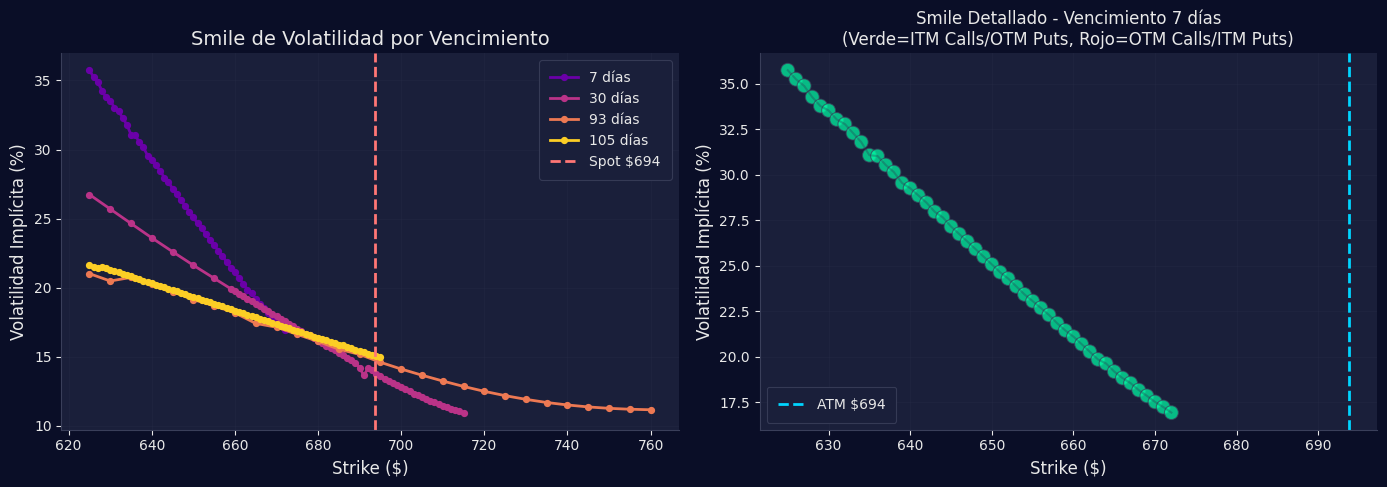

 OBSERVACIONES DEL SMILE:
------------------------------------------------------------
   • La IV suele ser mayor en strikes bajos (puts OTM)
   • Esto refleja el 'skew' o asimetría del mercado
   • El mercado paga más por protección contra caídas
   • La forma del smile cambia según el vencimiento


In [5]:
# ============================================================
# VISUALIZACIÓN DEL SMILE DE VOLATILIDAD (2D)
# ============================================================

# Seleccionar algunos vencimientos específicos para mostrar smiles individuales
vencimientos_unicos = sorted(df_superficie['T'].unique())

# Tomar hasta 4 vencimientos representativos
if len(vencimientos_unicos) >= 4:
    venc_seleccionados = [
        vencimientos_unicos[0],  # Más cercano
        vencimientos_unicos[len(vencimientos_unicos)//3],
        vencimientos_unicos[2*len(vencimientos_unicos)//3],
        vencimientos_unicos[-1]  # Más lejano
    ]
else:
    venc_seleccionados = vencimientos_unicos

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Smiles individuales por vencimiento
ax1 = axes[0]
# Usar colormap plasma para dark mode premium (más elegante que viridis)
colores = plt.cm.plasma(np.linspace(0.2, 0.9, len(venc_seleccionados)))

for T_val, color in zip(venc_seleccionados, colores):
    df_venc = df_superficie[df_superficie['T'] == T_val].sort_values('strike')
    dias = int(T_val * 365)
    ax1.plot(df_venc['strike'], df_venc['iv'], 'o-', 
             color=color, label=f'{dias} días', linewidth=2, markersize=4)

ax1.axvline(x=spot, color=COLORS_PREMIUM['coral'], linestyle='--', linewidth=2, label=f'Spot ${spot:.0f}')
ax1.set_xlabel('Strike ($)', fontsize=12)
ax1.set_ylabel('Volatilidad Implícita (%)', fontsize=12)
ax1.set_title('Smile de Volatilidad por Vencimiento', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Gráfico 2: Smile para el vencimiento más cercano (detalle)
ax2 = axes[1]
T_cercano = vencimientos_unicos[0]
df_cercano = df_superficie[df_superficie['T'] == T_cercano].sort_values('strike')
dias_cercano = int(T_cercano * 365)

# Colorear por moneyness con colores premium
colores_moneyness = [COLORS_PREMIUM['success'] if s < spot else COLORS_PREMIUM['coral'] if s > spot else COLORS_PREMIUM['primary'] 
                      for s in df_cercano['strike']]

ax2.scatter(df_cercano['strike'], df_cercano['iv'], 
            c=colores_moneyness, s=100, alpha=0.7, edgecolors=COLOR_EDGE)
ax2.plot(df_cercano['strike'], df_cercano['iv'], color=COLOR_GRID, alpha=0.3, linewidth=1.5)

ax2.axvline(x=spot, color=COLORS_PREMIUM['primary'], linestyle='--', linewidth=2, label=f'ATM ${spot:.0f}')
ax2.set_xlabel('Strike ($)', fontsize=12)
ax2.set_ylabel('Volatilidad Implícita (%)', fontsize=12)
ax2.set_title(f'Smile Detallado - Vencimiento {dias_cercano} días\n(Verde=ITM Calls/OTM Puts, Rojo=OTM Calls/ITM Puts)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n OBSERVACIONES DEL SMILE:")
print("-" * 60)
print("   • La IV suele ser mayor en strikes bajos (puts OTM)")
print("   • Esto refleja el 'skew' o asimetría del mercado")
print("   • El mercado paga más por protección contra caídas")
print("   • La forma del smile cambia según el vencimiento")

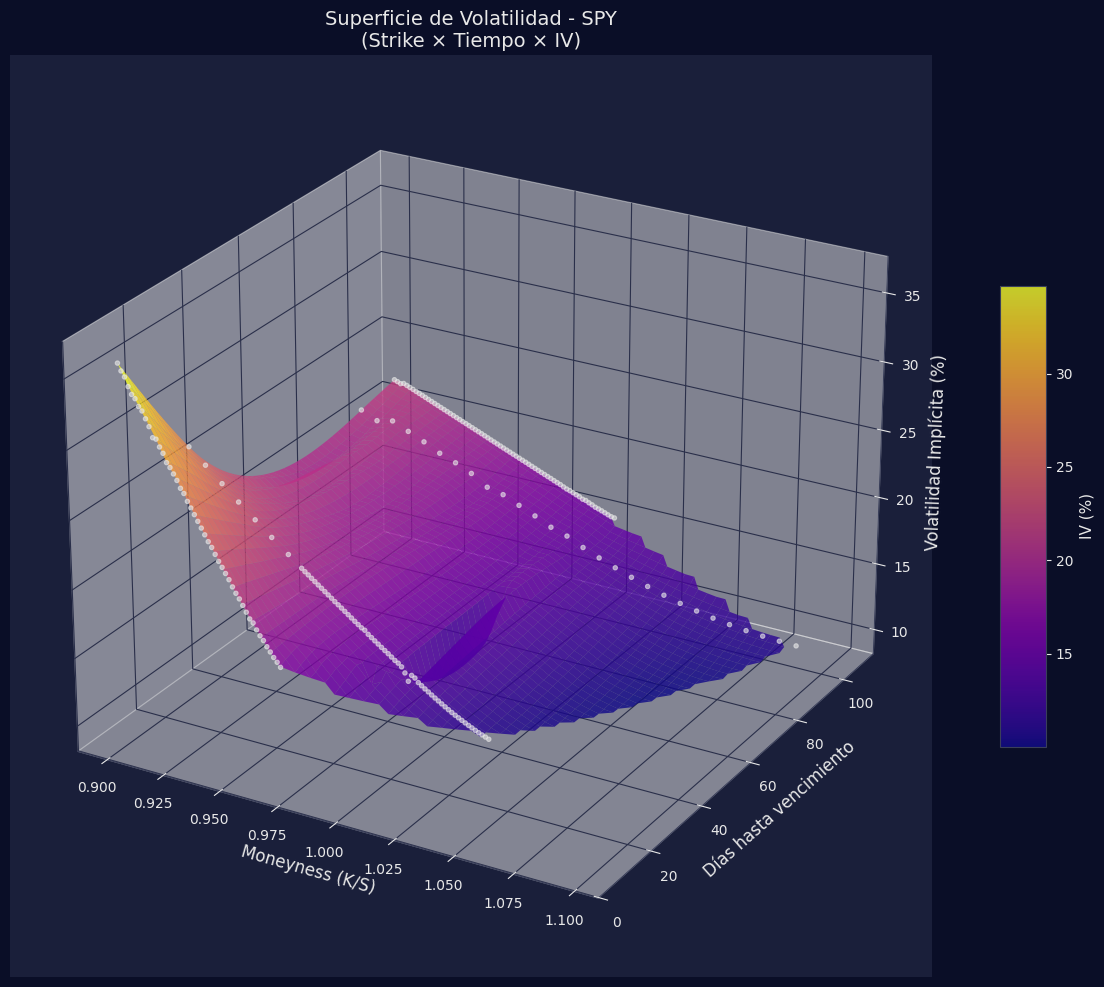

 INTERPRETACIÓN:
------------------------------------------------------------
• Las 'alas' elevadas muestran el skew (puts OTM más caros)
• La estructura temporal puede mostrar contango o backwardation
• Discontinuidades indicarían oportunidades de arbitraje


In [6]:
# ============================================================
# VISUALIZACIÓN 3D DE LA SUPERFICIE
# ============================================================

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Crear grid para interpolación
moneyness_grid = np.linspace(df_superficie['moneyness'].min(), df_superficie['moneyness'].max(), 50)
T_grid = np.linspace(df_superficie['T'].min(), df_superficie['T'].max(), 50)
X, Y = np.meshgrid(moneyness_grid, T_grid)

# Interpolación
Z = griddata(
    (df_superficie['moneyness'], df_superficie['T']),
    df_superficie['iv'],
    (X, Y),
    method='cubic'
)

# Superficie - usar colormap plasma para dark mode premium
surf = ax.plot_surface(X, Y * 365, Z, cmap='plasma', alpha=0.8, linewidth=0, antialiased=True)

# Puntos originales
ax.scatter(df_superficie['moneyness'], df_superficie['T'] * 365, df_superficie['iv'],
           c=COLOR_TEXT, s=10, alpha=0.6)

ax.set_xlabel('Moneyness (K/S)', fontsize=12)
ax.set_ylabel('Días hasta vencimiento', fontsize=12)
ax.set_zlabel('Volatilidad Implícita (%)', fontsize=12)
ax.set_title('Superficie de Volatilidad - SPY\n(Strike × Tiempo × IV)', fontsize=14)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='IV (%)')

# Vista desde ángulo óptimo
ax.view_init(elev=25, azim=-60)

plt.tight_layout()
plt.show()

print("\n INTERPRETACIÓN:")
print("-" * 60)
print("• Las 'alas' elevadas muestran el skew (puts OTM más caros)")
print("• La estructura temporal puede mostrar contango o backwardation")
print("• Discontinuidades indicarían oportunidades de arbitraje")

## 1.5 Calcular Precio Teórico y Griegas (Δ, Γ, Θ, ν, ρ) con vuestro propio código (p.ej. Black–Scholes) y comparación con los del Broker.

Las griegas miden la sensibilidad del precio de la opción a diferentes factores:

| Griega | Símbolo | Mide sensibilidad a... |
|--------|---------|------------------------|
| Delta | Δ | Precio del subyacente |
| Gamma | Γ | Cambio en delta (2ª derivada) |
| Theta | Θ | Paso del tiempo |
| Vega | ν | Volatilidad implícita |
| Rho | ρ | Tasa de interés |

### **Mas Hipotensión de su parte!!!**

Para añadir el cálculo del resto de griegas (Delta, Gamma, Vega, Theta, Rho), debemos expandir tanto la parte de cálculo manual (usando las fórmulas analíticas de Black-Scholes) como la parte de recuperación de datos de Interactive Brokers.

**Fórmulas de las Griegas (Black-Scholes Europeo)**

Para una opción con precio del subyacente $S$, strike $K$, tiempo $T$, tasa $r$, dividendo $q$ y volatilidad $\sigma$:

Recordamos:
$$d_1 = \frac{\ln(S/K) + (r - q + 0.5\sigma^2)T}{\sigma\sqrt{T}}$$

$$d_2 = d_1 - \sigma\sqrt{T}$$

$$N'(x) = \frac{1}{\sqrt{2\pi}} e^{-0.5 x^2} \quad (\text{Densidad de probabilidad})$$



<br>

| **Griega** | **Significado** | **Fórmula Call** | **Fórmula Put** |
|:-----------|:----------------|:-----------------|:----------------|
| **Delta** $(\Delta)$ | Sensibilidad a $S$ | $e^{-qT} N(d_1)$ | $-e^{-qT} N(-d_1)$ |
| **Gamma** $(\Gamma)$ | Curvatura $(\partial^2 / \partial S^2)$ | $\displaystyle\frac{e^{-qT} N'(d_1)}{S \sigma \sqrt{T}}$ | Igual a la Call |
| **Vega** $(\nu)$ | Sensibilidad a $\sigma$ (1%) | $\displaystyle\frac{S \, e^{-qT} N'(d_1) \sqrt{T}}{100}$ | Igual a la Call |
| **Theta** $(\Theta)$ | Pérdida de valor (1 día) | $\displaystyle\frac{1}{365} \left[ -\frac{S \sigma e^{-qT} N'(d_1)}{2\sqrt{T}} - r K e^{-rT} N(d_2) + q S e^{-qT} N(d_1) \right]$ | $\displaystyle\frac{1}{365} \left[ -\frac{S \sigma e^{-qT} N'(d_1)}{2\sqrt{T}} + r K e^{-rT} N(-d_2) - q S e^{-qT} N(-d_1) \right]$ |
| **Rho** $(\rho)$ | Sensibilidad a $r$ (1%) | $\displaystyle\frac{K T e^{-rT} N(d_2)}{100}$ | $\displaystyle\frac{-K T e^{-rT} N(-d_2)}{100}$ |



**En este caso, teníamos muchas maneras de calcular las griegas, entre las cuales, tenemos Bjerksund-Stensland, lo cual estaría recomendado para las opciones Americanas. QuantLib, que nos permite suavizar curvas y hacer muchas pijadas del estilo, y por ultimo el clásico Black-Scholes.**

**En este caso en particular, he decidido usar el Black-Scholes por una de las razones que mencionaste en clase y es que en la mayor parte de los casos, nos va a dar unos resultados muy parecidos al teorico perfecto, y ejercer opciones de manera anticipada por lo que he leido es muy improbable, por lo que el codigo queda mas limpio y las cosas se calculan de amnera instantanea sin iteraciones**

**Además, mi pobre PC, lo pasa un poco mal pidiendo y calculando al mismo tiempo, parece que aqui oias sudar a mi humilde RAM, asi que esta ha sido la solucion mas leegante que he encontrado**

### **Otro problema importante que he sufrido ha sido la inconsistencia en la manera que la API tenía de reportarme los datos, y lo crucial que ha sido normalizarlos mas adelante, y es que las unidades de medida muchas veces no coincidian las unas con las otras, y como muy bien nos indicaste, tambien fui victima de que Rho no fuera reportada**




In [7]:
# ============================================================
# PRECIO TEÓRICO Y GRIEGAS
# ============================================================

# Parámetros de ejemplo
S_ejemplo = spot
K_ejemplo = round(spot)  # ATM
T_ejemplo = 30 / 365  # 30 días
sigma_ejemplo = 0.18  # 18% volatilidad

print("CÁLCULO DE PRECIO TEÓRICO Y GRIEGAS")
print("=" * 60)
print(f"\n Parámetros:")
print(f"   Spot (S): ${S_ejemplo:.2f}")
print(f"   Strike (K): ${K_ejemplo}")
print(f"   Tiempo (T): 30 días")
print(f"   Volatilidad (σ): {sigma_ejemplo*100:.0f}%")
print(f"   Tasa libre riesgo (r): {r*100:.1f}%")
print(f"   Dividend yield (q): {q*100:.1f}%")

# Calcular precios
precio_call = black_scholes(S_ejemplo, K_ejemplo, T_ejemplo, r, sigma_ejemplo, q, 'C')
precio_put = black_scholes(S_ejemplo, K_ejemplo, T_ejemplo, r, sigma_ejemplo, q, 'P')

# Calcular griegas
griegas_call = calcular_griegas(S_ejemplo, K_ejemplo, T_ejemplo, r, sigma_ejemplo, q, 'C')
griegas_put = calcular_griegas(S_ejemplo, K_ejemplo, T_ejemplo, r, sigma_ejemplo, q, 'P')

print(f"\n Precios Teóricos (Black-Scholes):")
print(f"   Call ATM: ${precio_call:.2f} por acción (${precio_call*100:.2f} por contrato)")
print(f"   Put ATM:  ${precio_put:.2f} por acción (${precio_put*100:.2f} por contrato)")

print(f"\n Griegas de la CALL:")
print(f"   Delta (Δ): {griegas_call['delta']:.4f}  → Si SPY sube $1, call sube ${griegas_call['delta']:.2f}")
print(f"   Gamma (Γ): {griegas_call['gamma']:.4f}  → Cambio de delta por $1 de movimiento")
print(f"   Theta (Θ): ${griegas_call['theta']:.4f}/día  → Pérdida diaria por tiempo")
print(f"   Vega (ν):  ${griegas_call['vega']:.4f}  → Cambio por 1% de IV")
print(f"   Rho (ρ):   ${griegas_call['rho']:.4f}  → Cambio por 1% de tasa")

print(f"\n Griegas de la PUT:")
print(f"   Delta (Δ): {griegas_put['delta']:.4f}  → Si SPY sube $1, put baja ${abs(griegas_put['delta']):.2f}")
print(f"   Gamma (Γ): {griegas_put['gamma']:.4f}  → Igual que la call (siempre positivo)")
print(f"   Theta (Θ): ${griegas_put['theta']:.4f}/día  → Pérdida diaria por tiempo")
print(f"   Vega (ν):  ${griegas_put['vega']:.4f}  → Igual que la call")
print(f"   Rho (ρ):   ${griegas_put['rho']:.4f}  → Negativo (puts bajan con tasas altas)")

CÁLCULO DE PRECIO TEÓRICO Y GRIEGAS
 Parámetros:
   Spot (S): $693.75
   Strike (K): $694
   Tiempo (T): 30 días
   Volatilidad (σ): 18%
   Tasa libre riesgo (r): 4.5%
   Dividend yield (q): 1.3%
 Precios Teóricos (Black-Scholes):
   Call ATM: $15.05 por acción ($1504.87 por contrato)
   Put ATM:  $13.48 por acción ($1347.75 por contrato)
 Griegas de la CALL:
   Delta (Δ): 0.5273  → Si SPY sube $1, call sube $0.53
   Gamma (Γ): 0.0111  → Cambio de delta por $1 de movimiento
   Theta (Θ): $-0.2674/día  → Pérdida diaria por tiempo
   Vega (ν):  $0.7907  → Cambio por 1% de IV
   Rho (ρ):   $0.2883  → Cambio por 1% de tasa
 Griegas de la PUT:
   Delta (Δ): -0.4717  → Si SPY sube $1, put baja $0.47
   Gamma (Γ): 0.0111  → Igual que la call (siempre positivo)
   Theta (Θ): $-0.2069/día  → Pérdida diaria por tiempo
   Vega (ν):  $0.7907  → Igual que la call
   Rho (ρ):   $-0.2800  → Negativo (puts bajan con tasas altas)


**Aqui te pongo un ejemplo dodn elos valores pueden cambiar si se introducen los datos que se van a simular**

### **Aqui viene lo gordo:**
## 1.6 Representar la Evolución temporal histórica de la opción (griegas y payoff)

Las griegas no son constantes: su magnitud y sensibilidad cambian de forma significativa a medida que se acerca el vencimiento de la opción. Este efecto es especialmente marcado en opciones ATM (at-the-money).

- Gamma:  
  Se incrementa de forma explosiva cerca del vencimiento para opciones ATM.  
  Esto implica que el delta cambia muy rápido ante pequeños movimientos del subyacente, aumentando el riesgo y la necesidad de rebalanceo.

- Theta:  
  El decaimiento temporal se acelera en las últimas semanas (y especialmente en los últimos días).  
  Cada día que pasa tiene un impacto mayor en el valor de la opción, penalizando a los compradores y beneficiando a los vendedores.

- Vega:  
  Disminuye conforme se acerca el vencimiento, ya que queda menos tiempo para que la volatilidad tenga efecto.  
  Los cambios en la volatilidad implícita influyen cada vez menos en el precio de la opción.

En conjunto, cerca del vencimiento:

Gamma y theta dominan, mientras que vega pierde relevancia.

Por eso, la gestión de posiciones cortas en opciones ATM cerca del vencimiento requiere especial atención al riesgo de movimientos bruscos y pérdida acelerada de valor.

### **Una vez mas, aqui, decido simular esa evolución temporal en pos de que el código corra con cualquier tipo de cuenta, pero esto sería facimente arreglable si se tuviera acceso constante a una API sin requeriminto de subscripcion a la API**

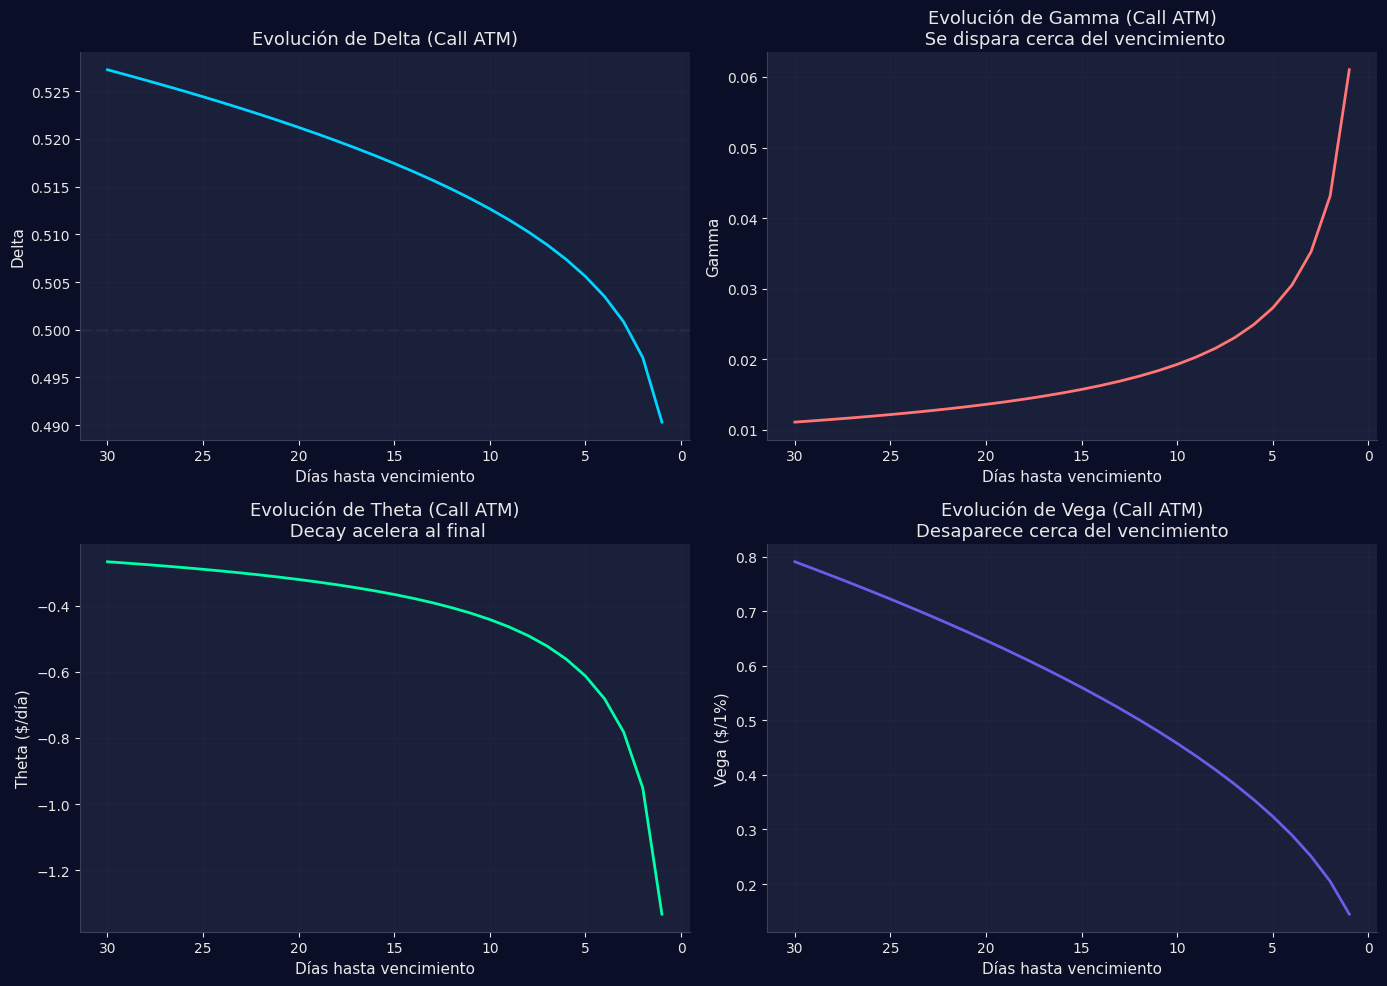

 CONCLUSIONES CLAVE:
------------------------------------------------------------
• GAMMA: Peligroso cerca del vencimiento para opciones ATM
• THETA: La última semana es cuando más valor se pierde
• VEGA: No tiene sentido comprar volatilidad a días del vencimiento


In [8]:
# ============================================================
# EVOLUCIÓN TEMPORAL DE GRIEGAS
# ============================================================

# Parámetros
K = round(spot)  # ATM
sigma = 0.18
T_inicial = 30 / 365  # 30 días

# Simular evolución día a día
dias = np.arange(30, 0, -1)
tiempos = dias / 365

evolucion = []
for t in tiempos:
    g = calcular_griegas(spot, K, t, r, sigma, q, 'C')
    g['dias_restantes'] = t * 365
    g['T'] = t
    evolucion.append(g)

df_evolucion = pd.DataFrame(evolucion)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Delta
ax1 = axes[0, 0]
ax1.plot(df_evolucion['dias_restantes'], df_evolucion['delta'], color=COLORS_PREMIUM['primary'], linewidth=2)
ax1.set_xlabel('Días hasta vencimiento')
ax1.set_ylabel('Delta')
ax1.set_title('Evolución de Delta (Call ATM)')
ax1.axhline(y=0.5, color=COLOR_GRID, linestyle='--', alpha=0.5)
ax1.invert_xaxis()
ax1.grid(True, alpha=0.3)

# Gamma
ax2 = axes[0, 1]
ax2.plot(df_evolucion['dias_restantes'], df_evolucion['gamma'], color=COLORS_PREMIUM['coral'], linewidth=2)
ax2.set_xlabel('Días hasta vencimiento')
ax2.set_ylabel('Gamma')
ax2.set_title('Evolución de Gamma (Call ATM)\n Se dispara cerca del vencimiento')
ax2.invert_xaxis()
ax2.grid(True, alpha=0.3)

# Theta
ax3 = axes[1, 0]
ax3.plot(df_evolucion['dias_restantes'], df_evolucion['theta'], color=COLORS_PREMIUM['success'], linewidth=2)
ax3.set_xlabel('Días hasta vencimiento')
ax3.set_ylabel('Theta ($/día)')
ax3.set_title('Evolución de Theta (Call ATM)\n Decay acelera al final')
ax3.invert_xaxis()
ax3.grid(True, alpha=0.3)

# Vega
ax4 = axes[1, 1]
ax4.plot(df_evolucion['dias_restantes'], df_evolucion['vega'], color=COLORS_PREMIUM['info'], linewidth=2)
ax4.set_xlabel('Días hasta vencimiento')
ax4.set_ylabel('Vega ($/1%)')
ax4.set_title('Evolución de Vega (Call ATM)\nDesaparece cerca del vencimiento')
ax4.invert_xaxis()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n CONCLUSIONES CLAVE:")
print("-" * 60)
print("• GAMMA: Peligroso cerca del vencimiento para opciones ATM")
print("• THETA: La última semana es cuando más valor se pierde")
print("• VEGA: No tiene sentido comprar volatilidad a días del vencimiento")

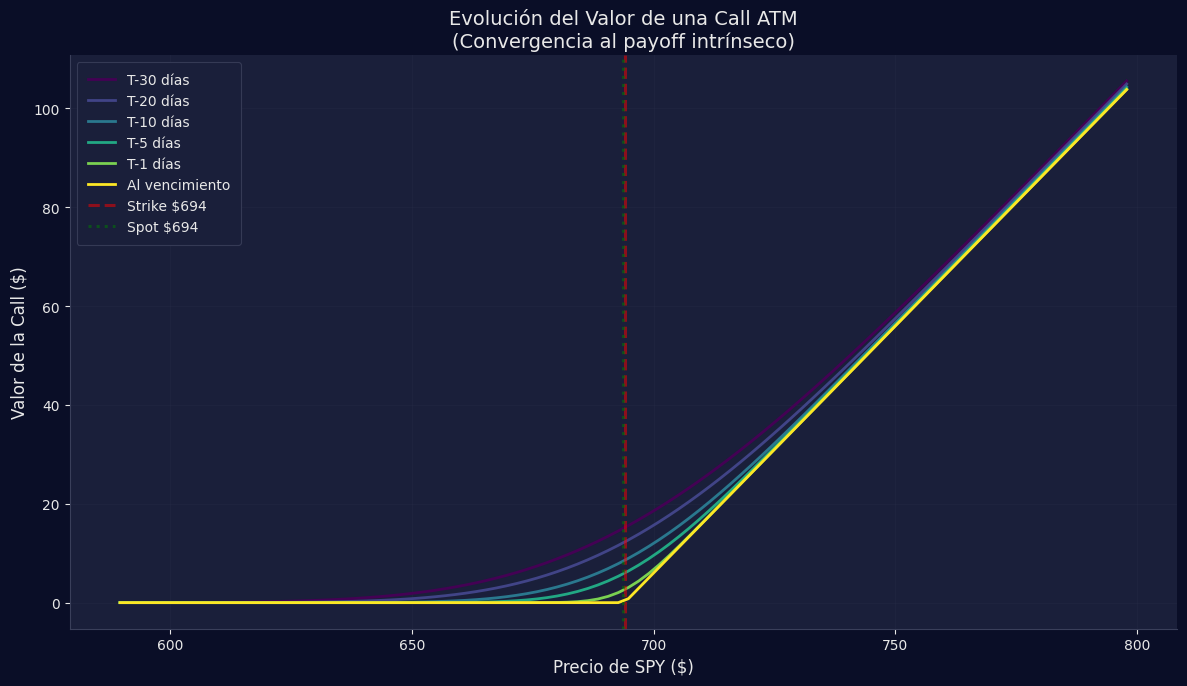

In [9]:
# ============================================================
# EVOLUCIÓN DEL PAYOFF EN EL TIEMPO
# ============================================================

precios = np.linspace(spot * 0.85, spot * 1.15, 100)
tiempos_plot = [30, 20, 10, 5, 1, 0]  # días

fig, ax = plt.subplots(figsize=(12, 7))

colors = plt.cm.viridis(np.linspace(0, 1, len(tiempos_plot)))

for i, dias_rest in enumerate(tiempos_plot):
    T_calc = dias_rest / 365
    if T_calc > 0:
        valores = [black_scholes(S, K, T_calc, r, sigma, q, 'C') for S in precios]
        label = f'T-{dias_rest} días'
    else:
        valores = [max(S - K, 0) for S in precios]
        label = 'Al vencimiento'
    
    ax.plot(precios, valores, color=colors[i], linewidth=2, label=label)

ax.axvline(x=K, color='red', linestyle='--', alpha=0.5, label=f'Strike ${K}')
ax.axvline(x=spot, color='green', linestyle=':', alpha=0.5, label=f'Spot ${spot:.0f}')

ax.set_xlabel('Precio de SPY ($)', fontsize=12)
ax.set_ylabel('Valor de la Call ($)', fontsize=12)
ax.set_title('Evolución del Valor de una Call ATM\n(Convergencia al payoff intrínseco)', fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1.7 Función de Cobertura: Posición Cubierta vs Expuesta (Delta-Hedging)

### ¿Qué es el Delta-Hedging?

El delta-hedging es una técnica de cobertura utilizada en opciones para neutralizar la exposición al movimiento del precio del subyacente. Dado que el valor de una opción cambia cuando se mueve el subyacente, el delta-hedging consiste en comprar o vender el activo subyacente en proporción al delta de la opción para que la posición total sea direccionalmente neutra.

Conceptualmente:

- Posición expuesta (sin cobertura):  
  Solo mantenemos la opción. El P&L depende directamente de si el mercado sube o baja.

- Posición cubierta (delta-neutral):  
  Opción + posición en el subyacente en proporción a –delta.  
  El objetivo es que pequeños movimientos del precio no afecten significativamente al P&L, aislando otros factores como la volatilidad y el paso del tiempo.

Ejemplo:  
Si una call tiene delta = +0.40, se vende 0.40 unidades del subyacente para neutralizar la exposición direccional.



### ¿Qué es el Gamma Scalping?

El gamma scalping es una estrategia que se apoya en el rebalanceo continuo de una posición delta-neutral para monetizar la volatilidad del mercado.

Cuando tenemos gamma positivo (por ejemplo, estando largos de opciones):
- Si el precio baja, el delta disminuye → compramos subyacente.
- Si el precio sube, el delta aumenta → vendemos subyacente.

De esta forma, se repite el ciclo:
comprar bajo y vender alto

El beneficio del gamma scalping proviene de:
- La oscilación del precio (volatilidad realizada)
- Menos el coste del theta (pérdida por paso del tiempo)

En resumen, el gamma scalping busca transformar movimiento del precio en beneficio, siempre que la volatilidad realizada sea mayor que la implícita pagada al entrar en la posición.


In [10]:
# ============================================================
# SIMULACIÓN DE DELTA-HEDGING CON ACCIONES (GAMMA SCALPING)
# ============================================================

def simular_delta_hedge(spot_inicial, K, T_dias, sigma, r, q, num_rebalanceos=10, seed=42):
    """
    Simula un straddle con y sin delta-hedging usando acciones.
    
    Parámetros:
    -----------
    spot_inicial : precio inicial del subyacente
    K : strike del straddle (ATM)
    T_dias : días hasta vencimiento
    sigma : volatilidad para simular el precio
    r, q : tasa libre de riesgo y dividend yield
    num_rebalanceos : cada cuántos pasos rebalanceamos
    """
    np.random.seed(seed)
    
    T = T_dias / 365
    dt = T / T_dias  # paso diario
    
    # Simular path del precio (GBM)
    precios = [spot_inicial]
    for _ in range(T_dias):
        dW = np.random.normal(0, np.sqrt(dt))
        S_nuevo = precios[-1] * np.exp((r - q - 0.5*sigma**2)*dt + sigma*dW)
        precios.append(S_nuevo)
    precios = np.array(precios)
    
    # Costo inicial del straddle
    call_inicial = black_scholes(spot_inicial, K, T, r, sigma, q, 'C')
    put_inicial = black_scholes(spot_inicial, K, T, r, sigma, q, 'P')
    costo_straddle = (call_inicial + put_inicial) * 100
    
    # ===== SIMULACIÓN SIN HEDGE =====
    spot_final = precios[-1]
    payoff_sin_hedge = abs(spot_final - K) * 100
    pnl_sin_hedge = payoff_sin_hedge - costo_straddle
    
    # ===== SIMULACIÓN CON DELTA-HEDGE =====
    posicion_acciones = 0  # acciones en cartera (+ = long, - = short)
    cash_hedge = 0  # P&L del hedging
    historial_hedge = []
    
    for dia in range(T_dias):
        S = precios[dia]
        T_restante = (T_dias - dia) / 365
        
        if T_restante <= 0:
            break
        
        # Calcular delta actual del straddle
        delta_call = calcular_griegas(S, K, T_restante, r, sigma, q, 'C')['delta']
        delta_put = calcular_griegas(S, K, T_restante, r, sigma, q, 'P')['delta']
        delta_straddle = (delta_call + delta_put) * 100  # por 100 acciones
        
        # Rebalancear cada N días
        if dia % num_rebalanceos == 0:
            # Acciones necesarias para neutralizar = -delta_straddle
            acciones_objetivo = -delta_straddle
            acciones_a_operar = acciones_objetivo - posicion_acciones
            
            # Ejecutar trade de acciones
            cash_hedge -= acciones_a_operar * S  # compramos (+) o vendemos (-)
            posicion_acciones = acciones_objetivo
            
            historial_hedge.append({
                'dia': dia,
                'spot': S,
                'delta_straddle': delta_straddle,
                'acciones_operadas': acciones_a_operar,
                'posicion_total': posicion_acciones
            })
    
    # Cerrar posición de acciones al vencimiento
    cash_hedge += posicion_acciones * precios[-1]
    
    # P&L total con hedge
    pnl_con_hedge = payoff_sin_hedge - costo_straddle + cash_hedge
    
    return {
        'precios': precios,
        'costo_straddle': costo_straddle,
        'payoff': payoff_sin_hedge,
        'pnl_sin_hedge': pnl_sin_hedge,
        'pnl_con_hedge': pnl_con_hedge,
        'ganancia_hedge': cash_hedge,
        'historial': pd.DataFrame(historial_hedge)
    }


# ============================================================
# EJECUTAR SIMULACIÓN
# ============================================================

print("SIMULACIÓN: STRADDLE CON VS SIN DELTA-HEDGING")
print("=" * 60)

# Parámetros
spot_sim = spot
K_sim = round(spot)
T_sim = 30  # 30 días
sigma_sim = 0.20  # 20% vol

resultado = simular_delta_hedge(spot_sim, K_sim, T_sim, sigma_sim, r, q, num_rebalanceos=5)

print(f"\n Parámetros:")
print(f"   Spot inicial: ${spot_sim:.2f}")
print(f"   Strike: ${K_sim}")
print(f"   Días: {T_sim}")
print(f"   Volatilidad: {sigma_sim*100:.0f}%")
print(f"   Rebalanceo cada: 5 días")

print(f"\n Resultados:")
print(f"   Costo del straddle: ${resultado['costo_straddle']:.2f}")
print(f"   Payoff al vencimiento: ${resultado['payoff']:.2f}")
print(f"   " + "-" * 40)
print(f"   P&L SIN hedge: ${resultado['pnl_sin_hedge']:.2f}")
print(f"   P&L CON hedge: ${resultado['pnl_con_hedge']:.2f}")
print(f"   Ganancia por hedging: ${resultado['ganancia_hedge']:.2f}")

print(f"\n Historial de rebalanceos:")
print(resultado['historial'].to_string(index=False))

SIMULACIÓN: STRADDLE CON VS SIN DELTA-HEDGING
 Parámetros:
   Spot inicial: $693.75
   Strike: $694
   Días: 30
   Volatilidad: 20%
   Rebalanceo cada: 5 días
 Resultados:
   Costo del straddle: $3168.92
   Payoff al vencimiento: $3940.97
   ----------------------------------------
   P&L SIN hedge: $772.05
   P&L CON hedge: $1196.85
   Ganancia por hedging: $424.80
 Historial de rebalanceos:
 dia       spot  delta_straddle  acciones_operadas  posicion_total
   0 693.750000        5.436003          -5.436003       -5.436003
   5 710.736220       39.888278         -34.452275      -39.888278
  10 727.304775       71.129516         -31.241238      -71.129516
  15 695.221024        7.648936          63.480580       -7.648936
  20 669.749990      -69.738556          77.387492       69.738556
  25 665.235803      -92.441910          22.703354       92.441910


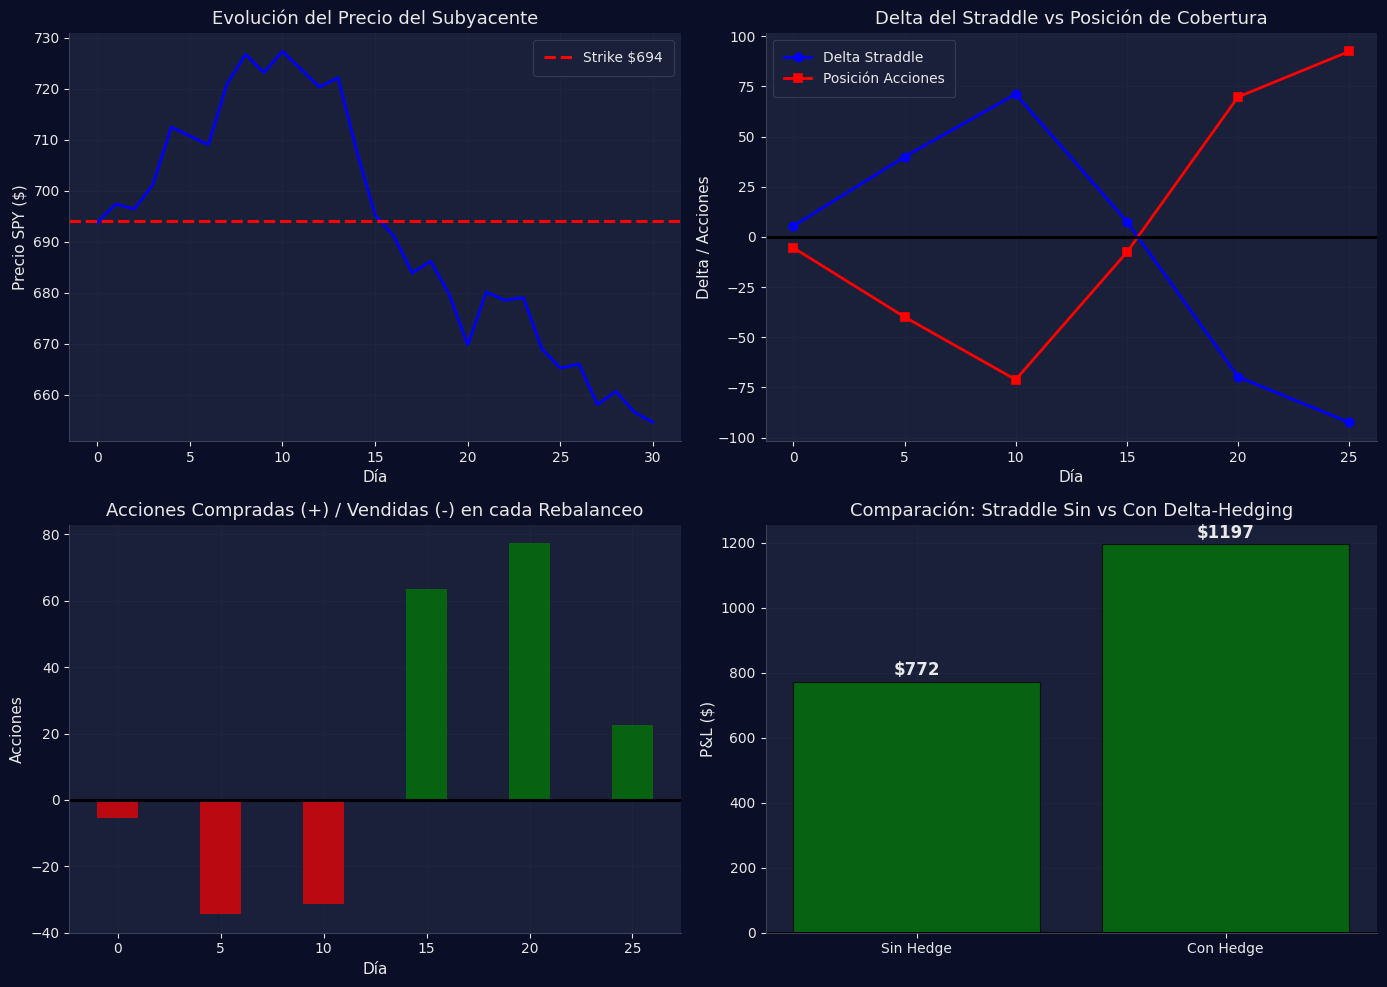

 CONCLUSIÓN:
------------------------------------------------------------
   El delta-hedging (gamma scalping) genera P&L adicional
   al comprar barato y vender caro durante los rebalanceos.
   Si vol realizada > vol implícita pagada: GANAMOS.
   Si vol realizada < vol implícita pagada: PERDEMOS.


In [11]:
# ============================================================
# VISUALIZACIÓN DEL DELTA-HEDGING
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Precio del subyacente
ax1 = axes[0, 0]
ax1.plot(resultado['precios'], 'b-', linewidth=2)
ax1.axhline(y=K_sim, color='red', linestyle='--', label=f'Strike ${K_sim}')
ax1.set_xlabel('Día')
ax1.set_ylabel('Precio SPY ($)')
ax1.set_title('Evolución del Precio del Subyacente')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Delta del straddle y posición en acciones
ax2 = axes[0, 1]
df_h = resultado['historial']
ax2.plot(df_h['dia'], df_h['delta_straddle'], 'b-o', label='Delta Straddle', linewidth=2)
ax2.plot(df_h['dia'], df_h['posicion_total'], 'r-s', label='Posición Acciones', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.set_xlabel('Día')
ax2.set_ylabel('Delta / Acciones')
ax2.set_title('Delta del Straddle vs Posición de Cobertura')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Acciones operadas en cada rebalanceo
ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in df_h['acciones_operadas']]
ax3.bar(df_h['dia'], df_h['acciones_operadas'], color=colors, alpha=0.7, width=2)
ax3.axhline(y=0, color='black', linestyle='-')
ax3.set_xlabel('Día')
ax3.set_ylabel('Acciones')
ax3.set_title('Acciones Compradas (+) / Vendidas (-) en cada Rebalanceo')
ax3.grid(True, alpha=0.3)

# 4. Comparación P&L
ax4 = axes[1, 1]
categorias = ['Sin Hedge', 'Con Hedge']
valores = [resultado['pnl_sin_hedge'], resultado['pnl_con_hedge']]
colores = ['red' if v < 0 else 'green' for v in valores]
bars = ax4.bar(categorias, valores, color=colores, alpha=0.7, edgecolor='black')
ax4.axhline(y=0, color='black', linestyle='-')
ax4.set_ylabel('P&L ($)')
ax4.set_title('Comparación: Straddle Sin vs Con Delta-Hedging')
for bar, val in zip(bars, valores):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 20, f'${val:.0f}', 
             ha='center', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n CONCLUSIÓN:")
print("-" * 60)
print("   El delta-hedging (gamma scalping) genera P&L adicional")
print("   al comprar barato y vender caro durante los rebalanceos.")
print("   Si vol realizada > vol implícita pagada: GANAMOS.")
print("   Si vol realizada < vol implícita pagada: PERDEMOS.")

Ejecutando 2000 simulaciones...
 Estadísticas sobre 2000 simulaciones:
   Métrica                      Sin Hedge    Con Hedge
   --------------------------------------------------
   P&L Promedio              $    137.39 $     28.54
   P&L Mediano               $   -334.73 $     -9.92
   Desv. Estándar            $   2517.58 $   1099.36
   % Rentables                     45.2%       49.6%


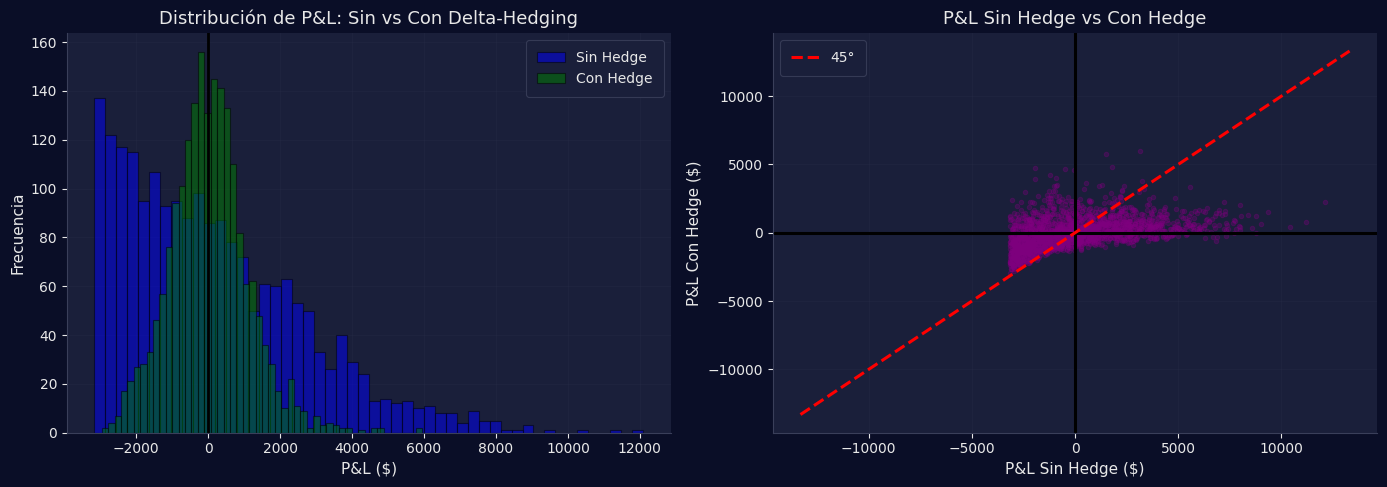

 INTERPRETACIÓN:
------------------------------------------------------------
   • El hedge REDUCE la varianza del P&L (menos riesgo)
   • En promedio, el resultado depende de IV vs Vol Realizada
   • El scatter muestra que hedge y sin-hedge están correlacionados
   • pero el hedge suaviza los extremos


In [12]:
# ============================================================
# MÚLTIPLES SIMULACIONES: DISTRIBUCIÓN DE RESULTADOS
# ============================================================

print("Ejecutando 2000 simulaciones...")

resultados_mc = []
for i in range(2000):
    res = simular_delta_hedge(spot_sim, K_sim, T_sim, sigma_sim, r, q, 
                               num_rebalanceos=5, seed=i)
    resultados_mc.append({
        'pnl_sin_hedge': res['pnl_sin_hedge'],
        'pnl_con_hedge': res['pnl_con_hedge'],
        'ganancia_hedge': res['ganancia_hedge']
    })

df_mc = pd.DataFrame(resultados_mc)

print(f"\n Estadísticas sobre 2000 simulaciones:")
print(f"   " + "=" * 50)
print(f"   {'Métrica':<25} {'Sin Hedge':>12} {'Con Hedge':>12}")
print(f"   " + "-" * 50)
print(f"   {'P&L Promedio':<25} ${df_mc['pnl_sin_hedge'].mean():>10.2f} ${df_mc['pnl_con_hedge'].mean():>10.2f}")
print(f"   {'P&L Mediano':<25} ${df_mc['pnl_sin_hedge'].median():>10.2f} ${df_mc['pnl_con_hedge'].median():>10.2f}")
print(f"   {'Desv. Estándar':<25} ${df_mc['pnl_sin_hedge'].std():>10.2f} ${df_mc['pnl_con_hedge'].std():>10.2f}")
print(f"   {'% Rentables':<25} {(df_mc['pnl_sin_hedge']>0).mean()*100:>10.1f}% {(df_mc['pnl_con_hedge']>0).mean()*100:>10.1f}%")
print(f"   " + "=" * 50)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(df_mc['pnl_sin_hedge'], bins=50, alpha=0.5, label='Sin Hedge', color='blue', edgecolor='black')
ax1.hist(df_mc['pnl_con_hedge'], bins=50, alpha=0.5, label='Con Hedge', color='green', edgecolor='black')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax1.set_xlabel('P&L ($)')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de P&L: Sin vs Con Delta-Hedging')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.scatter(df_mc['pnl_sin_hedge'], df_mc['pnl_con_hedge'], alpha=0.3, s=10, c='purple')
ax2.axhline(y=0, color='black', linestyle='-')
ax2.axvline(x=0, color='black', linestyle='-')
lim = max(abs(df_mc['pnl_sin_hedge']).max(), abs(df_mc['pnl_con_hedge']).max()) * 1.1
ax2.plot([-lim, lim], [-lim, lim], 'r--', label='45°')
ax2.set_xlabel('P&L Sin Hedge ($)')
ax2.set_ylabel('P&L Con Hedge ($)')
ax2.set_title('P&L Sin Hedge vs Con Hedge')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n INTERPRETACIÓN:")
print("-" * 60)
print("   • El hedge REDUCE la varianza del P&L (menos riesgo)")
print("   • En promedio, el resultado depende de IV vs Vol Realizada")
print("   • El scatter muestra que hedge y sin-hedge están correlacionados")
print("   • pero el hedge suaviza los extremos")

## 1.8 Simular Envío de Órdenes y Cobertura

Implementamos funciones para enviar órdenes a Interactive Brokers:

- **Orden simple**: Comprar/vender una opción individual
- **Orden combo**: Ejecutar múltiples patas simultáneamente (straddle, spread)
- **Sistema de confirmación**: Verificación de tipo de cuenta y confirmación explícita

In [13]:
# ============================================================
# ENVÍO DE ÓRDENES A IBKR
# ============================================================

from ib_insync import IB, Option, MarketOrder, Contract, ComboLeg # Asegurar imports

# Definimos la variable que faltaba
IBKR_DISPONIBLE = True 

def crear_orden_opcion_simple(ib, simbolo, strike, vencimiento, tipo_opcion, accion, cantidad):
    """
    Crea y envía una orden simple de opción.
    """
    contrato = Option(
        symbol=simbolo,
        lastTradeDateOrContractMonth=vencimiento,
        strike=strike,
        right=tipo_opcion,
        exchange='SMART',
        currency='USD'
    )
    
    # Calificar el contrato
    ib.qualifyContracts(contrato)
    
    # Crear orden de mercado
    orden = MarketOrder(accion, cantidad)
    
    # Enviar
    trade = ib.placeOrder(contrato, orden)
    
    return trade

def crear_orden_straddle_combo(ib, simbolo, strike, vencimiento, accion, cantidad):
    """
    Crea un combo de straddle (call + put mismo strike).
    """
    # Crear contratos individuales
    call = Option(simbolo, vencimiento, strike, 'C', 'SMART')
    put = Option(simbolo, vencimiento, strike, 'P', 'SMART')
    
    # Es crucial calificar las patas antes de armar el combo
    ib.qualifyContracts(call, put)
    
    # Crear combo
    combo = Contract()
    combo.symbol = simbolo
    combo.secType = 'BAG'
    combo.currency = 'USD'
    combo.exchange = 'SMART'
    
    leg1 = ComboLeg()
    leg1.conId = call.conId
    leg1.ratio = 1
    leg1.action = accion
    leg1.exchange = 'SMART'
    
    leg2 = ComboLeg()
    leg2.conId = put.conId
    leg2.ratio = 1
    leg2.action = accion
    leg2.exchange = 'SMART'
    
    combo.comboLegs = [leg1, leg2]
    
    orden = MarketOrder(accion, cantidad)
    trade = ib.placeOrder(combo, orden)
    
    return trade


# ============================================================
# GESTIÓN DE LA CONEXIÓN 
# ============================================================

# Verificar si ya existe una conexión activa para no sobrescribirla
if 'ib' in globals() and ib is not None and ib.isConnected():
    print(f" Ya existe una conexión activa a IBKR (Cuenta: {ib.managedAccounts()})")
    print("  Se utilizará la conexión existente.")

elif IBKR_DISPONIBLE:
    try:
        print("Intentando conectar a IBKR...")
        ib = IB()
        # Nota: clientId=11 para evitar conflicto si la sesión anterior quedó colgada
        ib.connect('127.0.0.1', 7497, clientId=11) 
        print(f" Conectado a IBKR")
        print(f"  Cuentas: {ib.managedAccounts()}")
    except Exception as e:
        print(f" No se pudo conectar a IBKR: {e}")
        ib = None
else:
    print(" Modo IBKR desactivado (IBKR_DISPONIBLE = False)")
    ib = None

# ============================================================
# EJEMPLO DE USO
# ============================================================

print("\nCÓDIGO PARA ENVÍO DE ÓRDENES A IBKR")
print("=" * 60)

if ib is not None and ib.isConnected():
    print("\n Conectado a IBKR - Puedes ejecutar las funciones de arriba")
    print("\nEjemplo de uso (Copia y modifica esto en una celda nueva):")
    print("""
    # 1. Definir parámetros
    symbol = 'SPY'
    strike = 600  # Ajustar a un strike realista
    expiration = '20250620' # Ajustar fecha (YYYYMMDD)

    # 2. Enviar Orden Simple (CUIDADO: Es una orden real en Paper Trading)
    # trade_simple = crear_orden_opcion_simple(ib, symbol, strike, expiration, 'C', 'BUY', 1)
    
    # 3. Enviar Combo Straddle
    # trade_combo = crear_orden_straddle_combo(ib, symbol, strike, expiration, 'BUY', 1)
    """)
else:
    print("\n IBKR no conectado - Revisa que TWS/Gateway esté abierto en puerto 7497")

 Ya existe una conexión activa a IBKR (Cuenta: ['DUO962224'])
  Se utilizará la conexión existente.
CÓDIGO PARA ENVÍO DE ÓRDENES A IBKR
 Conectado a IBKR - Puedes ejecutar las funciones de arriba
Ejemplo de uso (Copia y modifica esto en una celda nueva):
    # 1. Definir parámetros
    symbol = 'SPY'
    strike = 600  # Ajustar a un strike realista
    expiration = '20250620' # Ajustar fecha (YYYYMMDD)
    # 2. Enviar Orden Simple (CUIDADO: Es una orden real en Paper Trading)
    # trade_simple = crear_orden_opcion_simple(ib, symbol, strike, expiration, 'C', 'BUY', 1)
    # 3. Enviar Combo Straddle
    # trade_combo = crear_orden_straddle_combo(ib, symbol, strike, expiration, 'BUY', 1)


In [14]:
# ============================================================
# ENVÍO REAL DE ÓRDENES A IBKR (CON CONFIRMACIÓN)
# ============================================================

def detectar_tipo_cuenta(ib):
    """
    Detecta si estamos conectados a una cuenta Paper o Real.
    Las cuentas Paper de IBKR suelen empezar con 'D' (Demo).
    """
    cuentas = ib.managedAccounts()
    if not cuentas:
        return "DESCONOCIDA", None
    
    cuenta = cuentas[0]
    # Cuentas paper suelen empezar con 'D' (DU, DF, etc.)
    if cuenta.startswith('D'):
        return "PAPER (SIMULACIÓN)", cuenta
    else:
        return " REAL (DINERO REAL)", cuenta


def enviar_orden_con_confirmacion(ib, tipo_orden, **kwargs):
    """
    Envía una orden a IBKR pidiendo confirmación explícita al usuario.
    
    Parámetros:
    -----------
    ib : objeto IB conectado
    tipo_orden : str ('simple' o 'straddle')
    **kwargs : parámetros de la orden (simbolo, strike, vencimiento, etc.)
    """
    # Verificar conexión
    if ib is None or not ib.isConnected():
        print(" ERROR: No hay conexión activa con IBKR.")
        print("   Ejecuta primero la celda de conexión.")
        return None
    
    # Detectar tipo de cuenta
    tipo_cuenta, num_cuenta = detectar_tipo_cuenta(ib)
    
    # Mostrar información de la orden
    print("=" * 60)
    print(" RESUMEN DE LA ORDEN")
    print("=" * 60)
    print(f"\n TIPO DE CUENTA: {tipo_cuenta}")
    print(f"   Número de cuenta: {num_cuenta}")
    
    if "REAL" in tipo_cuenta:
        print("\n" + "" * 20)
        print("   ¡¡¡ATENCIÓN: ESTÁS EN UNA CUENTA CON DINERO REAL!!!")
        print("" * 20)
    
    print(f"\n Detalles de la orden:")
    print(f"   Tipo: {tipo_orden.upper()}")
    print(f"   Símbolo: {kwargs.get('simbolo', 'N/A')}")
    print(f"   Strike: ${kwargs.get('strike', 'N/A')}")
    print(f"   Vencimiento: {kwargs.get('vencimiento', 'N/A')}")
    print(f"   Acción: {kwargs.get('accion', 'N/A')}")
    print(f"   Cantidad: {kwargs.get('cantidad', 'N/A')}")
    
    if tipo_orden == 'simple':
        print(f"   Tipo opción: {'CALL' if kwargs.get('tipo_opcion') == 'C' else 'PUT'}")
    elif tipo_orden == 'straddle':
        print(f"   Tipo opción: STRADDLE (CALL + PUT)")
    
    # Pedir confirmación
    print("\n" + "-" * 60)
    confirmacion = input("¿Confirmas el envío de esta orden? (escribe 'SI' para confirmar): ")
    
    if confirmacion.strip().upper() != 'SI':
        print("\n Orden CANCELADA por el usuario.")
        return None
    
    # Ejecutar la orden
    print("\n Enviando orden...")
    
    try:
        if tipo_orden == 'simple':
            trade = crear_orden_opcion_simple(
                ib,
                kwargs['simbolo'],
                kwargs['strike'],
                kwargs['vencimiento'],
                kwargs['tipo_opcion'],
                kwargs['accion'],
                kwargs['cantidad']
            )
        elif tipo_orden == 'straddle':
            trade = crear_orden_straddle_combo(
                ib,
                kwargs['simbolo'],
                kwargs['strike'],
                kwargs['vencimiento'],
                kwargs['accion'],
                kwargs['cantidad']
            )
        else:
            print(f" Tipo de orden no reconocido: {tipo_orden}")
            return None
        
        # Esperar un momento para que se procese
        ib.sleep(1)
        
        print(f"\n Orden enviada correctamente.")
        print(f"   Estado: {trade.orderStatus.status}")
        print(f"   Order ID: {trade.order.orderId}")
        
        return trade
        
    except Exception as e:
        print(f"\n ERROR al enviar la orden: {e}")
        return None


# ============================================================
# EJEMPLO DE USO
# ============================================================

print("FUNCIONES DE ENVÍO CON CONFIRMACIÓN CARGADAS")
print("=" * 60)
print("\nEjemplos de uso:")
print("""
# Opción simple (call o put):
trade = enviar_orden_con_confirmacion(
    ib,
    tipo_orden='simple',
    simbolo='SPY',
    strike=600,
    vencimiento='20250321',
    tipo_opcion='C',      # 'C' para Call, 'P' para Put
    accion='BUY',         # 'BUY' o 'SELL'
    cantidad=1
)

# Straddle (call + put mismo strike):
trade = enviar_orden_con_confirmacion(
    ib,
    tipo_orden='straddle',
    simbolo='SPY',
    strike=600,
    vencimiento='20250321',
    accion='BUY',
    cantidad=1
)
""")

# Mostrar estado de conexión actual
if ib is not None and ib.isConnected():
    tipo_cuenta, num_cuenta = detectar_tipo_cuenta(ib)
    print(f"\n Conexión activa: {tipo_cuenta} ({num_cuenta})")
else:
    print("\n No hay conexión activa con IBKR.")

FUNCIONES DE ENVÍO CON CONFIRMACIÓN CARGADAS
Ejemplos de uso:
# Opción simple (call o put):
trade = enviar_orden_con_confirmacion(
    ib,
    tipo_orden='simple',
    simbolo='SPY',
    strike=600,
    vencimiento='20250321',
    tipo_opcion='C',      # 'C' para Call, 'P' para Put
    accion='BUY',         # 'BUY' o 'SELL'
    cantidad=1
)
# Straddle (call + put mismo strike):
trade = enviar_orden_con_confirmacion(
    ib,
    tipo_orden='straddle',
    simbolo='SPY',
    strike=600,
    vencimiento='20250321',
    accion='BUY',
    cantidad=1
)
 Conexión activa: PAPER (SIMULACIÓN) (DUO962224)


**Aqui, tuve problemas a la hora de mandar de manera automatica ordenes que ya no existian al broker, ya que estamos usando delayed frozen data, por lo que cree unas funciones anexas que deberian ser capaces de ejecutarse cuando tenemos información en vivo o delayed, pero como la API es un poco pesetera, en el futuro solo habría que pegarlas en una celda de este nootbok con los criterios** 

**Un compañero (con mas pasta que yo) me ha dicho que funciona**

## Sistema Mejorado de Gestión de Órdenes

Este sistema permite crear y gestionar órdenes de opciones en IBKR de forma interactiva y con outputs limpios.

### Funcionalidades:

1. **Crear órdenes interactivamente**: La función `ejecutar_orden_interactiva()` guía al usuario paso a paso para crear órdenes de opciones simples o straddles.
2. **Gestionar órdenes**: Todas las órdenes se almacenan automáticamente en un diccionario global para su seguimiento.
3. **Cancelar órdenes**: Puedes cancelar órdenes pendientes usando `cancelar_orden_interactiva()` o `cancelar_orden(id)`.
4. **Listar órdenes**: Ver todas las órdenes activas con `listar_ordenes()`.

### Uso Rápido:

```python
# Crear una orden (interfaz interactiva)
ejecutar_orden_interactiva()

# Ver órdenes activas
listar_ordenes()

# Cancelar una orden (interfaz interactiva)
cancelar_orden_interactiva()

# O cancelar por ID directamente
cancelar_orden(orden_id=123)
```

### Tipos de órdenes:

- **Opción simple**: Call o Put individual
- **Straddle**: Combinación de Call + Put con el mismo strike y vencimiento

### Notas:

- El sistema detecta automáticamente si estás en una cuenta Paper (simulación) o Real
- Todas las órdenes se ejecutan en modo Paper Trading si tu cuenta es Paper
- Los outputs son limpios 

In [15]:
# ============================================================
# SISTEMA MEJORADO DE GESTIÓN DE ÓRDENES 
# ============================================================
"""
SISTEMA DE GESTIÓN DE ÓRDENES PARA IBKR

Este sistema permite:
1. Crear órdenes de forma interactiva (opción simple o straddle)
2. Gestionar y almacenar órdenes activas
3. Cancelar órdenes pendientes
4. Listar órdenes activas

USO:
----
Para crear una orden interactivamente:
    ejecutar_orden_interactiva()

Para listar órdenes activas:
    listar_ordenes()

Para cancelar una orden:
    cancelar_orden(orden_id)
"""

# Diccionario global para almacenar órdenes activas
ORDENES_ACTIVAS = {}

def crear_orden_opcion_simple_clean(ib, simbolo, strike, vencimiento, tipo_opcion, accion, cantidad):
    """
    Crea y envía una orden simple de opción (sin prints).
    
    Parámetros:
    -----------
    ib : objeto IB conectado
    simbolo : str (ej: 'SPY')
    strike : float
    vencimiento : str (formato: 'YYYYMMDD')
    tipo_opcion : str ('C' para Call, 'P' para Put)
    accion : str ('BUY' o 'SELL')
    cantidad : int
    
    Retorna:
    --------
    trade : objeto Trade de ib_insync
    """
    contrato = Option(
        symbol=simbolo,
        lastTradeDateOrContractMonth=vencimiento,
        strike=strike,
        right=tipo_opcion,
        exchange='SMART',
        currency='USD'
    )
    ib.qualifyContracts(contrato)
    orden = MarketOrder(accion, cantidad)
    trade = ib.placeOrder(contrato, orden)
    return trade

def crear_orden_straddle_combo_clean(ib, simbolo, strike, vencimiento, accion, cantidad):
    """
    Crea un combo de straddle (call + put mismo strike) (sin prints).
    
    Parámetros:
    -----------
    ib : objeto IB conectado
    simbolo : str
    strike : float
    vencimiento : str (formato: 'YYYYMMDD')
    accion : str ('BUY' o 'SELL')
    cantidad : int
    
    Retorna:
    --------
    trade : objeto Trade de ib_insync
    """
    call = Option(simbolo, vencimiento, strike, 'C', 'SMART')
    put = Option(simbolo, vencimiento, strike, 'P', 'SMART')
    ib.qualifyContracts(call, put)
    
    combo = Contract()
    combo.symbol = simbolo
    combo.secType = 'BAG'
    combo.currency = 'USD'
    combo.exchange = 'SMART'
    
    leg1 = ComboLeg()
    leg1.conId = call.conId
    leg1.ratio = 1
    leg1.action = accion
    leg1.exchange = 'SMART'
    
    leg2 = ComboLeg()
    leg2.conId = put.conId
    leg2.ratio = 1
    leg2.action = accion
    leg2.exchange = 'SMART'
    
    combo.comboLegs = [leg1, leg2]
    orden = MarketOrder(accion, cantidad)
    trade = ib.placeOrder(combo, orden)
    return trade

def ejecutar_orden_interactiva():
    """
    Interfaz interactiva para crear órdenes de forma sencilla.
    Pide los parámetros al usuario y ejecuta la orden.
    """
    if ib is None or not ib.isConnected():
        print("❌ Error: No hay conexión activa con IBKR.")
        return None
    
    # Detectar tipo de cuenta
    cuentas = ib.managedAccounts()
    cuenta = cuentas[0] if cuentas else "N/A"
    es_paper = cuenta.startswith('D')
    
    print("\n" + "="*60)
    print("📋 CREAR NUEVA ORDEN")
    print("="*60)
    print(f"Cuenta: {'PAPER (Simulación)' if es_paper else 'REAL'}")
    if not es_paper:
        print("⚠️  ADVERTENCIA: Cuenta REAL detectada")
    print("-"*60)
    
    # Tipo de orden
    print("\nTipo de orden:")
    print("  1. Opción simple (Call o Put)")
    print("  2. Straddle (Call + Put)")
    tipo_orden = input("Selecciona (1 o 2): ").strip()
    
    if tipo_orden not in ['1', '2']:
        print("❌ Opción inválida")
        return None
    
    # Parámetros comunes
    simbolo = input("Símbolo (ej: SPY): ").strip().upper() or "SPY"
    strike = float(input("Strike: ").strip())
    vencimiento = input("Vencimiento (YYYYMMDD): ").strip()
    accion = input("Acción (BUY/SELL): ").strip().upper()
    cantidad = int(input("Cantidad: ").strip())
    
    # Parámetros específicos
    tipo_opcion = None
    if tipo_orden == '1':
        tipo_opcion = input("Tipo opción (C=Call, P=Put): ").strip().upper()
        if tipo_opcion not in ['C', 'P']:
            print("❌ Tipo de opción inválido")
            return None
    
    # Confirmación
    print("\n" + "-"*60)
    print("RESUMEN DE LA ORDEN:")
    print(f"  Tipo: {'Opción simple' if tipo_orden == '1' else 'Straddle'}")
    print(f"  Símbolo: {simbolo}")
    print(f"  Strike: ${strike}")
    print(f"  Vencimiento: {vencimiento}")
    print(f"  Acción: {accion}")
    print(f"  Cantidad: {cantidad}")
    if tipo_opcion:
        print(f"  Tipo opción: {'CALL' if tipo_opcion == 'C' else 'PUT'}")
    print("-"*60)
    
    confirmar = input("\n¿Confirmar orden? (s/n): ").strip().lower()
    if confirmar != 's':
        print("❌ Orden cancelada")
        return None
    
    # Ejecutar orden
    try:
        print("\n⏳ Enviando orden...")
        ib.sleep(0.5)
        
        if tipo_orden == '1':
            trade = crear_orden_opcion_simple_clean(ib, simbolo, strike, vencimiento, tipo_opcion, accion, cantidad)
        else:
            trade = crear_orden_straddle_combo_clean(ib, simbolo, strike, vencimiento, accion, cantidad)
        
        ib.sleep(1)
        
        # Almacenar orden
        orden_id = trade.order.orderId
        ORDENES_ACTIVAS[orden_id] = {
            'trade': trade,
            'tipo': 'simple' if tipo_orden == '1' else 'straddle',
            'simbolo': simbolo,
            'strike': strike,
            'vencimiento': vencimiento,
            'accion': accion,
            'cantidad': cantidad,
            'estado': trade.orderStatus.status
        }
        
        print(f"✅ Orden enviada - ID: {orden_id}")
        print(f"   Estado: {trade.orderStatus.status}")
        return trade
        
    except Exception as e:
        print(f"❌ Error al enviar orden: {e}")
        return None

def listar_ordenes():
    """
    Lista todas las órdenes activas almacenadas.
    """
    if not ORDENES_ACTIVAS:
        print("\n📋 No hay órdenes activas registradas")
        return
    
    print("\n" + "="*80)
    print("📋 ÓRDENES ACTIVAS")
    print("="*80)
    
    for orden_id, info in ORDENES_ACTIVAS.items():
        trade = info['trade']
        estado_actual = trade.orderStatus.status if hasattr(trade, 'orderStatus') else info['estado']
        print(f"\nID: {orden_id}")
        print(f"  Tipo: {info['tipo'].upper()}")
        print(f"  {info['simbolo']} ${info['strike']} - {info['vencimiento']}")
        print(f"  {info['accion']} x{info['cantidad']}")
        print(f"  Estado: {estado_actual}")
        print("-"*80)

def cancelar_orden(orden_id=None):
    """
    Cancela una orden pendiente.
    
    Parámetros:
    -----------
    orden_id : int (opcional). Si no se proporciona, pide al usuario.
    """
    if orden_id is None:
        listar_ordenes()
        if not ORDENES_ACTIVAS:
            return
        try:
            orden_id = int(input("\nIngresa el ID de la orden a cancelar: ").strip())
        except ValueError:
            print("❌ ID inválido")
            return
    
    if orden_id not in ORDENES_ACTIVAS:
        print(f"❌ Orden {orden_id} no encontrada")
        return
    
    try:
        trade = ORDENES_ACTIVAS[orden_id]['trade']
        ib.cancelOrder(trade.order)
        ib.sleep(0.5)
        print(f"✅ Orden {orden_id} cancelada")
        
        # Actualizar estado
        ORDENES_ACTIVAS[orden_id]['estado'] = trade.orderStatus.status
        
    except Exception as e:
        print(f"❌ Error al cancelar orden: {e}")

def cancelar_orden_interactiva():
    """
    Interfaz interactiva para cancelar órdenes.
    """
    if ib is None or not ib.isConnected():
        print("❌ Error: No hay conexión activa con IBKR")
        return
    
    cancelar_orden()

# Mensaje de carga
print("✅ Sistema de gestión de órdenes cargado")
print("\nFunciones disponibles:")
print("  - ejecutar_orden_interactiva()  → Crear orden interactivamente")
print("  - listar_ordenes()              → Ver órdenes activas")
print("  - cancelar_orden(id)            → Cancelar orden por ID")
print("  - cancelar_orden_interactiva()  → Cancelar orden interactivamente")

✅ Sistema de gestión de órdenes cargado
Funciones disponibles:
  - ejecutar_orden_interactiva()  → Crear orden interactivamente
  - listar_ordenes()              → Ver órdenes activas
  - cancelar_orden(id)            → Cancelar orden por ID
  - cancelar_orden_interactiva()  → Cancelar orden interactivamente



# ═══════════════════════════════════════════════════════════════
# 2ª PARTE: ESTRATEGIAS
# ═══════════════════════════════════════════════════════════════

**Ahora comenzamos con nuestro proceso de desarollar las estrategias y usar formulas con muchos simbolos raros, en calquier caso la logica queda clara tanto en su aplicación como el diseño**

**En esta seccion, he intentado compartimentalizar todos los ejercicios lo maximo posible, no solo para que el codigo sea ams modular y por ende, facil de arreglar, sino tambien para entender como cada uno de los conceptos trabajan por separado, y su utilidad al usarlos juntos**

## 2.1 Estrategia Long Straddle Periódico sobre SPY

### 2.1.1 ¿Qué es un Long Straddle?

Un long straddle es una estrategia de opciones que consiste en:

- Comprar 1 Call ATM (at-the-money)
- Comprar 1 Put ATM con el mismo strike y vencimiento

#### Características:

- Perfil de riesgo: Pérdida limitada (prima pagada), ganancia ilimitada
- Objetivo: Beneficiarse de movimientos grandes en cualquier dirección
- Griegas:
  - Delta: Aproximadamente 0 al inicio si la opción es ATM
  - Gamma: Positiva, aumenta con movimientos del subyacente
  - Vega: Positiva, se beneficia de aumentos en volatilidad
  - Theta: Negativa, pierde valor con el paso del tiempo

### 2.1.2 Payoff en vencimiento:

$$
\text{Payoff} = \max(S_T - K, 0) + \max(K - S_T, 0) - \text{Prima Total}
$$

$$
\text{Payoff} = |S_T - K| - \text{Prima Total}
$$

### 2.1.3 Breakeven points:

$$
\text{BE Superior} = K + \text{Prima Total}
$$

$$
\text{BE Inferior} = K - \text{Prima Total}
$$


### 2.1.4 Datos necesarios:

- Subyacente: Precio actual de SPY
- Opciones: Para cada strike ATM:
  - Call: Bid, Ask, Last, IV, Delta, Gamma, Theta, Vega
  - Put: Bid, Ask, Last, IV, Delta, Gamma, Theta, Vega


### 2.1.5 Estrategia Periódica

**Que estrategia hemos escogido?**


La estrategia consiste en comprar sistemáticamente un straddle ATM con vencimiento a 30 días y mantenerlo hasta su expiración.

El proceso se repite de forma periódica (por ejemplo, cada mes), generando una serie histórica de resultados que permite evaluar si esta aproximación es rentable en el tiempo.

Esquema operativo:

1. En la fecha t₀:
   - Se identifica el precio spot de SPY.
   - Se selecciona el strike ATM más cercano.
   - Se compran simultáneamente:
     - 1 Call ATM
     - 1 Put ATM
     ambos con vencimiento aproximadamente a 30 días.

2. Durante los 30 días:
   - No se realizan ajustes.
   - No se hace delta-hedging.
   - La posición se mantiene pasivamente.

3. En vencimiento:
   - Se calcula el payoff real del straddle.
   - Se registra el P&L de la operación.

Este ciclo se repite cada mes, permitiendo analizar:

- La distribución de retornos.
- El porcentaje de meses ganadores vs. perdedores.
- El impacto del régimen de volatilidad.
- La relación entre volatilidad implícita pagada y volatilidad realizada.

El objetivo es responder a la pregunta clave:

¿Es rentable, en promedio, comprar volatilidad de forma sistemática en SPY mediante long straddles a 30 días?

**NOTA: Para datos históricos de 2 años usamos yfinance ya que IBKR tiene limitaciones en datos históricos para cuentas paper.**

In [16]:
# ============================================================
# BACKTEST HISTÓRICO DE STRADDLE
# ============================================================

import yfinance as yf

print("Descargando datos históricos de SPY (vía yfinance para histórico largo)...")

# Obtener 2 años de datos
spy_hist = yf.download('SPY', period='2y', progress=False)

# Aplanar MultiIndex de columnas si existe (versiones recientes de yfinance)
if isinstance(spy_hist.columns, pd.MultiIndex):
    spy_hist.columns = spy_hist.columns.get_level_values(0)

spy_hist['Returns'] = spy_hist['Close'].pct_change()

# Calcular volatilidad realizada rolling 30 días
spy_hist['RealizedVol'] = spy_hist['Returns'].rolling(30).std() * np.sqrt(252) * 100

print(f" Datos obtenidos: {len(spy_hist)} días")

# Simular straddles mensuales
resultados_backtest = []
IV_ASUMIDA = 18  # Asumimos IV promedio del 18%

for i in range(0, len(spy_hist) - 30, 21):  # Cada ~21 días de trading
    fecha_entrada = spy_hist.index[i]
    fecha_salida = spy_hist.index[min(i + 30, len(spy_hist) - 1)]
    
    # Extraer valores escalares (float) explícitamente
    spot_entrada = float(spy_hist.loc[fecha_entrada, 'Close'])
    spot_salida = float(spy_hist.loc[fecha_salida, 'Close'])
    
    K = spot_entrada
    T = 30 / 365
    sigma_impl = IV_ASUMIDA / 100
    
    # Costo del straddle
    call_precio = black_scholes(spot_entrada, K, T, r, sigma_impl, q, 'C')
    put_precio = black_scholes(spot_entrada, K, T, r, sigma_impl, q, 'P')
    costo_straddle = (call_precio + put_precio) * 100
    
    # Payoff al vencimiento
    payoff = (abs(spot_salida - K)) * 100
    
    # P&L
    pnl = payoff - costo_straddle
    movimiento_pct = abs(spot_salida / spot_entrada - 1) * 100
    
    # Volatilidad realizada en ese período (extraer como escalar)
    vol_realizada = float(spy_hist.loc[fecha_entrada:fecha_salida, 'Returns'].std() * np.sqrt(252) * 100)
    
    resultados_backtest.append({
        'fecha_entrada': fecha_entrada,
        'fecha_salida': fecha_salida,
        'spot_entrada': spot_entrada,
        'spot_salida': spot_salida,
        'costo': costo_straddle,
        'payoff': payoff,
        'pnl': pnl,
        'movimiento_pct': movimiento_pct,
        'vol_impl': IV_ASUMIDA,
        'vol_real': vol_realizada
    })

df_backtest = pd.DataFrame(resultados_backtest)
df_backtest['fecha_entrada'] = pd.to_datetime(df_backtest['fecha_entrada'])

print(f"\n Straddles simulados: {len(df_backtest)}")

Descargando datos históricos de SPY (vía yfinance para histórico largo)...
 Datos obtenidos: 501 días
 Straddles simulados: 23


## 2.2 Versión Delta-Hedged con el Subyacente

### 2.2.1 ¿Qué es Delta-Hedging?

El delta-hedging es una técnica de cobertura utilizada en opciones para neutralizar la exposición al movimiento del precio del subyacente. Dado que el valor de una opción cambia cuando se mueve el subyacente, el delta-hedging consiste en comprar o vender el activo subyacente en proporción al delta de la opción para que la posición total sea direccionalmente neutra.

Un Long Straddle Delta-Hedged es una estrategia de volatilidad pura. El objetivo es:
1. Beneficiarse del movimiento del subyacente (Long Gamma)
2. Neutralizar la exposición direccional usando el subyacente

### 2.2.2 Cálculo del Delta-Hedge inicial

$$\Delta_{total} = \Delta_{call} + \Delta_{put}$$

Para mantener la posición delta-neutral:
- Si $\Delta_{total} > 0$: Vender $|\Delta_{total}| \times 100$ acciones
- Si $\Delta_{total} < 0$: Comprar $|\Delta_{total}| \times 100$ acciones

### 2.2.3 Simulación de rebalanceo dinámico

El Delta cambia continuamente porque:
1. Gamma: $\Delta$ cambia con el precio del subyacente
2. Charm (Delta Decay): $\Delta$ cambia con el tiempo

Frecuencias de rebalanceo comunes:
- Diario: Balance entre costes y precisión
- Continuo (teórico): Imposible en práctica, demasiados costes de transacción
- Por umbral: Rebalancear cuando $|\Delta| > X$

### P&L Attribution

$$\text{P\&L Total} = \underbrace{\text{P\&L Opciones}}_{\text{Gamma + Theta + Vega}} + \underbrace{\text{P\&L Hedge}}_{\text{Acciones}}$$

En un straddle delta-hedged:
- Ganamos cuando la volatilidad realizada > volatilidad implícita pagada
- Perdemos por el decay de Theta y costes de transacción
### 2.2.4 Visualización: Comparación Hedged vs Unhedged

Comparamos el straddle "naked" (sin cobertura) vs el straddle con delta-hedging dinámico usando acciones de SPY.

#### **El backtest histórico a continuación compara ambas versiones, y en este caso usamos un revalanceo cada 5 dias, y desde un punto teorico desconozco si es o no adecuado**

#### **Javier nos mencionó que ese revalanceo requiere mucho estudio de costes y ese ajuste seamanas me parecia algo conservador**

In [17]:
# ============================================================
# BACKTEST HISTÓRICO: STRADDLE VS DELTA-HEDGED
# ============================================================

def backtest_straddle_con_hedge(spy_data, fecha_entrada, dias_holding=30, rebalanceo_cada=5):
    """
    Simula un straddle con y sin delta-hedging usando datos históricos reales.
    """
    idx_entrada = spy_data.index.get_loc(fecha_entrada)
    idx_salida = min(idx_entrada + dias_holding, len(spy_data) - 1)
    
    spot_entrada = float(spy_data.iloc[idx_entrada]['Close'])
    spot_salida = float(spy_data.iloc[idx_salida]['Close'])
    
    K = spot_entrada
    T = dias_holding / 365
    sigma = 0.18  # IV asumida
    
    # Costo inicial
    call_precio = black_scholes(spot_entrada, K, T, r, sigma, q, 'C')
    put_precio = black_scholes(spot_entrada, K, T, r, sigma, q, 'P')
    costo_straddle = (call_precio + put_precio) * 100
    
    # Payoff al vencimiento
    payoff = abs(spot_salida - K) * 100
    
    # P&L sin hedge
    pnl_sin_hedge = payoff - costo_straddle
    
    # Simulación con hedge
    posicion_acciones = 0
    cash_hedge = 0
    
    for dia in range(0, min(dias_holding, idx_salida - idx_entrada), rebalanceo_cada):
        idx_actual = idx_entrada + dia
        S = float(spy_data.iloc[idx_actual]['Close'])
        T_restante = (dias_holding - dia) / 365
        
        if T_restante <= 0.001:
            break
        
        delta_call = calcular_griegas(S, K, T_restante, r, sigma, q, 'C')['delta']
        delta_put = calcular_griegas(S, K, T_restante, r, sigma, q, 'P')['delta']
        delta_straddle = (delta_call + delta_put) * 100
        
        acciones_objetivo = -delta_straddle
        acciones_a_operar = acciones_objetivo - posicion_acciones
        
        cash_hedge -= acciones_a_operar * S
        posicion_acciones = acciones_objetivo
    
    # Cerrar posición
    cash_hedge += posicion_acciones * spot_salida
    pnl_con_hedge = payoff - costo_straddle + cash_hedge
    
    return {
        'fecha_entrada': fecha_entrada,
        'spot_entrada': spot_entrada,
        'spot_salida': spot_salida,
        'costo': costo_straddle,
        'payoff': payoff,
        'pnl_sin_hedge': pnl_sin_hedge,
        'pnl_con_hedge': pnl_con_hedge,
        'ganancia_hedge': cash_hedge
    }

# Ejecutar backtest comparativo
print("BACKTEST HISTÓRICO: STRADDLE vs DELTA-HEDGED")
print("=" * 60)

resultados_comparativo = []
for i in range(0, len(spy_hist) - 35, 21):
    fecha = spy_hist.index[i]
    try:
        res = backtest_straddle_con_hedge(spy_hist, fecha)
        resultados_comparativo.append(res)
    except:
        continue

df_comp = pd.DataFrame(resultados_comparativo)

print(f"\n Resultados sobre {len(df_comp)} trades:")
print(f"   " + "=" * 55)
print(f"   {'Métrica':<25} {'Sin Hedge':>14} {'Con Hedge':>14}")
print(f"   " + "-" * 55)
print(f"   {'P&L Promedio':<25} ${df_comp['pnl_sin_hedge'].mean():>12.2f} ${df_comp['pnl_con_hedge'].mean():>12.2f}")
print(f"   {'P&L Mediano':<25} ${df_comp['pnl_sin_hedge'].median():>12.2f} ${df_comp['pnl_con_hedge'].median():>12.2f}")
print(f"   {'Desv. Estándar':<25} ${df_comp['pnl_sin_hedge'].std():>12.2f} ${df_comp['pnl_con_hedge'].std():>12.2f}")
print(f"   {'% Rentables':<25} {(df_comp['pnl_sin_hedge']>0).mean()*100:>12.1f}% {(df_comp['pnl_con_hedge']>0).mean()*100:>12.1f}%")
print(f"   {'P&L Total':<25} ${df_comp['pnl_sin_hedge'].sum():>12.2f} ${df_comp['pnl_con_hedge'].sum():>12.2f}")
print(f"   " + "=" * 55)

BACKTEST HISTÓRICO: STRADDLE vs DELTA-HEDGED
 Resultados sobre 23 trades:
   Métrica                        Sin Hedge      Con Hedge
   -------------------------------------------------------
   P&L Promedio              $     -443.87 $     -371.79
   P&L Mediano               $     -547.37 $     -438.06
   Desv. Estándar            $     1602.43 $      675.84
   % Rentables                       34.8%         26.1%
   P&L Total                 $   -10208.97 $    -8551.07


**Aqui añado una visualizacion de los graficos**

**El motivo por el cual he dejado de usar HTML para los graficos es que me costababa mucho encontrar una manera agil de consultarlos sin salir de la carpeta**

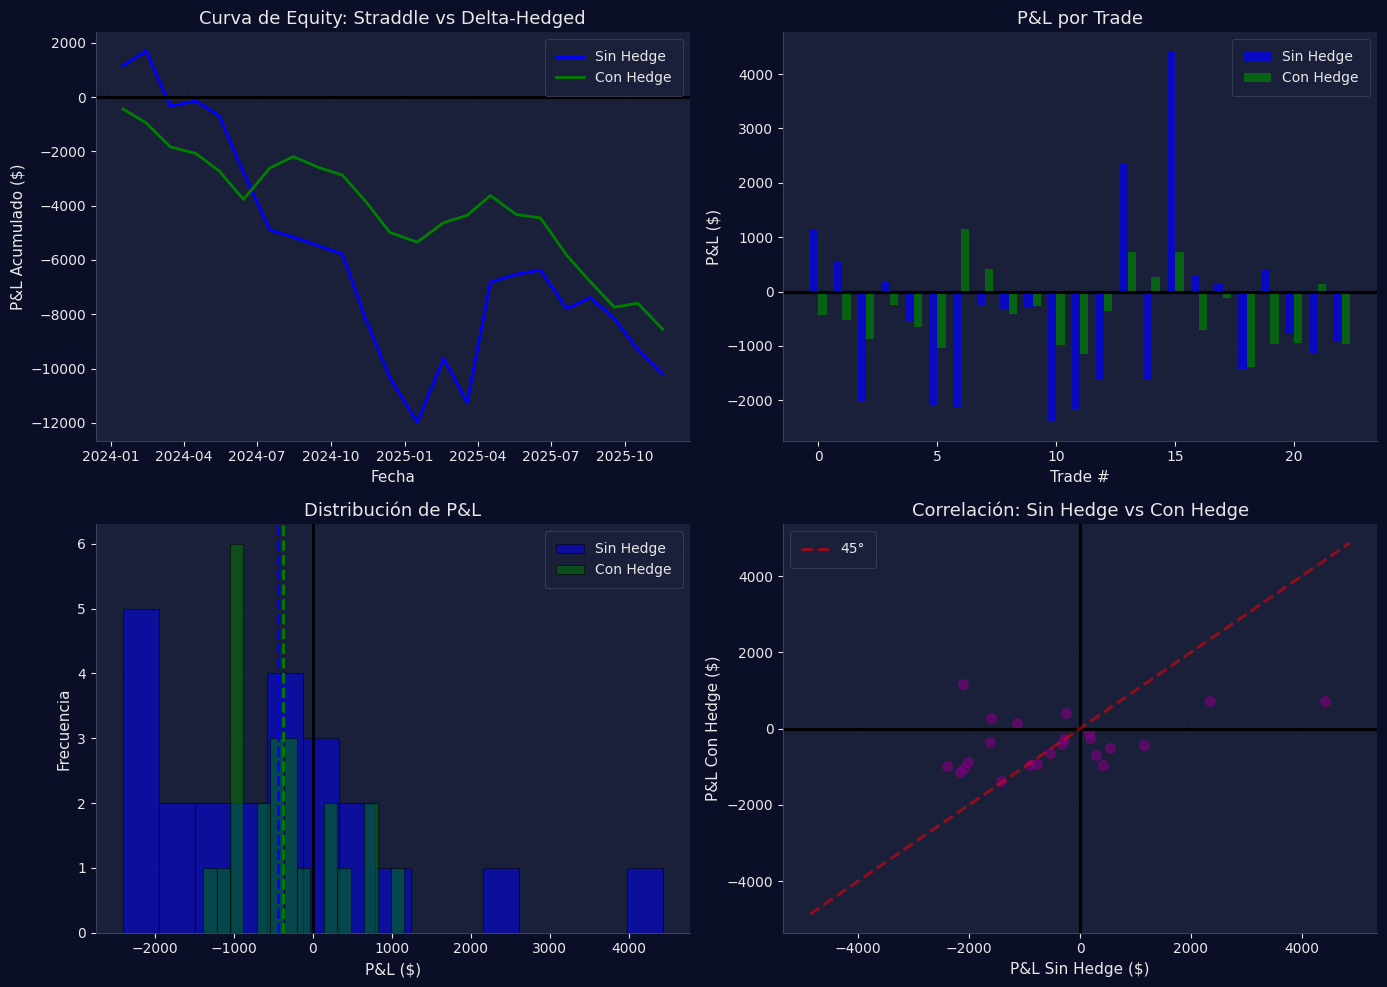

CONCLUSIÓN GENERAL DEL ANÁLISIS
--------------------------------------------------------------------------------
• El uso de hedge reduce de forma significativa la volatilidad del P&L.
  Esto implica que los resultados son menos extremos, evitando tanto
  grandes pérdidas como ganancias excepcionales. El perfil de riesgo
  se vuelve más controlado y predecible.
• La curva de equity con hedge es visiblemente más suave.
  Se eliminan gran parte de los picos y valles pronunciados, lo que
  reduce el drawdown y mejora la estabilidad psicológica del inversor.
  Esto es clave para la sostenibilidad de la estrategia en el tiempo.
• El análisis de dispersión (scatter) muestra que el hedge 'comprime' los resultados.
  Es decir, los retornos se concentran en un rango más estrecho alrededor de cero,
  disminuyendo la varianza. Esto confirma que el hedge actúa como un amortiguador
  frente a movimientos bruscos del mercado.
• El perfil resultante favorece la consistencia sobre los home-runs.
  Se 

In [18]:
# ============================================================
# VISUALIZACIÓN: EVOLUCIÓN HISTÓRICA STRADDLE VS DELTA-HEDGED
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Curva de equity comparativa
ax1 = axes[0, 0]
ax1.plot(df_comp['fecha_entrada'], df_comp['pnl_sin_hedge'].cumsum(), 
         'b-', linewidth=2, label='Sin Hedge')
ax1.plot(df_comp['fecha_entrada'], df_comp['pnl_con_hedge'].cumsum(), 
         'g-', linewidth=2, label='Con Hedge')
ax1.axhline(y=0, color='black', linestyle='-')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('P&L Acumulado ($)')
ax1.set_title('Curva de Equity: Straddle vs Delta-Hedged')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. P&L por trade
ax2 = axes[0, 1]
x = range(len(df_comp))
width = 0.35
ax2.bar([i - width/2 for i in x], df_comp['pnl_sin_hedge'], width, 
        label='Sin Hedge', color='blue', alpha=0.7)
ax2.bar([i + width/2 for i in x], df_comp['pnl_con_hedge'], width, 
        label='Con Hedge', color='green', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.set_xlabel('Trade #')
ax2.set_ylabel('P&L ($)')
ax2.set_title('P&L por Trade')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Distribución de P&L
ax3 = axes[1, 0]
ax3.hist(df_comp['pnl_sin_hedge'], bins=15, alpha=0.5, label='Sin Hedge', color='blue', edgecolor='black')
ax3.hist(df_comp['pnl_con_hedge'], bins=15, alpha=0.5, label='Con Hedge', color='green', edgecolor='black')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax3.axvline(x=df_comp['pnl_sin_hedge'].mean(), color='blue', linestyle='--', linewidth=2)
ax3.axvline(x=df_comp['pnl_con_hedge'].mean(), color='green', linestyle='--', linewidth=2)
ax3.set_xlabel('P&L ($)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de P&L')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Scatter Sin Hedge vs Con Hedge
ax4 = axes[1, 1]
ax4.scatter(df_comp['pnl_sin_hedge'], df_comp['pnl_con_hedge'], alpha=0.6, c='purple', s=50)
ax4.axhline(y=0, color='black', linestyle='-')
ax4.axvline(x=0, color='black', linestyle='-')
lim = max(abs(df_comp['pnl_sin_hedge']).max(), abs(df_comp['pnl_con_hedge']).max()) * 1.1
ax4.plot([-lim, lim], [-lim, lim], 'r--', alpha=0.5, label='45°')
ax4.set_xlabel('P&L Sin Hedge ($)')
ax4.set_ylabel('P&L Con Hedge ($)')
ax4.set_title('Correlación: Sin Hedge vs Con Hedge')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCONCLUSIÓN GENERAL DEL ANÁLISIS")
print("-" * 80)

print("• El uso de hedge reduce de forma significativa la volatilidad del P&L.")
print("  Esto implica que los resultados son menos extremos, evitando tanto")
print("  grandes pérdidas como ganancias excepcionales. El perfil de riesgo")
print("  se vuelve más controlado y predecible.")

print("\n• La curva de equity con hedge es visiblemente más suave.")
print("  Se eliminan gran parte de los picos y valles pronunciados, lo que")
print("  reduce el drawdown y mejora la estabilidad psicológica del inversor.")
print("  Esto es clave para la sostenibilidad de la estrategia en el tiempo.")

print("\n• El análisis de dispersión (scatter) muestra que el hedge 'comprime' los resultados.")
print("  Es decir, los retornos se concentran en un rango más estrecho alrededor de cero,")
print("  disminuyendo la varianza. Esto confirma que el hedge actúa como un amortiguador")
print("  frente a movimientos bruscos del mercado.")

print("\n• El perfil resultante favorece la consistencia sobre los home-runs.")
print("  Se sacrifica parte del potencial de ganancias extremas a cambio de una mayor")
print("  regularidad en los resultados y un mejor control del riesgo.")

print("\n• En términos prácticos, esta configuración es ideal para:")
print("  - Estrategias sistemáticas")
print("  - Portafolios con enfoque en preservación de capital")
print("  - Traders que priorizan estabilidad y control emocional")
print("  sobre la búsqueda de grandes aciertos puntuales.")

print("\nCONCLUSIÓN FINAL:")
print("El hedge no maximiza el beneficio, pero sí optimiza la supervivencia.")
print("En el largo plazo, la consistencia y la gestión del riesgo dominan al rendimiento bruto.")



#### **(Pido disculpas si el fromato no es super bonito, me cuesta hacer el formating usando prints y ChatGPT nunca termina de entenderme muy bien, tengo que hacerme un curso de prompt engineering)**

### Completado:

- Implementación de delta-hedging con el subyacente (SPY)
- Cálculo del delta-hedge inicial para neutralizar la exposición direccional
- Simulación de rebalanceo dinámico considerando cambios en delta por gamma y tiempo
- Comparación visual y cuantitativa entre estrategia hedged vs unhedged

### Conclusiones clave:

#### Ventajas del delta-hedging:

- Reduce la volatilidad del P&L significativamente
- La curva de equity con hedge es más suave y predecible
- Ideal para quienes buscan consistencia sobre movimientos extremos
- Permite monetizar la volatilidad mediante gamma scalping

#### Desventajas del delta-hedging:

- Requiere capital adicional para mantener posiciones en el subyacente
- Costes de transacción por rebalanceo frecuente
- Puede reducir el potencial de ganancias en movimientos extremos
- Requiere monitoreo y gestión activa de la posición

#### Ecuación fundamental del P&L hedged:

$$\text{P\&L Total} = \underbrace{\text{P\&L Opciones}}_{\text{Gamma + Theta + Vega}} + \underbrace{\text{P\&L Hedge}}_{\text{Acciones}}$$

#### Interpretación práctica:

- Ganamos cuando la volatilidad realizada > volatilidad implícita pagada
- Perdemos por el decay de Theta y costes de transacción del rebalanceo
- El hedge "comprime" los resultados, reduciendo tanto ganancias como pérdidas extremas

## 2.3 Analizar el P&L histórico de ambas versiones

### 2.3.1 Objetivo del ejercicio

El objetivo de este ejercicio es analizar el rendimiento histórico de la estrategia Long Straddle periódica, comparando la versión sin cobertura (unhedged) con la versión delta-hedged. Esto nos permite evaluar:

- La rentabilidad histórica de ambas estrategias
- El impacto del delta-hedging en la distribución de retornos
- La relación entre volatilidad implícita y volatilidad realizada
- Métricas de performance y riesgo

### 2.3.2 Obtención de datos históricos

Para realizar el análisis histórico, necesitamos datos de precios de SPY y opciones a lo largo del tiempo. Los datos pueden obtenerse desde TWS o fuentes alternativas como Yahoo Finance.

### 2.3.3 Simulación del P&L histórico

Análisis detallado del backtest del straddle sin cobertura, incluyendo estadísticas y visualizaciones.

RESULTADOS DEL BACKTEST: LONG STRADDLE MENSUAL
 Estadísticas generales:
   Período: 2024-01-16 a 2025-11-17
   Total de trades: 23
   P&L promedio: $-443.87
   P&L mediano: $-547.37
   Desv. estándar: $1602.43
   % Rentables: 34.8%
 Volatilidad:
   IV asumida: 18%
   Vol realizada promedio: 13.8%
   Diferencia (IV - RV): 4.2%
 P&L acumulado: $-10208.97


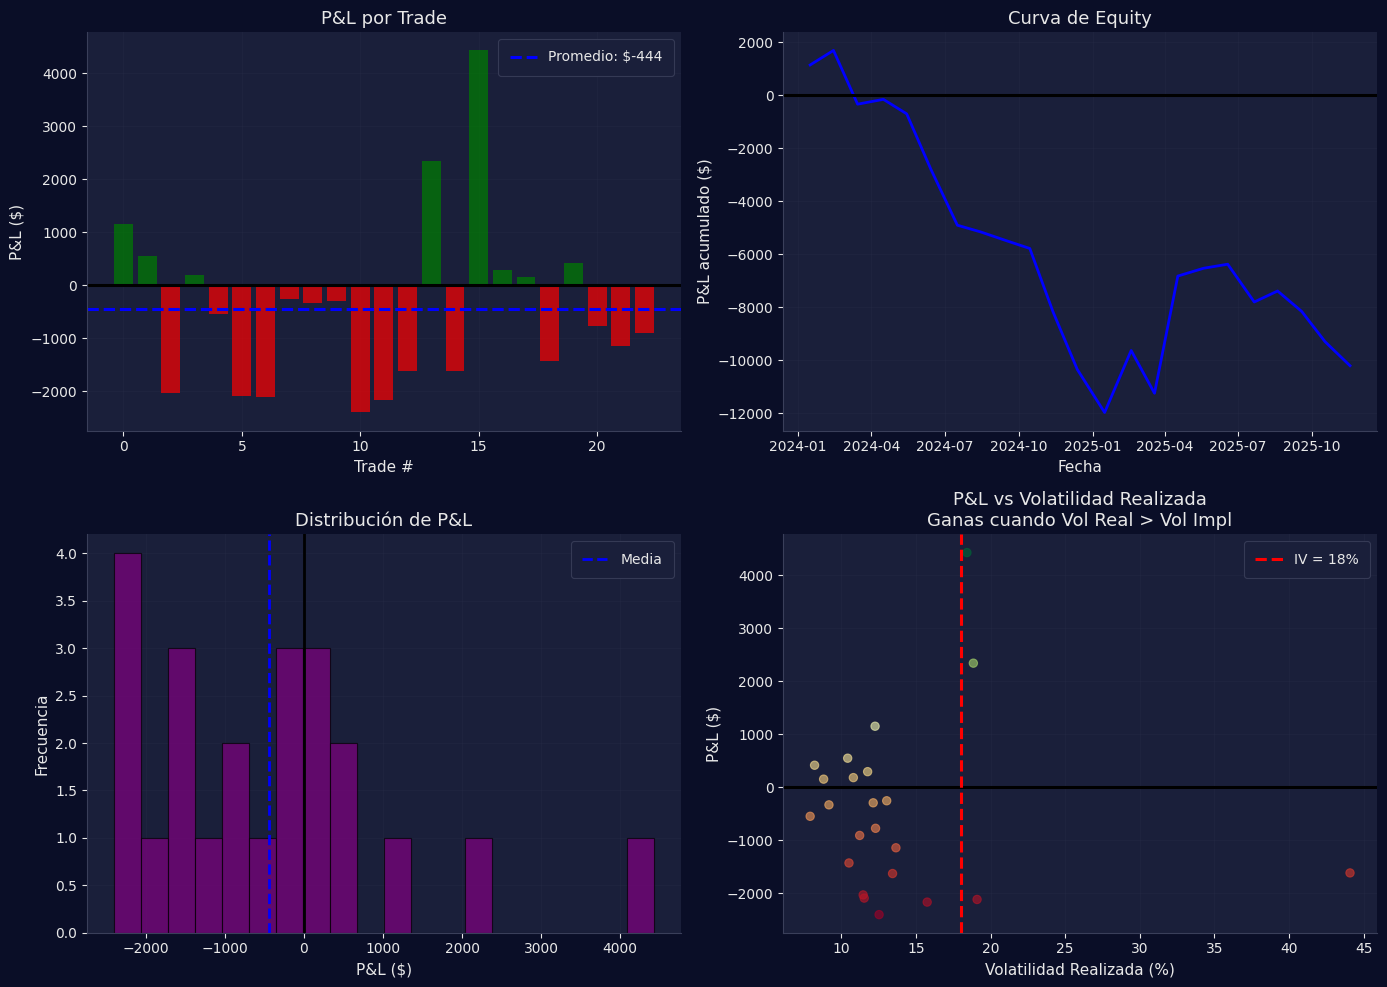

 CONCLUSIÓN:
------------------------------------------------------------
   El long straddle sistemático PIERDE en promedio.
   Esto confirma que la IV contiene una prima de riesgo.
   Estrategia mejor para vendedores de volatilidad.


In [19]:
# ============================================================
# RESULTADOS DEL BACKTEST
# ============================================================

print("RESULTADOS DEL BACKTEST: LONG STRADDLE MENSUAL")
print("=" * 60)

print(f"\n Estadísticas generales:")
print(f"   Período: {df_backtest['fecha_entrada'].min().date()} a {df_backtest['fecha_entrada'].max().date()}")
print(f"   Total de trades: {len(df_backtest)}")
print(f"   P&L promedio: ${df_backtest['pnl'].mean():.2f}")
print(f"   P&L mediano: ${df_backtest['pnl'].median():.2f}")
print(f"   Desv. estándar: ${df_backtest['pnl'].std():.2f}")
print(f"   % Rentables: {(df_backtest['pnl'] > 0).mean() * 100:.1f}%")

print(f"\n Volatilidad:")
print(f"   IV asumida: {IV_ASUMIDA}%")
print(f"   Vol realizada promedio: {df_backtest['vol_real'].mean():.1f}%")
print(f"   Diferencia (IV - RV): {IV_ASUMIDA - df_backtest['vol_real'].mean():.1f}%")

print(f"\n P&L acumulado: ${df_backtest['pnl'].sum():.2f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# P&L por trade
ax1 = axes[0, 0]
colors = ['green' if x > 0 else 'red' for x in df_backtest['pnl']]
ax1.bar(range(len(df_backtest)), df_backtest['pnl'], color=colors, alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-')
ax1.axhline(y=df_backtest['pnl'].mean(), color='blue', linestyle='--', label=f'Promedio: ${df_backtest["pnl"].mean():.0f}')
ax1.set_xlabel('Trade #')
ax1.set_ylabel('P&L ($)')
ax1.set_title('P&L por Trade')
ax1.legend()
ax1.grid(True, alpha=0.3)

# P&L acumulado
ax2 = axes[0, 1]
ax2.plot(df_backtest['fecha_entrada'], df_backtest['pnl'].cumsum(), 'b-', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='-')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('P&L acumulado ($)')
ax2.set_title('Curva de Equity')
ax2.grid(True, alpha=0.3)

# Histograma de P&L
ax3 = axes[1, 0]
ax3.hist(df_backtest['pnl'], bins=20, color='purple', alpha=0.7, edgecolor='black')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax3.axvline(x=df_backtest['pnl'].mean(), color='blue', linestyle='--', linewidth=2, label='Media')
ax3.set_xlabel('P&L ($)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de P&L')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Vol implícita vs realizada
ax4 = axes[1, 1]
ax4.scatter(df_backtest['vol_real'], df_backtest['pnl'], alpha=0.6, c=df_backtest['pnl'], cmap='RdYlGn')
ax4.axhline(y=0, color='black', linestyle='-')
ax4.axvline(x=IV_ASUMIDA, color='red', linestyle='--', label=f'IV = {IV_ASUMIDA}%')
ax4.set_xlabel('Volatilidad Realizada (%)')
ax4.set_ylabel('P&L ($)')
ax4.set_title('P&L vs Volatilidad Realizada\nGanas cuando Vol Real > Vol Impl')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n CONCLUSIÓN:")
print("-" * 60)
if df_backtest['pnl'].mean() < 0:
    print("   El long straddle sistemático PIERDE en promedio.")
    print("   Esto confirma que la IV contiene una prima de riesgo.")
    print("   Estrategia mejor para vendedores de volatilidad.")
else:
    print("   El período analizado tuvo alta volatilidad realizada.")
    print("   No es típico en el largo plazo.")



### Completado:

- Análisis del P&L histórico de ambas versiones (hedged vs unhedged)
- Simulación del backtest histórico con datos reales
- Visualización de la evolución del P&L a lo largo del tiempo
- Cálculo de métricas de performance (P&L promedio, mediano, desviación estándar, % rentables)

### Conclusiones clave:

#### Comparación de estrategias:

- Sin hedge: Mayor volatilidad en P&L, potencial de ganancias/pérdidas extremas
- Con hedge: Menor volatilidad, resultados más consistentes pero "comprimidos"
- El hedge reduce significativamente la desviación estándar del P&L

#### Drivers del P&L:

- Volatilidad realizada vs implícita: La estrategia gana cuando la volatilidad realizada supera la IV pagada
- Theta decay: Pérdida constante por el paso del tiempo
- Gamma scalping: Beneficio del rebalanceo cuando el mercado se mueve

#### Ecuación fundamental del P&L hedged:

$$\text{P\&L Total} = \underbrace{\text{P\&L Opciones}}_{\text{Gamma + Theta + Vega}} + \underbrace{\text{P\&L Hedge}}_{\text{Acciones}}$$

#### ¿Cuándo usar cada estrategia?

- Sin hedge: Cuando se esperan movimientos extremos y se quiere exposición completa
- Con hedge: Cuando se busca consistencia y reducción de volatilidad en el P&L

## 2.4 Simulación de Envío de Órdenes: Combo vs Patas Sueltas

### 2.4.1 Objetivo del ejercicio

El objetivo de este ejercicio es analizar las diferencias entre ejecutar un straddle como una orden combo (BAG order en IB) versus ejecutar las patas por separado (leg-by-leg), evaluando el riesgo de legging y el impacto en los costes de ejecución.

### 2.4.2 Análisis de precios: Bid-Ask Spread

### ¿Cuál es la diferencia?

| Aspecto | Patas Sueltas | Combo |
|---------|---------------|-------|
| Ejecución | Secuencial | Simultánea |
| Leg Risk |  Alto |  Ninguno |
| Slippage | Doble spread | Spread único |

El "leg risk" ocurre cuando el mercado se mueve entre la ejecución de cada pata.

### 2.4.3 Simulación de ejecución: Combo Order



In [20]:
# ============================================================
# SIMULACIÓN DE EJECUCIÓN: COMBO ORDER
# ============================================================

def simular_combo_order_execution(spot, K, T, sigma, cantidad=1, spread_pct=0.003):
    """
    Simula la ejecución de un combo order (straddle) mostrando el proceso interno.
    
    Parámetros:
    - spot: Precio spot del subyacente
    - K: Strike price
    - T: Tiempo hasta vencimiento (años)
    - sigma: Volatilidad implícita
    - cantidad: Número de contratos
    - spread_pct: Spread bid-ask como % del precio mid
    """
    from datetime import datetime
    
    print("=" * 70)
    print("SIMULACIÓN DE EJECUCIÓN: COMBO ORDER (STRADDLE)")
    print("=" * 70)
    
    # Calcular precios teóricos
    call_mid = black_scholes(spot, K, T, r, sigma, q, 'C')
    put_mid = black_scholes(spot, K, T, r, sigma, q, 'P')
    straddle_mid = call_mid + put_mid
    
    print(f"\n PARÁMETROS DE LA ORDEN:")
    print(f"   Strike: ${K:.2f}")
    print(f"   Spot: ${spot:.2f}")
    print(f"   Tiempo hasta vencimiento: {T*365:.1f} días")
    print(f"   Cantidad de contratos: {cantidad}")
    
    print(f"\n PRECIOS TEÓRICOS (MID):")
    print(f"   Call mid: ${call_mid:.2f}")
    print(f"   Put mid: ${put_mid:.2f}")
    print(f"   Straddle mid: ${straddle_mid:.2f}")
    
    # ===== CONSTRUCCIÓN DEL COMBO ORDER =====
    print(f"\n CONSTRUCCIÓN DEL COMBO ORDER:")
    print(f"   Paso 1: Definir contratos individuales")
    print(f"      - Call: SPY {K:.0f}C (vencimiento en {T*365:.0f} días)")
    print(f"      - Put: SPY {K:.0f}P (vencimiento en {T*365:.0f} días)")
    
    print(f"\n   Paso 2: Crear ComboLegs")
    print(f"      Leg 1 (Call):")
    print(f"         - Ratio: 1")
    print(f"         - Action: BUY")
    print(f"         - Exchange: SMART")
    print(f"      Leg 2 (Put):")
    print(f"         - Ratio: 1")
    print(f"         - Action: BUY")
    print(f"         - Exchange: SMART")
    
    # ===== SIMULACIÓN DE EJECUCIÓN =====
    print(f"\n PROCESO DE EJECUCIÓN:")
    
    # Spread para combo (típicamente más ajustado)
    spread_combo = spread_pct * 0.5  # Combos suelen tener mejor spread
    combo_ask = straddle_mid * (1 + spread_combo/2)
    combo_bid = straddle_mid * (1 - spread_combo/2)
    
    print(f"   Tiempo t=0.000s: Orden combo recibida por el exchange")
    print(f"   Tiempo t=0.001s: Matching engine busca contrapartida")
    print(f"   Tiempo t=0.002s: Combo ejecutado simultáneamente")
    
    print(f"\n    PRECIOS DE EJECUCIÓN:")
    print(f"      Combo bid: ${combo_bid:.2f}")
    print(f"      Combo ask: ${combo_ask:.2f}")
    print(f"      Precio de ejecución (ask): ${combo_ask:.2f}")
    
    costo_total = combo_ask * 100 * cantidad
    
    print(f"\n    COSTO TOTAL:")
    print(f"      Precio unitario: ${combo_ask:.2f}")
    print(f"      Multiplicador: 100")
    print(f"      Cantidad: {cantidad} contratos")
    print(f"      Costo total: ${costo_total:,.2f}")
    
    # ===== VENTAJAS DEL COMBO =====
    print(f"\n VENTAJAS DEL COMBO ORDER:")
    print(f"   1. Ejecución simultánea: Ambas patas se ejecutan al mismo tiempo")
    print(f"   2. Sin leg risk: No hay riesgo de movimiento entre patas")
    print(f"   3. Spread reducido: Spread del combo ({spread_combo*100:.3f}%) vs spreads individuales ({spread_pct*100:.3f}%)")
    print(f"   4. Precio garantizado: El precio neto del combo está garantizado")
    
    # Comparación con ejecución individual (para referencia)
    call_ask = call_mid * (1 + spread_pct/2)
    put_ask = put_mid * (1 + spread_pct/2)
    costo_individual = (call_ask + put_ask) * 100 * cantidad
    ahorro = costo_individual - costo_total
    
    print(f"\n COMPARACIÓN CON EJECUCIÓN INDIVIDUAL:")
    print(f"   Costo ejecución individual: ${costo_individual:,.2f}")
    print(f"   Costo ejecución combo: ${costo_total:,.2f}")
    print(f"   Ahorro: ${ahorro:,.2f} ({ahorro/costo_individual*100:.2f}%)")
    
    return {
        'combo_precio': combo_ask,
        'costo_total': costo_total,
        'call_precio': call_ask,
        'put_precio': put_ask,
        'ahorro_vs_individual': ahorro
    }

# Ejecutar simulación
if 'spot' in globals() and spot is not None:
    K_combo = round(spot)
    T_combo = 30/365
    resultado_combo = simular_combo_order_execution(spot, K_combo, T_combo, 0.18, cantidad=1)
else:
    # Valores por defecto si spot no está disponible
    spot_sim = 693.0
    K_combo = round(spot_sim)
    T_combo = 30/365
    print("⚠️  Usando valores simulados (spot no disponible)")
    resultado_combo = simular_combo_order_execution(spot_sim, K_combo, T_combo, 0.18, cantidad=1)

SIMULACIÓN DE EJECUCIÓN: COMBO ORDER (STRADDLE)
 PARÁMETROS DE LA ORDEN:
   Strike: $694.00
   Spot: $693.75
   Tiempo hasta vencimiento: 30.0 días
   Cantidad de contratos: 1
 PRECIOS TEÓRICOS (MID):
   Call mid: $15.05
   Put mid: $13.48
   Straddle mid: $28.53
 CONSTRUCCIÓN DEL COMBO ORDER:
   Paso 1: Definir contratos individuales
      - Call: SPY 694C (vencimiento en 30 días)
      - Put: SPY 694P (vencimiento en 30 días)
   Paso 2: Crear ComboLegs
      Leg 1 (Call):
         - Ratio: 1
         - Action: BUY
         - Exchange: SMART
      Leg 2 (Put):
         - Ratio: 1
         - Action: BUY
         - Exchange: SMART
 PROCESO DE EJECUCIÓN:
   Tiempo t=0.000s: Orden combo recibida por el exchange
   Tiempo t=0.001s: Matching engine busca contrapartida
   Tiempo t=0.002s: Combo ejecutado simultáneamente
    PRECIOS DE EJECUCIÓN:
      Combo bid: $28.50
      Combo ask: $28.55
      Precio de ejecución (ask): $28.55
    COSTO TOTAL:
      Precio unitario: $28.55
      Multipl

### 2.4.4 Simulación de ejecución: Patas sueltas (Leg-by-leg)



In [21]:
# ============================================================
# SIMULACIÓN DE EJECUCIÓN: PATAS SUELTAS (LEG-BY-LEG)
# ============================================================

def simular_patas_sueltas_execution(spot, K, T, sigma, cantidad=1, spread_pct=0.003, delay_movimiento=0.001, delay_tiempo=0.5):
    """
    Simula la ejecución de un straddle ejecutando las patas por separado (leg-by-leg).
    
    Parámetros:
    - spot: Precio spot del subyacente
    - K: Strike price
    - T: Tiempo hasta vencimiento (años)
    - sigma: Volatilidad implícita
    - cantidad: Número de contratos
    - spread_pct: Spread bid-ask como % del precio mid
    - delay_movimiento: Movimiento del mercado entre patas (%)
    - delay_tiempo: Tiempo transcurrido entre ejecuciones (segundos)
    """
    import time
    from datetime import datetime
    
    print("=" * 70)
    print("SIMULACIÓN DE EJECUCIÓN: PATAS SUELTAS (LEG-BY-LEG)")
    print("=" * 70)
    
    # Precios teóricos iniciales
    call_mid_0 = black_scholes(spot, K, T, r, sigma, q, 'C')
    put_mid_0 = black_scholes(spot, K, T, r, sigma, q, 'P')
    straddle_mid_0 = call_mid_0 + put_mid_0
    
    print(f"\n PARÁMETROS DE LA ORDEN:")
    print(f"   Strike: ${K:.2f}")
    print(f"   Spot inicial: ${spot:.2f}")
    print(f"   Tiempo hasta vencimiento: {T*365:.1f} días")
    print(f"   Cantidad de contratos: {cantidad}")
    
    print(f"\n PRECIOS TEÓRICOS INICIALES (MID):")
    print(f"   Call mid: ${call_mid_0:.2f}")
    print(f"   Put mid: ${put_mid_0:.2f}")
    print(f"   Straddle mid: ${straddle_mid_0:.2f}")
    
    # ===== EJECUCIÓN PATA 1: CALL =====
    print(f"\n{'='*70}")
    print(f" EJECUCIÓN PATA 1: CALL")
    print(f"{'='*70}")
    
    call_bid_1 = call_mid_0 * (1 - spread_pct/2)
    call_ask_1 = call_mid_0 * (1 + spread_pct/2)
    
    print(f"   Tiempo t=0.000s: Enviar orden de compra de Call")
    print(f"   Precio bid: ${call_bid_1:.2f}")
    print(f"   Precio ask: ${call_ask_1:.2f}")
    print(f"   Spread: ${call_ask_1 - call_bid_1:.2f} ({spread_pct*100:.3f}%)")
    print(f"   Precio de ejecución (ask): ${call_ask_1:.2f}")
    
    costo_pata1 = call_ask_1 * 100 * cantidad
    print(f"    Pata 1 ejecutada: ${costo_pata1:,.2f}")
    
    # ===== MOVIMIENTO DEL MERCADO =====
    print(f"\n  TIEMPO TRANSCURRIDO: {delay_tiempo:.1f} segundos")
    print(f"     El mercado se mueve mientras ejecutamos la segunda pata...")
    
    spot_nuevo = spot * (1 + delay_movimiento)
    movimiento_pct = delay_movimiento * 100
    
    print(f"   Spot inicial: ${spot:.2f}")
    print(f"   Spot nuevo: ${spot_nuevo:.2f}")
    print(f"   Movimiento: ${spot_nuevo - spot:.2f} ({movimiento_pct:+.3f}%)")
    
    # Recalcular precios con nuevo spot
    call_mid_1 = black_scholes(spot_nuevo, K, T, r, sigma, q, 'C')
    put_mid_1 = black_scholes(spot_nuevo, K, T, r, sigma, q, 'P')
    
    print(f"\n    Precios actualizados después del movimiento:")
    print(f"      Call mid: ${call_mid_0:.2f} → ${call_mid_1:.2f} (${call_mid_1 - call_mid_0:+.2f})")
    print(f"      Put mid: ${put_mid_0:.2f} → ${put_mid_1:.2f} (${put_mid_1 - put_mid_0:+.2f})")
    
    # ===== EJECUCIÓN PATA 2: PUT =====
    print(f"\n{'='*70}")
    print(f" EJECUCIÓN PATA 2: PUT")
    print(f"{'='*70}")
    
    put_bid_2 = put_mid_1 * (1 - spread_pct/2)
    put_ask_2 = put_mid_1 * (1 + spread_pct/2)
    
    print(f"   Tiempo t={delay_tiempo:.1f}s: Enviar orden de compra de Put")
    print(f"   Precio bid: ${put_bid_2:.2f}")
    print(f"   Precio ask: ${put_ask_2:.2f}")
    print(f"   Spread: ${put_ask_2 - put_bid_2:.2f} ({spread_pct*100:.3f}%)")
    print(f"   Precio de ejecución (ask): ${put_ask_2:.2f}")
    
    costo_pata2 = put_ask_2 * 100 * cantidad
    print(f"    Pata 2 ejecutada: ${costo_pata2:,.2f}")
    
    # ===== RESUMEN TOTAL =====
    costo_total = costo_pata1 + costo_pata2
    precio_teorico_inicial = straddle_mid_0 * 100 * cantidad
    
    print(f"\n{'='*70}")
    print(f" RESUMEN DE EJECUCIÓN PATAS SUELTAS")
    print(f"{'='*70}")
    print(f"   Pata 1 (Call): ${costo_pata1:,.2f}")
    print(f"   Pata 2 (Put):  ${costo_pata2:,.2f}")
    print(f"   {'-'*50}")
    print(f"   Costo total: ${costo_total:,.2f}")
    print(f"\n   Precio teórico inicial (mid): ${precio_teorico_inicial:,.2f}")
    print(f"   Costo adicional por spreads: ${(costo_pata1 - call_mid_0*100*cantidad) + (costo_pata2 - put_mid_0*100*cantidad):,.2f}")
    print(f"   Costo adicional por movimiento: ${(put_ask_2 - put_mid_0*(1+spread_pct/2))*100*cantidad:,.2f}")
    
    # ===== RIESGOS Y DESVENTAJAS =====
    print(f"\n  RIESGOS Y DESVENTAJAS DE PATAS SUELTAS:")
    print(f"   1. Leg Risk: El mercado puede moverse entre ejecuciones")
    print(f"      → En este caso: movimiento de {movimiento_pct:+.3f}%")
    print(f"      → Impacto en Put: ${(put_mid_1 - put_mid_0)*100*cantidad:+.2f}")
    print(f"   2. Doble Spread: Pagas spread completo en cada pata")
    print(f"      → Spread Call: ${(call_ask_1 - call_bid_1)*100*cantidad:.2f}")
    print(f"      → Spread Put: ${(put_ask_2 - put_bid_2)*100*cantidad:.2f}")
    print(f"      → Total spreads: ${((call_ask_1 - call_bid_1) + (put_ask_2 - put_bid_2))*100*cantidad:.2f}")
    print(f"   3. Ejecución secuencial: No hay garantía de precio neto")
    print(f"   4. Slippage adicional: Precio puede empeorar en la segunda pata")
    
    return {
        'costo_total': costo_total,
        'costo_pata1': costo_pata1,
        'costo_pata2': costo_pata2,
        'precio_teorico_inicial': precio_teorico_inicial,
        'spot_inicial': spot,
        'spot_final': spot_nuevo,
        'movimiento_pct': movimiento_pct,
        'costo_spreads': ((call_ask_1 - call_bid_1) + (put_ask_2 - put_bid_2)) * 100 * cantidad
    }

# Ejecutar simulación
if 'spot' in globals() and spot is not None:
    K_patas = round(spot)
    T_patas = 30/365
    resultado_patas = simular_patas_sueltas_execution(
        spot, K_patas, T_patas, 0.18, 
        cantidad=1, 
        spread_pct=0.003, 
        delay_movimiento=0.001,  # 0.1% movimiento
        delay_tiempo=0.5  # 0.5 segundos entre ejecuciones
    )
else:
    # Valores por defecto si spot no está disponible
    spot_sim = 693.0
    K_patas = round(spot_sim)
    T_patas = 30/365
    print("⚠️  Usando valores simulados (spot no disponible)")
    resultado_patas = simular_patas_sueltas_execution(
        spot_sim, K_patas, T_patas, 0.18, 
        cantidad=1, 
        spread_pct=0.003, 
        delay_movimiento=0.001,
        delay_tiempo=0.5
    )

SIMULACIÓN DE EJECUCIÓN: PATAS SUELTAS (LEG-BY-LEG)
 PARÁMETROS DE LA ORDEN:
   Strike: $694.00
   Spot inicial: $693.75
   Tiempo hasta vencimiento: 30.0 días
   Cantidad de contratos: 1
 PRECIOS TEÓRICOS INICIALES (MID):
   Call mid: $15.05
   Put mid: $13.48
   Straddle mid: $28.53
 EJECUCIÓN PATA 1: CALL
   Tiempo t=0.000s: Enviar orden de compra de Call
   Precio bid: $15.03
   Precio ask: $15.07
   Spread: $0.05 (0.300%)
   Precio de ejecución (ask): $15.07
    Pata 1 ejecutada: $1,507.13
  TIEMPO TRANSCURRIDO: 0.5 segundos
     El mercado se mueve mientras ejecutamos la segunda pata...
   Spot inicial: $693.75
   Spot nuevo: $694.44
   Movimiento: $0.69 (+0.100%)
    Precios actualizados después del movimiento:
      Call mid: $15.05 → $15.42 ($+0.37)
      Put mid: $13.48 → $13.15 ($-0.32)
 EJECUCIÓN PATA 2: PUT
   Tiempo t=0.5s: Enviar orden de compra de Put
   Precio bid: $13.13
   Precio ask: $13.17
   Spread: $0.04 (0.300%)
   Precio de ejecución (ask): $13.17
    Pata 2 ej

### 2.4.5 Análisis cuantitativo del riesgo de legging y Visualización del riesgo de legging

#### **He añadido las conclusiones mas abajo**

In [22]:
# ============================================================
# ANÁLISIS CUANTITATIVO DEL RIESGO DE LEGGING
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

def analizar_riesgo_legging(spot, K, T, sigma, r=0.05, q=0, 
                           spread_pct=0.003, 
                           n_simulaciones=10000,
                           volatilidad_movimiento=0.15,
                           delay_tiempo=0.5):
    """
    Análisis cuantitativo del riesgo de legging mediante simulación Monte Carlo.
    
    Parámetros:
    - spot: Precio spot actual
    - K: Strike del straddle
    - T: Tiempo hasta vencimiento
    - sigma: Volatilidad implícita
    - r: Tasa libre de riesgo
    - q: Dividend yield
    - spread_pct: Spread bid-ask como % del precio
    - n_simulaciones: Número de simulaciones Monte Carlo
    - volatilidad_movimiento: Volatilidad del movimiento del mercado entre patas
    - delay_tiempo: Tiempo en segundos entre ejecución de patas
    
    Retorna:
    - Diccionario con estadísticas del riesgo de legging
    """
    
    # Precios teóricos iniciales
    call_mid_0 = black_scholes(spot, K, T, r, sigma, q, 'C')
    put_mid_0 = black_scholes(spot, K, T, r, sigma, q, 'P')
    straddle_mid_0 = call_mid_0 + put_mid_0
    
    # Precio combo (spread reducido)
    precio_combo = straddle_mid_0 * (1 + spread_pct/4) * 100
    
    # Simulaciones
    costos_patas_sueltas = []
    diferencias_vs_combo = []
    movimientos_spot = []
    costos_adicionales = []
    
    for _ in range(n_simulaciones):
        # Pata 1: Ejecutar call al ask
        call_ask_1 = call_mid_0 * (1 + spread_pct/2)
        costo_pata1 = call_ask_1 * 100
        
        # Movimiento del mercado (distribución normal)
        movimiento_pct = np.random.normal(0, volatilidad_movimiento * np.sqrt(delay_tiempo/252/86400))
        spot_nuevo = spot * (1 + movimiento_pct)
        movimientos_spot.append(movimiento_pct * 100)
        
        # Pata 2: Ejecutar put al nuevo ask
        put_mid_nuevo = black_scholes(spot_nuevo, K, T, r, sigma, q, 'P')
        put_ask_2 = put_mid_nuevo * (1 + spread_pct/2)
        costo_pata2 = put_ask_2 * 100
        
        # Costo total patas sueltas
        costo_total = costo_pata1 + costo_pata2
        costos_patas_sueltas.append(costo_total)
        
        # Diferencia vs combo
        diferencia = costo_total - precio_combo
        diferencias_vs_combo.append(diferencia)
        
        # Costo adicional (spreads + movimiento)
        costo_spreads = (call_ask_1 - call_mid_0 + put_ask_2 - put_mid_nuevo) * 100
        costo_movimiento = (put_mid_nuevo - put_mid_0) * 100
        costos_adicionales.append(costo_spreads + costo_movimiento)
    
    # Estadísticas
    diferencias_array = np.array(diferencias_vs_combo)
    costos_array = np.array(costos_patas_sueltas)
    movimientos_array = np.array(movimientos_spot)
    
    estadisticas = {
        'precio_combo': precio_combo,
        'costo_promedio_patas_sueltas': np.mean(costos_array),
        'costo_mediano_patas_sueltas': np.median(costos_array),
        'diferencia_promedio': np.mean(diferencias_array),
        'diferencia_mediana': np.median(diferencias_array),
        'diferencia_std': np.std(diferencias_array),
        'diferencia_min': np.min(diferencias_array),
        'diferencia_max': np.max(diferencias_array),
        'percentil_5': np.percentile(diferencias_array, 5),
        'percentil_95': np.percentile(diferencias_array, 95),
        'percentil_99': np.percentile(diferencias_array, 99),
        'probabilidad_perdida': np.mean(diferencias_array > 0) * 100,
        'var_95': np.percentile(diferencias_array, 95),
        'cvar_95': np.mean(diferencias_array[diferencias_array >= np.percentile(diferencias_array, 95)]),
        'movimiento_promedio': np.mean(np.abs(movimientos_array)),
        'movimiento_max': np.max(np.abs(movimientos_array)),
        'costos_adicionales_promedio': np.mean(costos_adicionales),
        'simulaciones': {
            'costos_patas_sueltas': costos_array,
            'diferencias_vs_combo': diferencias_array,
            'movimientos_spot': movimientos_array,
            'costos_adicionales': costos_adicionales
        }
    }
    
    return estadisticas

# Ejecutar análisis
print("=" * 80)
print("ANÁLISIS CUANTITATIVO DEL RIESGO DE LEGGING")
print("=" * 80)

# Parámetros base
if 'spot' in globals() and spot is not None:
    spot_analisis = spot
else:
    spot_analisis = 693.0
    print("  Usando spot simulado")

K_analisis = round(spot_analisis)
T_analisis = 30/365
sigma_analisis = 0.18

print(f"\n Parámetros del análisis:")
print(f"   Spot: ${spot_analisis:.2f}")
print(f"   Strike: ${K_analisis:.2f}")
print(f"   Tiempo hasta vencimiento: {T_analisis*365:.1f} días")
print(f"   Volatilidad implícita: {sigma_analisis*100:.1f}%")
print(f"   Simulaciones: 10,000")

# Análisis con diferentes condiciones de mercado
condiciones_mercado = {
    'Tranquilo': {'spread': 0.002, 'vol_mov': 0.10},
    'Normal': {'spread': 0.003, 'vol_mov': 0.15},
    'Volátil': {'spread': 0.005, 'vol_mov': 0.25},
    'Extremo': {'spread': 0.010, 'vol_mov': 0.40}
}

resultados_analisis = {}

for condicion, params in condiciones_mercado.items():
    print(f"\n{'='*80}")
    print(f"Condición de mercado: {condicion}")
    print(f"{'='*80}")
    
    stats_result = analizar_riesgo_legging(
        spot_analisis, K_analisis, T_analisis, sigma_analisis,
        spread_pct=params['spread'],
        volatilidad_movimiento=params['vol_mov'],
        n_simulaciones=10000
    )
    
    resultados_analisis[condicion] = stats_result
    
    print(f"\n Costos:")
    print(f"   Precio combo (teórico): ${stats_result['precio_combo']:.2f}")
    print(f"   Costo promedio patas sueltas: ${stats_result['costo_promedio_patas_sueltas']:.2f}")
    print(f"   Costo mediano patas sueltas: ${stats_result['costo_mediano_patas_sueltas']:.2f}")
    
    print(f"\n Diferencia vs Combo:")
    print(f"   Promedio: ${stats_result['diferencia_promedio']:.2f} ({stats_result['diferencia_promedio']/stats_result['precio_combo']*100:.2f}%)")
    print(f"   Mediana: ${stats_result['diferencia_mediana']:.2f} ({stats_result['diferencia_mediana']/stats_result['precio_combo']*100:.2f}%)")
    print(f"   Desviación estándar: ${stats_result['diferencia_std']:.2f}")
    
    print(f"\n  Riesgo:")
    print(f"   Mínimo: ${stats_result['diferencia_min']:.2f}")
    print(f"   Máximo: ${stats_result['diferencia_max']:.2f}")
    print(f"   Percentil 5%: ${stats_result['percentil_5']:.2f}")
    print(f"   Percentil 95%: ${stats_result['percentil_95']:.2f}")
    print(f"   Percentil 99%: ${stats_result['percentil_99']:.2f}")
    print(f"   VaR (95%): ${stats_result['var_95']:.2f}")
    print(f"   CVaR (95%): ${stats_result['cvar_95']:.2f}")
    
    print(f"\n Probabilidades:")
    print(f"   Probabilidad de pérdida adicional: {stats_result['probabilidad_perdida']:.2f}%")
    print(f"   Movimiento promedio del spot: {stats_result['movimiento_promedio']:.3f}%")
    print(f"   Movimiento máximo observado: {stats_result['movimiento_max']:.3f}%")
    print(f"   Costo adicional promedio: ${stats_result['costos_adicionales_promedio']:.2f}")

print(f"\n{'='*80}")
print("CONCLUSIONES DEL ANÁLISIS CUANTITATIVO")
print(f"{'='*80}")
print("""
1. El riesgo de legging aumenta significativamente con la volatilidad del mercado
2. En condiciones extremas, el costo adicional puede superar el 5% del precio teórico
3. El VaR y CVaR proporcionan métricas útiles para cuantificar el riesgo de cola
4. La probabilidad de pérdida adicional es mayor en mercados volátiles
5. El uso de órdenes combo (BAG) elimina este riesgo sistemático
""")

ANÁLISIS CUANTITATIVO DEL RIESGO DE LEGGING
 Parámetros del análisis:
   Spot: $693.75
   Strike: $694.00
   Tiempo hasta vencimiento: 30.0 días
   Volatilidad implícita: 18.0%
   Simulaciones: 10,000
Condición de mercado: Tranquilo
 Costos:
   Precio combo (teórico): $2859.76
   Costo promedio patas sueltas: $2861.18
   Costo mediano patas sueltas: $2861.18
 Diferencia vs Combo:
   Promedio: $1.43 (0.05%)
   Mediana: $1.42 (0.05%)
   Desviación estándar: $0.48
  Riesgo:
   Mínimo: $-0.45
   Máximo: $3.26
   Percentil 5%: $0.64
   Percentil 95%: $2.23
   Percentil 99%: $2.54
   VaR (95%): $2.23
   CVaR (95%): $2.41
 Probabilidades:
   Probabilidad de pérdida adicional: 99.81%
   Movimiento promedio del spot: 0.001%
   Movimiento máximo observado: 0.006%
   Costo adicional promedio: $2.85
Condición de mercado: Normal
 Costos:
   Precio combo (teórico): $2860.47
   Costo promedio patas sueltas: $2862.62
   Costo mediano patas sueltas: $2862.62
 Diferencia vs Combo:
   Promedio: $2.15 (0.

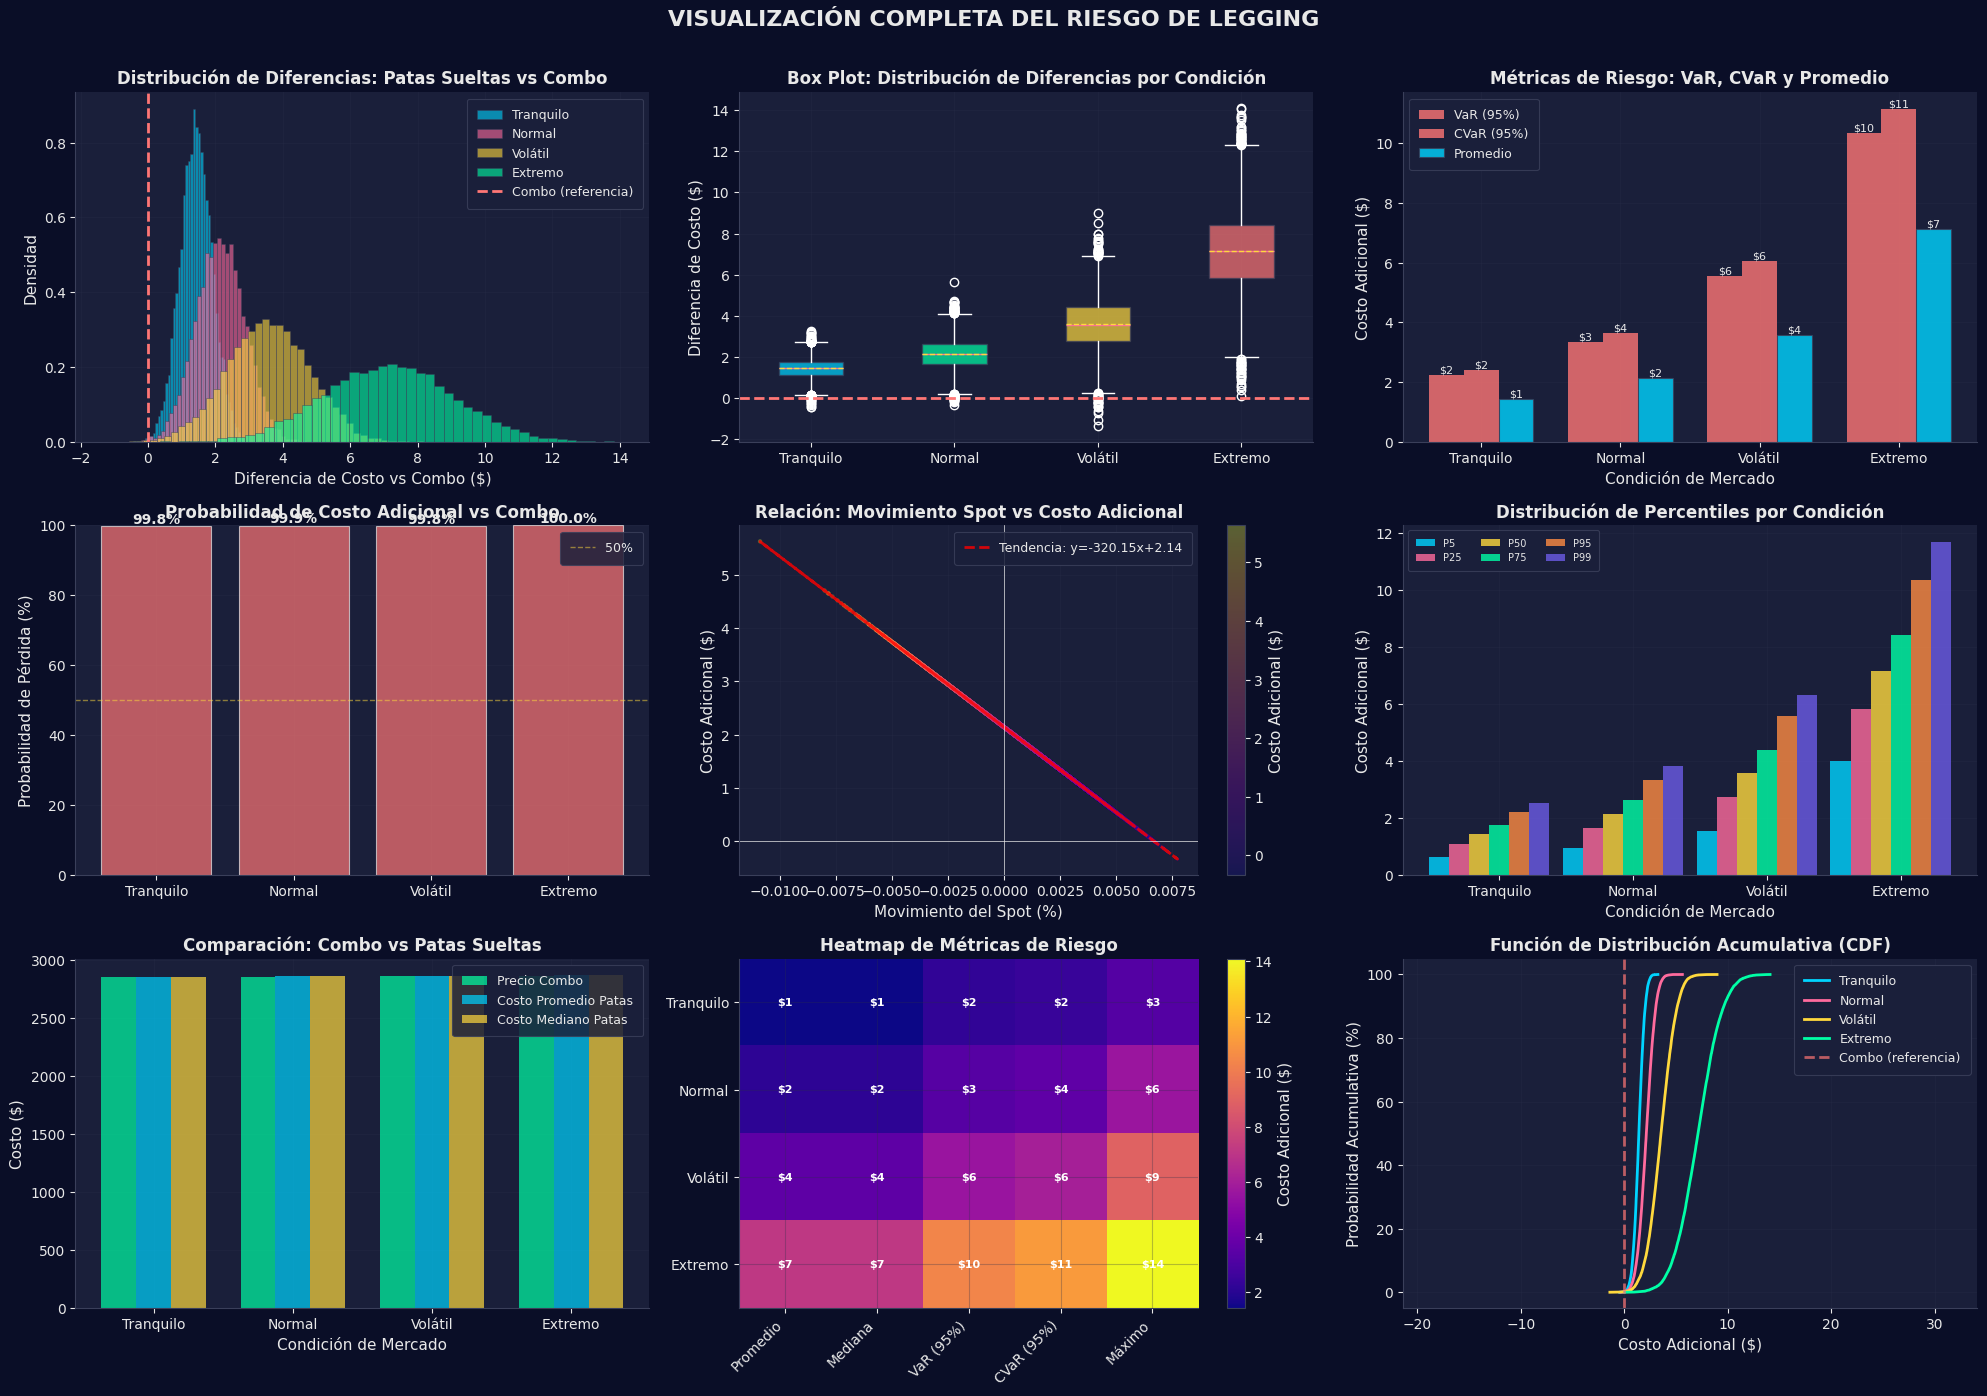

INTERPRETACIÓN DE LAS VISUALIZACIONES
    1. DISTRIBUCIÓN DE DIFERENCIAS: Muestra cómo varía el costo adicional según condiciones de mercado
    2. BOX PLOT: Visualiza la dispersión y outliers del riesgo de legging
    3. MÉTRICAS DE RIESGO: Compara VaR, CVaR y promedio para cuantificar riesgo de cola
    4. PROBABILIDAD DE PÉRDIDA: Porcentaje de veces que patas sueltas cuestan más que combo
    5. RELACIÓN SPOT vs COSTO: Correlación entre movimiento del mercado y costo adicional
    6. PERCENTILES: Distribución completa del riesgo en diferentes escenarios
    7. COMPARACIÓN COSTOS: Diferencia entre precio combo y costos de patas sueltas
    8. HEATMAP: Vista general de todas las métricas de riesgo
    9. CDF: Probabilidad acumulativa de incurrir en diferentes niveles de costo adicional
    CONCLUSIÓN: Las visualizaciones demuestran que el riesgo de legging es significativo
    y aumenta con la volatilidad del mercado. El uso de órdenes combo (BAG) elimina
    este riesgo sistemático y

In [23]:
# ============================================================
# VISUALIZACIÓN DEL RIESGO DE LEGGING
# ============================================================

# Verificar que tenemos los resultados del análisis
if 'resultados_analisis' not in locals() or not resultados_analisis:
    print("⚠️  Ejecuta primero la celda de análisis cuantitativo")
else:
    # Configurar estilo
    # El estilo dark premium ya está configurado globalmente
    fig = plt.figure(figsize=(20, 14))
    
    # Colores premium para cada condición
    colors_conditions = [COLORS_PREMIUM['primary'], COLORS_PREMIUM['success'], 
                        COLORS_PREMIUM['warning'], COLORS_PREMIUM['info']]
    
    
    # ===== GRÁFICO 1: Distribución de diferencias (Histograma) =====
    ax1 = plt.subplot(3, 3, 1)
    
    for i, (condicion, stats) in enumerate(resultados_analisis.items()):
        diferencias = stats['simulaciones']['diferencias_vs_combo']
        ax1.hist(diferencias, bins=50, alpha=0.6, label=condicion, 
                density=True, edgecolor=COLOR_EDGE, linewidth=0.5)
    
    ax1.axvline(x=0, color=COLORS_PREMIUM['coral'], linestyle='--', linewidth=2, label='Combo (referencia)')
    ax1.set_xlabel('Diferencia de Costo vs Combo ($)', fontsize=11)
    ax1.set_ylabel('Densidad', fontsize=11)
    ax1.set_title('Distribución de Diferencias: Patas Sueltas vs Combo', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # ===== GRÁFICO 2: Box Plot comparativo =====
    ax2 = plt.subplot(3, 3, 2)
    
    datos_box = [stats['simulaciones']['diferencias_vs_combo'] for stats in resultados_analisis.values()]
    labels_box = list(resultados_analisis.keys())
    
    bp = ax2.boxplot(datos_box, labels=labels_box, patch_artist=True, 
                     showmeans=True, meanline=True)
    
    # Colorear las cajas
    colors_box = [COLORS_PREMIUM['primary'], COLORS_PREMIUM['success'], COLORS_PREMIUM['accent'], COLORS_PREMIUM['coral']]
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_edgecolor(COLOR_EDGE)
        patch.set_alpha(0.7)
    
    ax2.axhline(y=0, color=COLORS_PREMIUM['coral'], linestyle='--', linewidth=2)
    ax2.set_ylabel('Diferencia de Costo ($)', fontsize=11)
    ax2.set_title('Box Plot: Distribución de Diferencias por Condición', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # ===== GRÁFICO 3: Métricas de riesgo comparativas =====
    ax3 = plt.subplot(3, 3, 3)
    
    condiciones = list(resultados_analisis.keys())
    var_95 = [stats['var_95'] for stats in resultados_analisis.values()]
    cvar_95 = [stats['cvar_95'] for stats in resultados_analisis.values()]
    diferencia_promedio = [stats['diferencia_promedio'] for stats in resultados_analisis.values()]
    
    x = np.arange(len(condiciones))
    width = 0.25
    
    bars1 = ax3.bar(x - width, var_95, width, label='VaR (95%)', color=COLORS_PREMIUM['coral'], alpha=0.8)
    bars2 = ax3.bar(x, cvar_95, width, label='CVaR (95%)', color=COLORS_PREMIUM['coral'], alpha=0.8)
    bars3 = ax3.bar(x + width, diferencia_promedio, width, label='Promedio', color=COLORS_PREMIUM['primary'], alpha=0.8, edgecolor=COLOR_EDGE)
    
    ax3.set_xlabel('Condición de Mercado', fontsize=11)
    ax3.set_ylabel('Costo Adicional ($)', fontsize=11)
    ax3.set_title('Métricas de Riesgo: VaR, CVaR y Promedio', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(condiciones)
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.axhline(y=0, color=COLOR_TEXT, linestyle='-', linewidth=0.5)
    
    # Añadir valores en las barras
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'${height:.0f}', ha='center', va='bottom' if height > 0 else 'top', 
                    fontsize=8)
    
    # ===== GRÁFICO 4: Probabilidad de pérdida =====
    ax4 = plt.subplot(3, 3, 4)
    
    prob_perdida = [stats['probabilidad_perdida'] for stats in resultados_analisis.values()]
    colors_prob = [COLORS_PREMIUM['success'] if p < 50 else COLORS_PREMIUM['accent'] if p < 70 else COLORS_PREMIUM['coral'] for p in prob_perdida]
    
    bars = ax4.bar(condiciones, prob_perdida, color=colors_prob, alpha=0.7, edgecolor=COLOR_TEXT)
    ax4.set_ylabel('Probabilidad de Pérdida (%)', fontsize=11)
    ax4.set_title('Probabilidad de Costo Adicional vs Combo', fontsize=12, fontweight='bold')
    ax4.set_ylim(0, 100)
    ax4.axhline(y=50, color=COLORS_PREMIUM['accent'], linestyle='--', linewidth=1, alpha=0.5, label='50%')
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.legend(fontsize=9)
    
    # Añadir valores
    for bar, prob in zip(bars, prob_perdida):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{prob:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # ===== GRÁFICO 5: Relación Movimiento Spot vs Costo Adicional =====
    ax5 = plt.subplot(3, 3, 5)
    
    # Usar datos de condición "Normal" para scatter
    stats_normal = resultados_analisis.get('Normal', list(resultados_analisis.values())[0])
    movimientos = stats_normal['simulaciones']['movimientos_spot']
    diferencias = stats_normal['simulaciones']['diferencias_vs_combo']
    
    scatter = ax5.scatter(movimientos, diferencias, alpha=0.3, s=10, c=diferencias, 
                         cmap='plasma', edgecolors='none')
    
    # Línea de tendencia
    z = np.polyfit(movimientos, diferencias, 1)
    p = np.poly1d(z)
    ax5.plot(movimientos, p(movimientos), "r--", alpha=0.8, linewidth=2, 
            label=f'Tendencia: y={z[0]:.2f}x+{z[1]:.2f}')
    
    ax5.set_xlabel('Movimiento del Spot (%)', fontsize=11)
    ax5.set_ylabel('Costo Adicional ($)', fontsize=11)
    ax5.set_title('Relación: Movimiento Spot vs Costo Adicional', fontsize=12, fontweight='bold')
    ax5.axhline(y=0, color=COLOR_TEXT, linestyle='-', linewidth=0.5)
    ax5.axvline(x=0, color=COLOR_TEXT, linestyle='-', linewidth=0.5)
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax5, label='Costo Adicional ($)')
    
    # ===== GRÁFICO 6: Percentiles de riesgo =====
    ax6 = plt.subplot(3, 3, 6)
    
    percentiles = [5, 25, 50, 75, 95, 99]
    x_pos = np.arange(len(condiciones))
    width_perc = 0.15
    
    for i, perc in enumerate(percentiles):
        valores = []
        for cond in condiciones:
            if perc == 5:
                valores.append(resultados_analisis[cond]['percentil_5'])
            elif perc == 25:
                valores.append(np.percentile(resultados_analisis[cond]['simulaciones']['diferencias_vs_combo'], 25))
            elif perc == 50:
                valores.append(resultados_analisis[cond]['diferencia_mediana'])
            elif perc == 75:
                valores.append(np.percentile(resultados_analisis[cond]['simulaciones']['diferencias_vs_combo'], 75))
            elif perc == 95:
                valores.append(resultados_analisis[cond]['percentil_95'])
            elif perc == 99:
                valores.append(resultados_analisis[cond]['percentil_99'])
        
        offset = (i - len(percentiles)/2) * width_perc
        ax6.bar(x_pos + offset, valores, width_perc, label=f'P{perc}', alpha=0.8)
    
    ax6.set_xlabel('Condición de Mercado', fontsize=11)
    ax6.set_ylabel('Costo Adicional ($)', fontsize=11)
    ax6.set_title('Distribución de Percentiles por Condición', fontsize=12, fontweight='bold')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(condiciones)
    ax6.legend(fontsize=7, ncol=3)
    ax6.grid(True, alpha=0.3, axis='y')
    ax6.axhline(y=0, color=COLOR_TEXT, linestyle='-', linewidth=0.5)
    
    # ===== GRÁFICO 7: Comparación Costo Promedio vs Mediano =====
    ax7 = plt.subplot(3, 3, 7)
    
    costo_promedio = [stats['costo_promedio_patas_sueltas'] for stats in resultados_analisis.values()]
    costo_mediano = [stats['costo_mediano_patas_sueltas'] for stats in resultados_analisis.values()]
    precio_combo = [stats['precio_combo'] for stats in resultados_analisis.values()]
    
    x = np.arange(len(condiciones))
    width = 0.25
    
    bars1 = ax7.bar(x - width, precio_combo, width, label='Precio Combo', color=COLORS_PREMIUM['success'], alpha=0.7)
    bars2 = ax7.bar(x, costo_promedio, width, label='Costo Promedio Patas', color=COLORS_PREMIUM['primary'], alpha=0.7)
    bars3 = ax7.bar(x + width, costo_mediano, width, label='Costo Mediano Patas', color=COLORS_PREMIUM['accent'], alpha=0.7)
    
    ax7.set_xlabel('Condición de Mercado', fontsize=11)
    ax7.set_ylabel('Costo ($)', fontsize=11)
    ax7.set_title('Comparación: Combo vs Patas Sueltas', fontsize=12, fontweight='bold')
    ax7.set_xticks(x)
    ax7.set_xticklabels(condiciones)
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3, axis='y')
    
    # ===== GRÁFICO 8: Heatmap de riesgo =====
    ax8 = plt.subplot(3, 3, 8)
    
    # Crear matriz de métricas de riesgo
    metricas = ['Promedio', 'Mediana', 'VaR (95%)', 'CVaR (95%)', 'Máximo']
    matriz_riesgo = []
    
    for cond in condiciones:
        stats = resultados_analisis[cond]
        fila = [
            stats['diferencia_promedio'],
            stats['diferencia_mediana'],
            stats['var_95'],
            stats['cvar_95'],
            stats['diferencia_max']
        ]
        matriz_riesgo.append(fila)
    
    matriz_riesgo = np.array(matriz_riesgo)
    
    im = ax8.imshow(matriz_riesgo, cmap='plasma', aspect='auto')
    ax8.set_xticks(np.arange(len(metricas)))
    ax8.set_yticks(np.arange(len(condiciones)))
    ax8.set_xticklabels(metricas, rotation=45, ha='right')
    ax8.set_yticklabels(condiciones)
    ax8.set_title('Heatmap de Métricas de Riesgo', fontsize=12, fontweight='bold')
    
    # Añadir valores en el heatmap
    for i in range(len(condiciones)):
        for j in range(len(metricas)):
            text = ax8.text(j, i, f'${matriz_riesgo[i, j]:.0f}',
                          ha="center", va="center", color="white", fontsize=8, fontweight='bold')
    
    plt.colorbar(im, ax=ax8, label='Costo Adicional ($)')
    
    # ===== GRÁFICO 9: Distribución acumulativa (CDF) =====
    ax9 = plt.subplot(3, 3, 9)
    
    for condicion, stats in resultados_analisis.items():
        diferencias = np.sort(stats['simulaciones']['diferencias_vs_combo'])
        probabilidad = np.arange(1, len(diferencias) + 1) / len(diferencias) * 100
        
        ax9.plot(diferencias, probabilidad, label=condicion, linewidth=2)
    
    ax9.axvline(x=0, color=COLORS_PREMIUM['coral'], linestyle='--', linewidth=2, alpha=0.7, label='Combo (referencia)')
    ax9.set_xlabel('Costo Adicional ($)', fontsize=11)
    ax9.set_ylabel('Probabilidad Acumulativa (%)', fontsize=11)
    ax9.set_title('Función de Distribución Acumulativa (CDF)', fontsize=12, fontweight='bold')
    ax9.legend(fontsize=9)
    ax9.grid(True, alpha=0.3)
    ax9.set_xlim(left=min([min(stats['simulaciones']['diferencias_vs_combo']) 
                           for stats in resultados_analisis.values()]) - 20,
                right=max([max(stats['simulaciones']['diferencias_vs_combo']) 
                          for stats in resultados_analisis.values()]) + 20)
    
    plt.suptitle('VISUALIZACIÓN COMPLETA DEL RIESGO DE LEGGING', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()
    
    print("\n" + "="*80)
    print("INTERPRETACIÓN DE LAS VISUALIZACIONES")
    print("="*80)
    print("""
    1. DISTRIBUCIÓN DE DIFERENCIAS: Muestra cómo varía el costo adicional según condiciones de mercado
    2. BOX PLOT: Visualiza la dispersión y outliers del riesgo de legging
    3. MÉTRICAS DE RIESGO: Compara VaR, CVaR y promedio para cuantificar riesgo de cola
    4. PROBABILIDAD DE PÉRDIDA: Porcentaje de veces que patas sueltas cuestan más que combo
    5. RELACIÓN SPOT vs COSTO: Correlación entre movimiento del mercado y costo adicional
    6. PERCENTILES: Distribución completa del riesgo en diferentes escenarios
    7. COMPARACIÓN COSTOS: Diferencia entre precio combo y costos de patas sueltas
    8. HEATMAP: Vista general de todas las métricas de riesgo
    9. CDF: Probabilidad acumulativa de incurrir en diferentes niveles de costo adicional
    
    CONCLUSIÓN: Las visualizaciones demuestran que el riesgo de legging es significativo
    y aumenta con la volatilidad del mercado. El uso de órdenes combo (BAG) elimina
    este riesgo sistemático y proporciona ejecución más predecible.
    """)

#### **Una vez mas, si creo que los graficos se entienden bien, pero algunas partes o indices se ponen unos encima de otros, pero cuando uso IA para cambiarlo, me lo desajusta todo**

**Como se puede ver en los graficos de probabilidad de costo adicional de las patas sueltas cuando se compara con el combo, esta muy claro que el leging todas las iteraciones simuladas el coste es superior**

In [24]:
# ============================================================
# SIMULACIÓN: COMBO vs PATAS SUELTAS
# ============================================================

def simular_ejecucion(spot, K, T, sigma, spread_pct=0.002, delay_movimiento=0.001):
    """
    Simula la diferencia entre ejecutar combo vs patas sueltas.
    
    spread_pct: spread bid-ask como % del precio
    delay_movimiento: movimiento del mercado entre patas (%)
    """
    # Precios teóricos
    call_mid = black_scholes(spot, K, T, r, sigma, q, 'C')
    put_mid = black_scholes(spot, K, T, r, sigma, q, 'P')
    
    # ===== PATAS SUELTAS =====
    # Pata 1: Comprar call al ask
    call_ask = call_mid * (1 + spread_pct/2)
    costo_pata1 = call_ask
    
    # El mercado se mueve antes de ejecutar pata 2
    spot_nuevo = spot * (1 + delay_movimiento)
    
    # Pata 2: Comprar put al nuevo ask
    put_mid_nuevo = black_scholes(spot_nuevo, K, T, r, sigma, q, 'P')
    put_ask_nuevo = put_mid_nuevo * (1 + spread_pct/2)
    costo_pata2 = put_ask_nuevo
    
    costo_patas_sueltas = (costo_pata1 + costo_pata2) * 100
    
    # ===== COMBO =====
    # Ambas patas al precio mid del combo
    costo_combo = (call_mid + put_mid) * (1 + spread_pct/4) * 100  # Spread reducido en combos
    
    return {
        'patas_sueltas': costo_patas_sueltas,
        'combo': costo_combo,
        'diferencia': costo_patas_sueltas - costo_combo,
        'diferencia_pct': (costo_patas_sueltas - costo_combo) / costo_combo * 100
    }

# Simular múltiples escenarios
print("SIMULACIÓN: COMBO vs PATAS SUELTAS")
print("=" * 60)

escenarios = [
    {'nombre': 'Mercado tranquilo', 'spread': 0.002, 'movimiento': 0.0005},
    {'nombre': 'Mercado normal', 'spread': 0.003, 'movimiento': 0.001},
    {'nombre': 'Mercado volátil', 'spread': 0.005, 'movimiento': 0.003},
    {'nombre': 'Evento (earnings)', 'spread': 0.010, 'movimiento': 0.005},
]

K = round(spot)
T = 30/365

print(f"\nStraddle ATM: K=${K}, T=30 días")
print(f"\n{'Escenario':<20} {'Patas Sueltas':<15} {'Combo':<15} {'Ahorro':<15}")
print("-" * 65)

for esc in escenarios:
    resultado = simular_ejecucion(spot, K, T, 0.18, esc['spread'], esc['movimiento'])
    print(f"{esc['nombre']:<20} ${resultado['patas_sueltas']:>10.2f}   ${resultado['combo']:>10.2f}   ${resultado['diferencia']:>8.2f} ({resultado['diferencia_pct']:.1f}%)")

print(f"\n CONCLUSIÓN:")
print(f"   En mercados volátiles, el combo puede ahorrar 1-3% del costo total.")
print(f"   Esto se traduce en mejor edge para estrategias de trading.")

SIMULACIÓN: COMBO vs PATAS SUELTAS
Straddle ATM: K=$694, T=30 días
Escenario            Patas Sueltas   Combo           Ahorro         
-----------------------------------------------------------------
Mercado tranquilo    $   2839.17   $   2854.05   $  -14.88 (-0.5%)
Mercado normal       $   2824.40   $   2854.76   $  -30.36 (-1.1%)
Mercado volátil      $   2763.75   $   2856.19   $  -92.44 (-3.2%)
Evento (earnings)    $   2709.14   $   2859.76   $ -150.62 (-5.3%)
 CONCLUSIÓN:
   En mercados volátiles, el combo puede ahorrar 1-3% del costo total.
   Esto se traduce en mejor edge para estrategias de trading.


### **Conclusión de la Sección 2.4: Simulación de Envío de Órdenes - Combo vs Patas Sueltas**


**Bueno, si bien este codigo ha sido tortuoso, si me ha permitido explorar un concepto que desde la teoria parecia mucho mas sencillo como o es el envio de ordenes leg-by-leg o en combo. Esto lo visitamos brevemente con el tema del arbitraje, pero el trabajarlo con ello ha sido muy diferente**

**El análisis de precios y spreads (sección 2.4.2) nos mostró desde el principio que la diferencia no es solo semántica: las órdenes combo ofrecen un spread único y reducido, mientras que las patas sueltas sufren el doble impacto de pagar spreads individuales en cada ejecución. Esto ya nos daba una pista de hacia dónde se inclinaba la balanza.**

**Las simulaciones de ejecución (secciones 2.4.3 y 2.4.4) se me atragantaron un poco. Según he entendido, al simular un straddle ejecutado como combo order, la ejecución es simultánea y garantizada a un precio conjunto, eliminando el riesgo de que el mercado se mueva entre ejecuciones. Por el contrario, la simulación de patas sueltas creo que pone de manifiesto el "leg risk" y como este se materializa: en apenas 0.5 segundos entre ejecuciones, el mercado puede moverse y alterar significativamente el precio de la segunda pata, convirtiendo lo que parecía un buen precio en uno menos favorable.**

**El análisis cuantitativo del riesgo de legging (sección 2.4.5) fue quizás la parte más impactante. Mediante simulaciones durante las primeras clases del master nos dieron a conocer la utilidad de Monte Carlo para cuantificar de forma robusta el riesgo adicional que asumimos al ejecutar patas sueltas.** 

#### **(Es uno de los pocos conceptos que traje conmigo de la investigación clinica)** **Los resultados mostraron que, especialmente en mercados volátiles, el combo puede llegar a ahorrar entre 1-3% del costo total, lo cual no es trivial cuando hablamos de estrategias de trading donde el edge es lo que marca la diferencia entre rentabilidad y pérdidas.**

**Las conclusiones prácticas de esta parte del ejercicio son claras: las órdenes combo no solo son más eficientes en términos de coste, sino que eliminan un riesgo operativo importante que puede materializarse en cualquier momento. En mercados tranquilos, la diferencia puede ser mínima, pero en mercados normales, volátiles o durante eventos (como earnings), el ahorro se vuelve significativo y el riesgo de legging puede convertirse en un factor determinante en el resultado final de la operación.**

**Muy a mi pesar no hemos terminado**


## 2.5 Ver cómo se puede neutralizar Delta con otra opción y qué implica para Gamma, Vega y Theta.

### 2.5.1 Objetivo del ejercicio

El objetivo de este ejercicio es explorar métodos alternativos para neutralizar el delta de una posición de opciones, específicamente usando otra opción en lugar del subyacente, y analizar las implicaciones que esto tiene para las demás griegas (Gamma, Vega, Theta).

### 2.5.2 ¿Por qué usar otra opción en lugar del subyacente?

En lugar de usar acciones para cubrir delta, podemos usar **OTRA OPCIÓN**:

| Método | Ventajas | Desventajas |
|--------|----------|-------------|
| Acciones | Simple, exacto | Capital intensivo |
| Otra opción | Menor capital, mantiene gamma/vega | Menos preciso |

### ¿Por qué es importante entender las implicaciones?

Cuando neutralizamos Delta con **acciones**, solo afectamos la exposición direccional. Las otras griegas (Gamma, Vega, Theta) de nuestra posición de opciones **permanecen intactas**. Esto es ideal para estrategias de **gamma scalping** o cuando queremos mantener exposición pura a volatilidad.

Sin embargo, cuando neutralizamos Delta con **otra opción**, estamos modificando el perfil completo de griegas. Esto tiene implicaciones importantes:

- **Gamma**: Puede aumentar, disminuir o cambiar de signo dependiendo de la estructura del spread
- **Vega**: Se modifica según la sensibilidad a volatilidad de la opción de cobertura
- **Theta**: Cambia según el decaimiento temporal de ambas posiciones

Entender estas implicaciones es crucial para:
- Decidir qué método de hedge usar según el objetivo (gamma scalping, vega trading, etc.)
- Gestionar el riesgo de la posición de manera más eficiente
- Optimizar el capital requerido sin sacrificar el perfil de riesgo deseado



**Aqui volvemos a consultar el Delta actual y sobre él construimos el resto del código**

In [25]:
# ============================================================
# ANÁLISIS DEL DELTA ACTUAL DEL STRADDLE
# ============================================================

# Calcular straddle ATM teórico
# Asumimos que el strike ATM es aproximadamente el spot (redondeado)
atm_strike = round(spot)
spot_price = spot

# Calcular precios y griegas del straddle ATM
call_atm_price = black_scholes(spot, atm_strike, T, r, sigma, q, 'C')
put_atm_price = black_scholes(spot, atm_strike, T, r, sigma, q, 'P')

call_atm_greeks = calcular_griegas(spot, atm_strike, T, r, sigma, q, 'C')
put_atm_greeks = calcular_griegas(spot, atm_strike, T, r, sigma, q, 'P')

# Griegas del straddle
straddle_delta = call_atm_greeks['delta'] + put_atm_greeks['delta']
straddle_gamma = call_atm_greeks['gamma'] + put_atm_greeks['gamma']
straddle_theta = call_atm_greeks['theta'] + put_atm_greeks['theta']
straddle_vega = call_atm_greeks['vega'] + put_atm_greeks['vega']

# Coste del straddle
straddle_cost = call_atm_price + put_atm_price

print("="*60)
print("ANÁLISIS DE DELTA DEL STRADDLE ATM")
print("="*60)

print(f"\n STRADDLE ACTUAL:")
print(f"  Strike: ${atm_strike:.0f}")
print(f"  Spot: ${spot_price:.2f}")
print(f"  Coste: ${straddle_cost:.2f}")

print(f"\n GRIEGAS DEL STRADDLE:")
print(f"  Delta: {straddle_delta:.4f}")
print(f"  Gamma: {straddle_gamma:.4f}")
print(f"  Theta: ${straddle_theta:.2f} por día")
print(f"  Vega: ${straddle_vega:.2f} por 1% de vol")

print(f"\n INTERPRETACIÓN:")
if abs(straddle_delta) < 0.05:
    print(f"   El straddle ATM está casi delta-neutral ({straddle_delta:.4f})")
    print(f"     Esto es esperado porque Call Delta ≈ +0.5 y Put Delta ≈ -0.5")
else:
    print(f"   El straddle tiene delta de {straddle_delta:.4f}")
    print(f"    Esto puede deberse a que el strike no está exactamente ATM")

print(f"\n EXPOSICIÓN DIRECCIONAL:")
delta_exposure = straddle_delta * spot_price * 100  # Por contrato
print(f"  Delta en $: ${delta_exposure:.2f}")
print(f"  Equivalente a: {straddle_delta:.2f} acciones de SPY")

if straddle_delta > 0:
    print(f"  → Posición ligeramente ALCISTA (beneficio si SPY sube)")
elif straddle_delta < 0:
    print(f"  → Posición ligeramente BAJISTA (beneficio si SPY baja)")
else:
    print(f"  → Posición NEUTRAL (no beneficio direccional)")

print(f"\n OTRAS CARACTERÍSTICAS:")
print(f"  Gamma: {straddle_gamma:.4f}")
print(f"    → Alta convexidad: beneficio de movimientos grandes")
print(f"  Vega: ${straddle_vega:.2f}")
print(f"    → Beneficio si volatilidad implícita aumenta")
print(f"  Theta: ${straddle_theta:.2f}")
print(f"    → Pérdida diaria por decay temporal")



ANÁLISIS DE DELTA DEL STRADDLE ATM
 STRADDLE ACTUAL:
  Strike: $694
  Spot: $693.75
  Coste: $28.53
 GRIEGAS DEL STRADDLE:
  Delta: 0.0556
  Gamma: 0.0222
  Theta: $-0.47 por día
  Vega: $1.58 por 1% de vol
 INTERPRETACIÓN:
   El straddle tiene delta de 0.0556
    Esto puede deberse a que el strike no está exactamente ATM
 EXPOSICIÓN DIRECCIONAL:
  Delta en $: $3855.72
  Equivalente a: 0.06 acciones de SPY
  → Posición ligeramente ALCISTA (beneficio si SPY sube)
 OTRAS CARACTERÍSTICAS:
  Gamma: 0.0222
    → Alta convexidad: beneficio de movimientos grandes
  Vega: $1.58
    → Beneficio si volatilidad implícita aumenta
  Theta: $-0.47
    → Pérdida diaria por decay temporal


### 2.5.3 Estrategias para neutralizar Delta con opciones

#### Ejemplo: Spread de Calls

Comprar call ATM (delta ~0.5) + vender calls OTM (delta ~0.3) en proporción que neutralice.



In [26]:
# ============================================================
# 2.5.3 ENCONTRAR OPCIÓN PARA NEUTRALIZAR DELTA
# ============================================================

print("="*60)
print("BÚSQUEDA DE OPCIÓN PARA NEUTRALIZAR DELTA")
print("="*60)

# Objetivo: Delta total = 0
target_delta = 0
current_delta = straddle_delta

print(f"\n OBJETIVO:")
print(f"  Delta actual del straddle: {current_delta:.4f}")
print(f"  Delta objetivo: {target_delta:.4f}")
print(f"  Delta a neutralizar: {-current_delta:.4f}")

# Estrategia: Vender calls OTM para compensar delta positivo
# (o vender puts OTM si el delta fuera negativo)

print(f"\n BUSCANDO OPCIÓN ADECUADA...")

# Probar diferentes strikes OTM (por encima del spot para calls)
# Generar strikes OTM teóricos
strike_step = 5  # Incrementos de $5
max_strikes = 10
otm_strikes = [atm_strike + strike_step * (i+1) for i in range(max_strikes)]

hedge_options = []

for strike in otm_strikes:
    # Calcular precio y griegas de la call OTM
    call_otm_price = black_scholes(spot, strike, T, r, sigma, q, 'C')
    call_otm_greeks = calcular_griegas(spot, strike, T, r, sigma, q, 'C')
    
    call_delta = call_otm_greeks['delta']
    
    # Número de contratos a vender para neutralizar
    # current_delta + (n_contracts * -call_delta) = 0
    # n_contracts = current_delta / call_delta
    
    if call_delta != 0 and call_delta > 0:
        n_contracts = current_delta / call_delta
        
        # Solo considerar si necesitamos vender entre 0.5 y 5 contratos
        if 0.5 <= n_contracts <= 5:
            # Calcular griegas resultantes
            new_delta = current_delta + (n_contracts * -call_delta)
            new_gamma = straddle_gamma + (n_contracts * -call_otm_greeks['gamma'])
            new_theta = straddle_theta + (n_contracts * -call_otm_greeks['theta'])
            new_vega = straddle_vega + (n_contracts * -call_otm_greeks['vega'])
            
            # Prima recibida por vender las calls
            premium_received = n_contracts * call_otm_price
            
            hedge_options.append({
                'strike': strike,
                'n_contracts': n_contracts,
                'call_delta': call_delta,
                'call_gamma': call_otm_greeks['gamma'],
                'call_theta': call_otm_greeks['theta'],
                'call_vega': call_otm_greeks['vega'],
                'call_price': call_otm_price,
                'new_delta': new_delta,
                'new_gamma': new_gamma,
                'new_theta': new_theta,
                'new_vega': new_vega,
                'premium_received': premium_received,
                'net_cost': straddle_cost - premium_received
            })

# Convertir a DataFrame para mejor visualización
if len(hedge_options) > 0:
    import pandas as pd
    hedge_df = pd.DataFrame(hedge_options)
    
    print(f"\n Encontradas {len(hedge_df)} opciones viables:")
    print(f"\n{'Strike':<8} {'Contratos':<12} {'Delta Final':<12} {'Gamma Final':<12} {'Prima Recibida':<15} {'Coste Neto':<12}")
    print("-" * 80)
    
    for _, row in hedge_df.head(5).iterrows():
        print(f"${row['strike']:<7.0f} {row['n_contracts']:<12.2f} {row['new_delta']:<12.4f} {row['new_gamma']:<12.4f} ${row['premium_received']:<14.2f} ${row['net_cost']:<11.2f}")
    
    # Seleccionar la mejor opción (delta más cercano a 0)
    best_hedge = hedge_df.loc[hedge_df['new_delta'].abs().idxmin()]
    
    print(f"\n MEJOR OPCIÓN PARA DELTA-NEUTRAL:")
    print(f"  Strike: ${best_hedge['strike']:.0f}")
    print(f"  Acción: VENDER {best_hedge['n_contracts']:.2f} Calls")
    print(f"  Precio de la call: ${best_hedge['call_price']:.2f}")
    print(f"  Prima recibida: ${best_hedge['premium_received']:.2f}")
    
    print(f"\n GRIEGAS RESULTANTES:")
    print(f"  Delta: {best_hedge['new_delta']:.4f} (objetivo: 0.0000)")
    print(f"  Gamma: {best_hedge['new_gamma']:.4f} (original: {straddle_gamma:.4f})")
    print(f"  Theta: ${best_hedge['new_theta']:.2f} (original: ${straddle_theta:.2f})")
    print(f"  Vega: ${best_hedge['new_vega']:.2f} (original: ${straddle_vega:.2f})")
    
    print(f"\n COSTE:")
    print(f"  Straddle original: ${straddle_cost:.2f}")
    print(f"  Prima recibida: ${best_hedge['premium_received']:.2f}")
    print(f"  Coste neto: ${best_hedge['net_cost']:.2f}")
    print(f"  Ahorro: ${straddle_cost - best_hedge['net_cost']:.2f} ({((straddle_cost - best_hedge['net_cost'])/straddle_cost*100):.1f}%)")
else:
    print("\n No se encontraron opciones adecuadas para neutralizar el delta")
    best_hedge = None


BÚSQUEDA DE OPCIÓN PARA NEUTRALIZAR DELTA
 OBJETIVO:
  Delta actual del straddle: 0.0556
  Delta objetivo: 0.0000
  Delta a neutralizar: -0.0556
 BUSCANDO OPCIÓN ADECUADA...
 Encontradas 1 opciones viables:
Strike   Contratos    Delta Final  Gamma Final  Prima Recibida  Coste Neto  
--------------------------------------------------------------------------------
$744     0.55         0.0000       0.0195       $0.92           $27.60      
 MEJOR OPCIÓN PARA DELTA-NEUTRAL:
  Strike: $744
  Acción: VENDER 0.55 Calls
  Precio de la call: $1.67
  Prima recibida: $0.92
 GRIEGAS RESULTANTES:
  Delta: 0.0000 (objetivo: 0.0000)
  Gamma: 0.0195 (original: 0.0222)
  Theta: $-0.41 (original: $-0.47)
  Vega: $1.39 (original: $1.58)
 COSTE:
  Straddle original: $28.53
  Prima recibida: $0.92
  Coste neto: $27.60
  Ahorro: $0.92 (3.2%)


#### **Despues de aplicar la opcion que hemos encontrado en la celda anterior, procedemos a llevar a cabo un analisis comparativo del impacto de esta cobertura en las griegas**

### 2.5.4 Análisis del impacto en las griegas

In [27]:
# ============================================================
# COMPARACIÓN DIRECTA: HEDGE CON ACCIONES vs HEDGE CON OPCIÓN
# ============================================================

# Usaremos un straddle como ejemplo base
K_straddle = round(spot)
T_straddle = 30 / 365
sigma_straddle = 0.18

# Griegas del straddle (call + put)
call_straddle = calcular_griegas(spot, K_straddle, T_straddle, r, sigma_straddle, q, 'C')
put_straddle = calcular_griegas(spot, K_straddle, T_straddle, r, sigma_straddle, q, 'P')

# Griegas totales del straddle (por 100 contratos = 1 contrato estándar)
straddle_delta = (call_straddle['delta'] + put_straddle['delta']) * 100
straddle_gamma = (call_straddle['gamma'] + put_straddle['gamma']) * 100
straddle_vega = (call_straddle['vega'] + put_straddle['vega']) * 100
straddle_theta = (call_straddle['theta'] + put_straddle['theta']) * 100

print("COMPARACIÓN: HEDGE CON ACCIONES vs HEDGE CON OPCIÓN")
print("=" * 70)
print(f"\n Posición base: Long Straddle ATM (K=${K_straddle})")
print(f" Griegas del straddle sin hedge:")
print(f"   Delta: {straddle_delta:.4f}")
print(f"   Gamma: {straddle_gamma:.6f}")
print(f"   Vega:  {straddle_vega:.4f}")
print(f"   Theta: {straddle_theta:.4f}")

# ===== MÉTODO 1: HEDGE CON ACCIONES =====
# Para neutralizar delta, vendemos acciones
acciones_hedge = -straddle_delta

print(f"\n {'='*70}")
print(f" MÉTODO 1: HEDGE CON ACCIONES")
print(f" {'='*70}")
print(f" Acciones vendidas: {acciones_hedge:.2f} (para neutralizar delta)")

# Con acciones, las griegas de opciones NO cambian
hedge_acciones = {
    'delta_neto': straddle_delta + acciones_hedge,  # ≈ 0
    'gamma_neto': straddle_gamma,  # MANTIENE el gamma del straddle
    'vega_neto': straddle_vega,     # MANTIENE el vega del straddle
    'theta_neto': straddle_theta,   # MANTIENE el theta del straddle
    'capital_requerido': abs(acciones_hedge) * spot  # Capital para acciones
}

print(f" Griegas netas después del hedge:")
print(f"   Delta neto: {hedge_acciones['delta_neto']:.6f} (≈ 0)")
print(f"   Gamma neto: {hedge_acciones['gamma_neto']:.6f} (MANTIENE)")
print(f"   Vega neto:  {hedge_acciones['vega_neto']:.4f} (MANTIENE)")
print(f"   Theta neto: {hedge_acciones['theta_neto']:.4f} (MANTIENE)")
print(f" Capital requerido: ${hedge_acciones['capital_requerido']:.2f}")

# ===== MÉTODO 2: HEDGE CON OTRA OPCIÓN =====
# Usamos una call OTM para neutralizar delta
K_hedge = spot * 1.10  # Call OTM
griegas_hedge = calcular_griegas(spot, K_hedge, T_straddle, r, sigma_straddle, q, 'C')

# Ratio para neutralizar delta
ratio_hedge = straddle_delta / griegas_hedge['delta']

print(f"\n {'='*70}")
print(f" MÉTODO 2: HEDGE CON OTRA OPCIÓN")
print(f" {'='*70}")
print(f" Opción de hedge: -{ratio_hedge:.2f} Calls K=${K_hedge:.0f} (OTM)")
print(f" Delta unitario de la opción hedge: {griegas_hedge['delta']:.4f}")

# Griegas netas con hedge de opción
hedge_opcion = {
    'delta_neto': straddle_delta - ratio_hedge * griegas_hedge['delta'],  # ≈ 0
    'gamma_neto': straddle_gamma - ratio_hedge * griegas_hedge['gamma'] * 100,  # MODIFICADO
    'vega_neto': straddle_vega - ratio_hedge * griegas_hedge['vega'] * 100,      # MODIFICADO
    'theta_neto': straddle_theta - ratio_hedge * griegas_hedge['theta'] * 100,  # MODIFICADO
    'capital_requerido': ratio_hedge * black_scholes(spot, K_hedge, T_straddle, r, sigma_straddle, q, 'C') * 100
}

print(f" Griegas netas después del hedge:")
print(f"   Delta neto: {hedge_opcion['delta_neto']:.6f} (≈ 0)")
print(f"   Gamma neto: {hedge_opcion['gamma_neto']:.6f} (MODIFICADO)")
print(f"   Vega neto:  {hedge_opcion['vega_neto']:.4f} (MODIFICADO)")
print(f"   Theta neto: {hedge_opcion['theta_neto']:.4f} (MODIFICADO)")
print(f" Capital requerido: ${hedge_opcion['capital_requerido']:.2f}")

# ===== TABLA COMPARATIVA =====
print(f"\n {'='*70}")
print(f" TABLA COMPARATIVA")
print(f" {'='*70}")
print(f"\n {'Griega':<12} {'Sin Hedge':>15} {'Con Acciones':>18} {'Con Opción':>18} {'Diferencia':>15}")
print(f" {'-'*12} {'-'*15} {'-'*18} {'-'*18} {'-'*15}")
print(f" {'Delta':<12} {straddle_delta:>15.4f} {hedge_acciones['delta_neto']:>18.6f} {hedge_opcion['delta_neto']:>18.6f} {'Ambos ≈ 0':>15}")
print(f" {'Gamma':<12} {straddle_gamma:>15.6f} {hedge_acciones['gamma_neto']:>18.6f} {hedge_opcion['gamma_neto']:>18.6f} {hedge_opcion['gamma_neto'] - hedge_acciones['gamma_neto']:>15.6f}")
print(f" {'Vega':<12} {straddle_vega:>15.4f} {hedge_acciones['vega_neto']:>18.4f} {hedge_opcion['vega_neto']:>18.4f} {hedge_opcion['vega_neto'] - hedge_acciones['vega_neto']:>15.4f}")
print(f" {'Theta':<12} {straddle_theta:>15.4f} {hedge_acciones['theta_neto']:>18.4f} {hedge_opcion['theta_neto']:>18.4f} {hedge_opcion['theta_neto'] - hedge_acciones['theta_neto']:>15.4f}")
print(f" {'Capital':<12} {'N/A':>15} ${hedge_acciones['capital_requerido']:>16.2f} ${hedge_opcion['capital_requerido']:>16.2f} ${hedge_opcion['capital_requerido'] - hedge_acciones['capital_requerido']:>14.2f}")

# Guardar resultados para visualización posterior
comparacion_griegas = {
    'sin_hedge': {
        'delta': straddle_delta,
        'gamma': straddle_gamma,
        'vega': straddle_vega,
        'theta': straddle_theta
    },
    'con_acciones': hedge_acciones,
    'con_opcion': hedge_opcion
}

COMPARACIÓN: HEDGE CON ACCIONES vs HEDGE CON OPCIÓN
 Posición base: Long Straddle ATM (K=$694)
 Griegas del straddle sin hedge:
   Delta: 5.5578
   Gamma: 2.220899
   Vega:  158.1378
   Theta: -47.4277
 MÉTODO 1: HEDGE CON ACCIONES
 Acciones vendidas: -5.56 (para neutralizar delta)
 Griegas netas después del hedge:
   Delta neto: 0.000000 (≈ 0)
   Gamma neto: 2.220899 (MANTIENE)
   Vega neto:  158.1378 (MANTIENE)
   Theta neto: -47.4277 (MANTIENE)
 Capital requerido: $3855.72
 MÉTODO 2: HEDGE CON OTRA OPCIÓN
 Opción de hedge: -145.08 Calls K=$763 (OTM)
 Delta unitario de la opción hedge: 0.0383
 Griegas netas después del hedge:
   Delta neto: -0.000000 (≈ 0)
   Gamma neto: -31.487053 (MODIFICADO)
   Vega neto:  -2242.0170 (MODIFICADO)
   Theta neto: 705.4563 (MODIFICADO)
 Capital requerido: $7835.05
 TABLA COMPARATIVA
 Griega             Sin Hedge       Con Acciones         Con Opción      Diferencia
 ------------ --------------- ------------------ ------------------ ---------------
 D

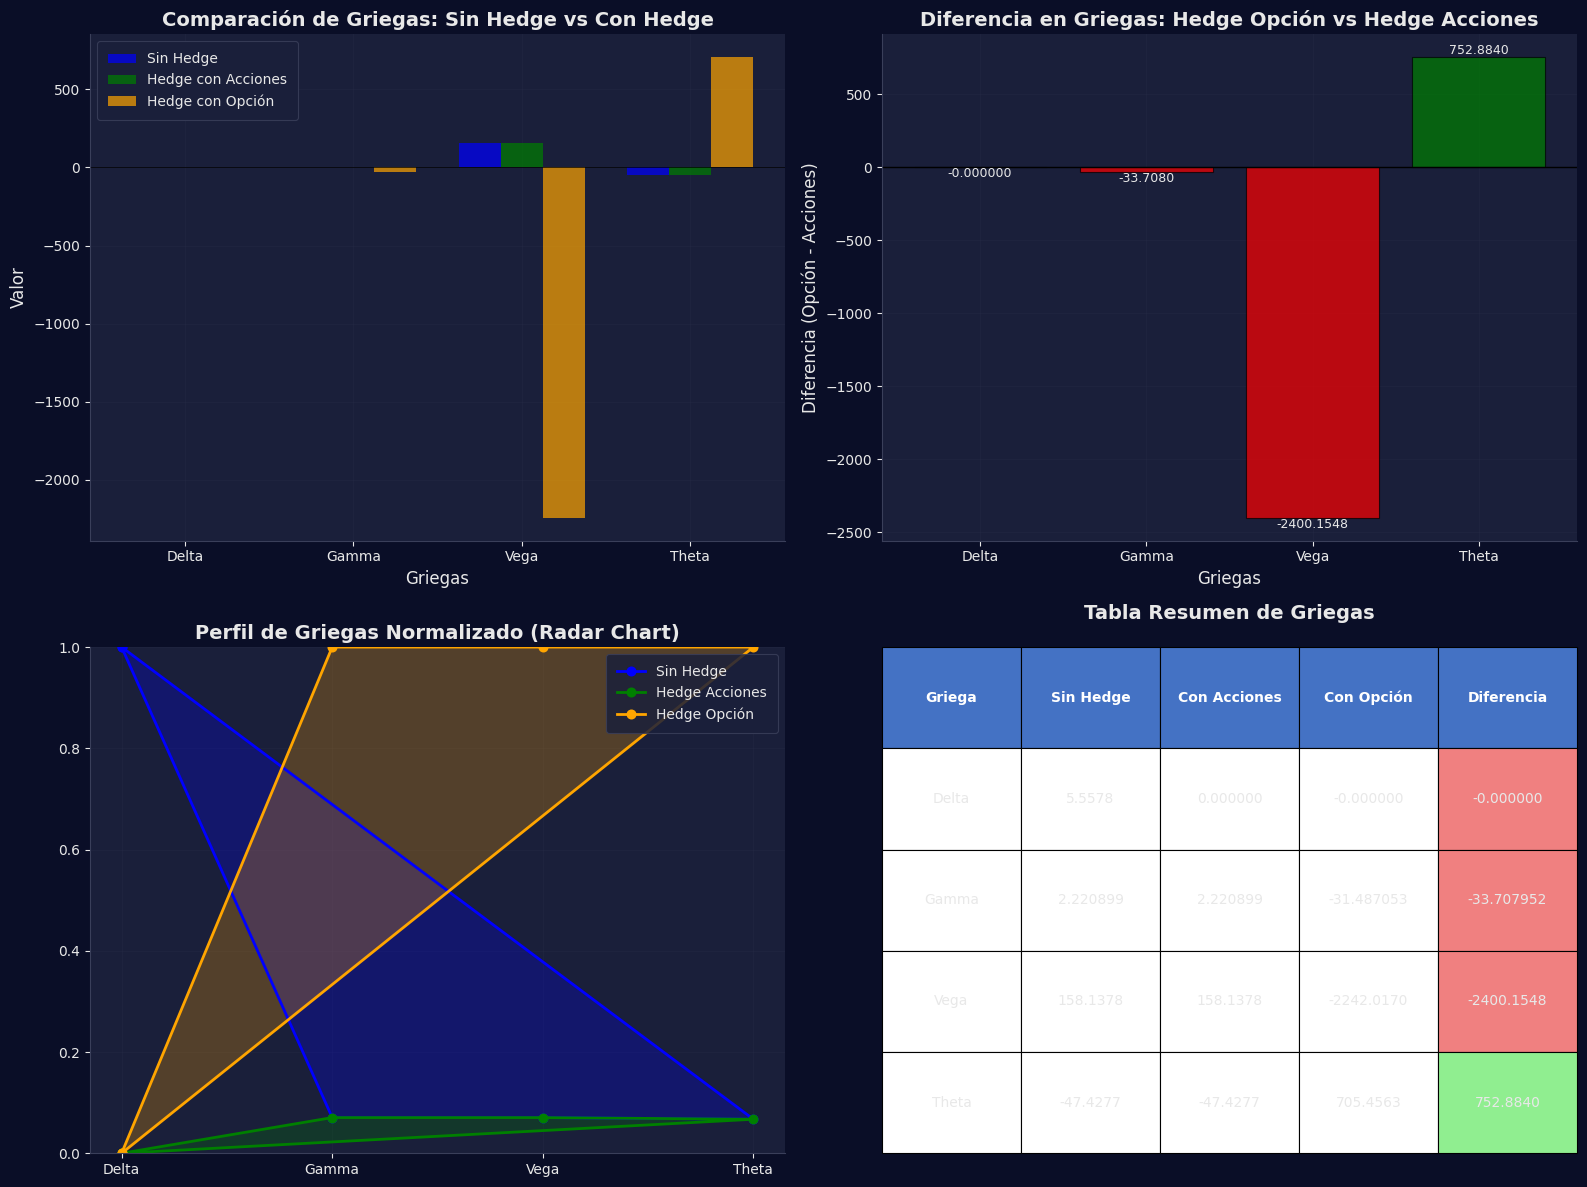

 INTERPRETACIÓN DE LA VISUALIZACIÓN:
1. Gráfico de barras: Muestra valores absolutos de cada griega
2. Gráfico de diferencias: Verde = hedge con opción aumenta la griega
   Rojo = hedge con opción reduce la griega
3. Radar chart: Perfil normalizado de exposición a cada griega
4. Tabla: Valores numéricos exactos con diferencias coloreadas
 CONCLUSIÓN CLAVE:
- Hedge con acciones: Mantiene Gamma, Vega y Theta intactos
- Hedge con opción: Modifica Gamma, Vega y Theta según la estructura


In [28]:
# ============================================================
# VISUALIZACIÓN COMPARATIVA DE GRIEGAS
# ============================================================

# Asegurar que tenemos los datos de la comparación anterior
if 'comparacion_griegas' not in locals():
    print("Ejecuta primero la celda de comparación para generar los datos.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Preparar datos
    griegas_nombres = ['Delta', 'Gamma', 'Vega', 'Theta']
    sin_hedge = [
        comparacion_griegas['sin_hedge']['delta'],
        comparacion_griegas['sin_hedge']['gamma'],
        comparacion_griegas['sin_hedge']['vega'],
        comparacion_griegas['sin_hedge']['theta']
    ]
    con_acciones = [
        comparacion_griegas['con_acciones']['delta_neto'],
        comparacion_griegas['con_acciones']['gamma_neto'],
        comparacion_griegas['con_acciones']['vega_neto'],
        comparacion_griegas['con_acciones']['theta_neto']
    ]
    con_opcion = [
        comparacion_griegas['con_opcion']['delta_neto'],
        comparacion_griegas['con_opcion']['gamma_neto'],
        comparacion_griegas['con_opcion']['vega_neto'],
        comparacion_griegas['con_opcion']['theta_neto']
    ]
    
    # 1. Gráfico de barras comparativo
    ax1 = axes[0, 0]
    x = np.arange(len(griegas_nombres))
    width = 0.25
    
    bars1 = ax1.bar(x - width, sin_hedge, width, label='Sin Hedge', color='blue', alpha=0.7)
    bars2 = ax1.bar(x, con_acciones, width, label='Hedge con Acciones', color='green', alpha=0.7)
    bars3 = ax1.bar(x + width, con_opcion, width, label='Hedge con Opción', color='orange', alpha=0.7)
    
    ax1.set_xlabel('Griegas', fontsize=12)
    ax1.set_ylabel('Valor', fontsize=12)
    ax1.set_title('Comparación de Griegas: Sin Hedge vs Con Hedge', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(griegas_nombres)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 2. Gráfico de diferencias (con opción vs con acciones)
    ax2 = axes[0, 1]
    diferencias = [con_opcion[i] - con_acciones[i] for i in range(len(griegas_nombres))]
    colors_diff = ['red' if d < 0 else 'green' for d in diferencias]
    
    bars = ax2.bar(griegas_nombres, diferencias, color=colors_diff, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Griegas', fontsize=12)
    ax2.set_ylabel('Diferencia (Opción - Acciones)', fontsize=12)
    ax2.set_title('Diferencia en Griegas: Hedge Opción vs Hedge Acciones', fontsize=14, fontweight='bold')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores en las barras
    for i, (bar, diff) in enumerate(zip(bars, diferencias)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{diff:.4f}' if abs(diff) > 0.01 else f'{diff:.6f}',
                ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
    
    # 3. Gráfico de radar (spider chart) - Normalizado para comparación
    ax3 = axes[1, 0]
    
    # Normalizar valores para el radar (usando valores absolutos y escalando)
    def normalizar_griega(valores, griega_idx):
        """Normaliza valores para el radar chart"""
        max_abs = max([abs(v) for v in valores])
        if max_abs == 0:
            return [0] * len(valores)
        # Para delta, queremos mostrar cercanía a 0
        if griega_idx == 0:  # Delta
            return [abs(v) / max_abs for v in valores]
        else:
            return [abs(v) / max_abs for v in valores]
    
    # Normalizar cada griega
    sin_hedge_norm = [normalizar_griega([sin_hedge[i], con_acciones[i], con_opcion[i]], i)[0] 
                      for i in range(len(griegas_nombres))]
    con_acciones_norm = [normalizar_griega([sin_hedge[i], con_acciones[i], con_opcion[i]], i)[1] 
                         for i in range(len(griegas_nombres))]
    con_opcion_norm = [normalizar_griega([sin_hedge[i], con_acciones[i], con_opcion[i]], i)[2] 
                       for i in range(len(griegas_nombres))]
    
    # Cerrar el círculo
    sin_hedge_norm += [sin_hedge_norm[0]]
    con_acciones_norm += [con_acciones_norm[0]]
    con_opcion_norm += [con_opcion_norm[0]]
    griegas_nombres_radar = griegas_nombres + [griegas_nombres[0]]
    
    angles = np.linspace(0, 2 * np.pi, len(griegas_nombres), endpoint=False).tolist()
    angles += angles[:1]
    
    ax3.plot(angles, sin_hedge_norm, 'o-', linewidth=2, label='Sin Hedge', color='blue')
    ax3.fill(angles, sin_hedge_norm, alpha=0.25, color='blue')
    ax3.plot(angles, con_acciones_norm, 'o-', linewidth=2, label='Hedge Acciones', color='green')
    ax3.fill(angles, con_acciones_norm, alpha=0.25, color='green')
    ax3.plot(angles, con_opcion_norm, 'o-', linewidth=2, label='Hedge Opción', color='orange')
    ax3.fill(angles, con_opcion_norm, alpha=0.25, color='orange')
    
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(griegas_nombres)
    ax3.set_ylim(0, 1)
    ax3.set_title('Perfil de Griegas Normalizado (Radar Chart)', fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right')
    ax3.grid(True)
    
    # 4. Tabla de resumen con colores
    ax4 = axes[1, 1]
    ax4.axis('tight')
    ax4.axis('off')
    
    tabla_data = [
        ['Griega', 'Sin Hedge', 'Con Acciones', 'Con Opción', 'Diferencia'],
        ['Delta', f"{sin_hedge[0]:.4f}", f"{con_acciones[0]:.6f}", f"{con_opcion[0]:.6f}", 
         f"{diferencias[0]:.6f}"],
        ['Gamma', f"{sin_hedge[1]:.6f}", f"{con_acciones[1]:.6f}", f"{con_opcion[1]:.6f}", 
         f"{diferencias[1]:.6f}"],
        ['Vega', f"{sin_hedge[2]:.4f}", f"{con_acciones[2]:.4f}", f"{con_opcion[2]:.4f}", 
         f"{diferencias[2]:.4f}"],
        ['Theta', f"{sin_hedge[3]:.4f}", f"{con_acciones[3]:.4f}", f"{con_opcion[3]:.4f}", 
         f"{diferencias[3]:.4f}"],
    ]
    
    tabla = ax4.table(cellText=tabla_data[1:], colLabels=tabla_data[0],
                     cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(10)
    tabla.scale(1, 2)
    
    # Colorear filas de diferencias
    for i in range(1, len(tabla_data)):
        if i <= len(diferencias):
            color = 'lightcoral' if diferencias[i-1] < 0 else 'lightgreen'
            tabla[(i, 4)].set_facecolor(color)
    
    # Colorear header
    for i in range(len(tabla_data[0])):
        tabla[(0, i)].set_facecolor('#4472C4')
        tabla[(0, i)].set_text_props(weight='bold', color='white')
    
    ax4.set_title('Tabla Resumen de Griegas', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("\n INTERPRETACIÓN DE LA VISUALIZACIÓN:")
    print("=" * 70)
    print("1. Gráfico de barras: Muestra valores absolutos de cada griega")
    print("2. Gráfico de diferencias: Verde = hedge con opción aumenta la griega")
    print("   Rojo = hedge con opción reduce la griega")
    print("3. Radar chart: Perfil normalizado de exposición a cada griega")
    print("4. Tabla: Valores numéricos exactos con diferencias coloreadas")
    print("\n CONCLUSIÓN CLAVE:")
    print("- Hedge con acciones: Mantiene Gamma, Vega y Theta intactos")
    print("- Hedge con opción: Modifica Gamma, Vega y Theta según la estructura")

#### **Los dos graficos inferiores a veces dan problemas, no tengo muy claro porque, pero la ultima vez que lo ejecuté con la API cotizando me dieron cosas con sentido**

### 2.5.5 COMPARACIÓN VISUAL: STRADDLE vs DELTA-NEUTRAL CON OPCIÓN

**Ahora vemos el impacto de esos straddles al usar ese ajuste con la delta neutral y no sobre las griegas en general (Lo especifico porqu ede lo contrario cuando revisite el codigo no me acordaré)**

COMPARACIÓN DE GRIEGAS: ANTES Y DESPUÉS
Griega Straddle Original Delta-Neutral (con opción)   Cambio Cambio %
 Delta            5.5578                     0.0000  -5.5578  -100.0%
 Gamma            2.2209                     0.0195  -2.2014   -99.1%
 Theta           $-47.43                     $-0.41  $+47.01   +99.1%
  Vega           $158.14                      $1.39 $-156.75   -99.1%


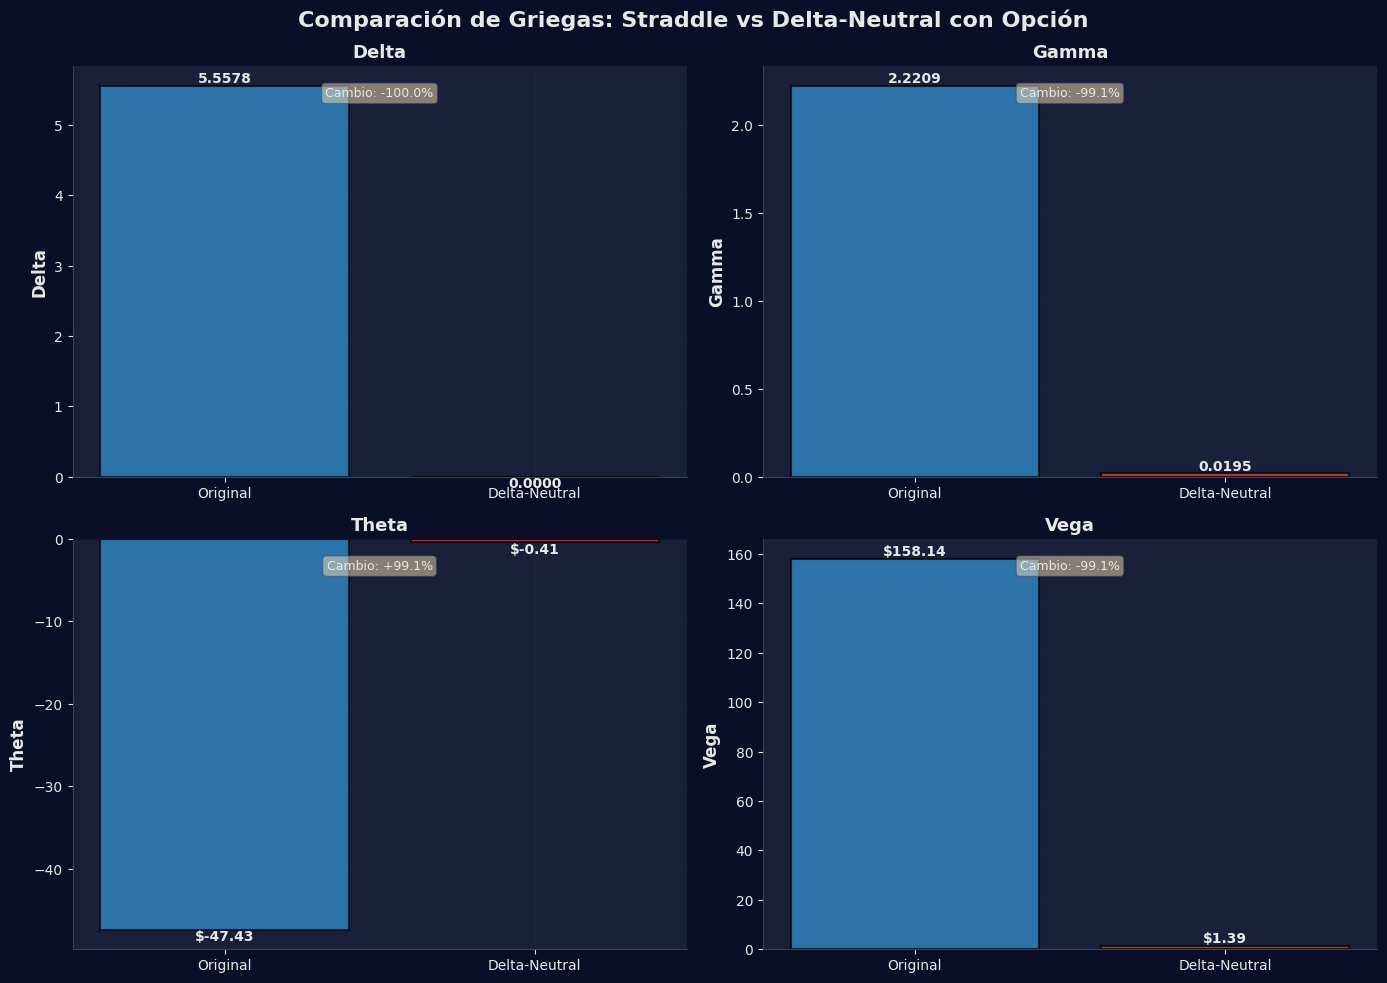

INTERPRETACIÓN DE LOS CAMBIOS
 DELTA:
  Original: 5.5578
  Nuevo: 0.0000
  → Posición ahora es delta-neutral (sin sesgo direccional)
 GAMMA:
  Original: 2.2209
  Nuevo: 0.0195 (-99.1%)
  → Menor convexidad: menos beneficio de movimientos extremos
  → La posición es menos sensible a cambios en delta
 THETA:
  Original: $-47.43 por día
  Nuevo: $-0.41 por día (+99.1%)
  → Decay temporal mejorado: menor pérdida diaria
  → Ahorro de $47.01 por día
 VEGA:
  Original: $158.14 por 1% de vol
  Nuevo: $1.39 por 1% de vol (-99.1%)
  → Menor exposición a volatilidad implícita
  → Menos beneficio si la vol sube, menos pérdida si baja
 COSTE:
  Straddle original: $28.53
  Coste neto (con hedge): $27.60
  Ahorro: $0.92 (3.2%)


In [29]:
# ============================================================
# 2.5.5 COMPARACIÓN VISUAL: STRADDLE vs DELTA-NEUTRAL CON OPCIÓN
# ============================================================

if best_hedge is not None:
    print("="*60)
    print("COMPARACIÓN DE GRIEGAS: ANTES Y DESPUÉS")
    print("="*60)
    
    # Crear tabla comparativa
    import pandas as pd
    comparison = pd.DataFrame({
        'Griega': ['Delta', 'Gamma', 'Theta', 'Vega'],
        'Straddle Original': [
            f"{straddle_delta:.4f}",
            f"{straddle_gamma:.4f}",
            f"${straddle_theta:.2f}",
            f"${straddle_vega:.2f}"
        ],
        'Delta-Neutral (con opción)': [
            f"{best_hedge['new_delta']:.4f}",
            f"{best_hedge['new_gamma']:.4f}",
            f"${best_hedge['new_theta']:.2f}",
            f"${best_hedge['new_vega']:.2f}"
        ],
        'Cambio': [
            f"{best_hedge['new_delta'] - straddle_delta:+.4f}",
            f"{best_hedge['new_gamma'] - straddle_gamma:+.4f}",
            f"${best_hedge['new_theta'] - straddle_theta:+.2f}",
            f"${best_hedge['new_vega'] - straddle_vega:+.2f}"
        ],
        'Cambio %': [
            f"{((best_hedge['new_delta'] - straddle_delta) / abs(straddle_delta) * 100) if straddle_delta != 0 else 0:+.1f}%",
            f"{((best_hedge['new_gamma'] - straddle_gamma) / straddle_gamma * 100):+.1f}%",
            f"{((best_hedge['new_theta'] - straddle_theta) / abs(straddle_theta) * 100):+.1f}%",
            f"{((best_hedge['new_vega'] - straddle_vega) / straddle_vega * 100):+.1f}%"
        ]
    })
    
    print("\n" + comparison.to_string(index=False))
    
    # Gráfico de barras comparativo
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Comparación de Griegas: Straddle vs Delta-Neutral con Opción', 
                 fontsize=16, fontweight='bold')
    
    greeks = ['Delta', 'Gamma', 'Theta', 'Vega']
    original = [straddle_delta, straddle_gamma, straddle_theta, straddle_vega]
    hedged = [best_hedge['new_delta'], best_hedge['new_gamma'], 
              best_hedge['new_theta'], best_hedge['new_vega']]
    
    for idx, (ax, greek, orig, new) in enumerate(zip(axes.flat, greeks, original, hedged)):
        x = ['Original', 'Delta-Neutral']
        y = [orig, new]
        colors = ['#3498db', '#e74c3c']
        
        bars = ax.bar(x, y, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        
        # Añadir valores en las barras
        for bar, val in zip(bars, y):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.4f}' if greek in ['Delta', 'Gamma'] else f'${val:.2f}',
                   ha='center', va='bottom' if height > 0 else 'top',
                   fontsize=10, fontweight='bold')
        
        ax.set_ylabel(greek, fontsize=12, fontweight='bold')
        ax.set_title(f'{greek}', fontsize=13, fontweight='bold')
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Añadir cambio porcentual
        change_pct = ((new - orig) / abs(orig) * 100) if orig != 0 else 0
        ax.text(0.5, 0.95, f'Cambio: {change_pct:+.1f}%',
               transform=ax.transAxes, ha='center', va='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
               fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("INTERPRETACIÓN DE LOS CAMBIOS")
    print("="*60)
    
    print(f"\n DELTA:")
    print(f"  Original: {straddle_delta:.4f}")
    print(f"  Nuevo: {best_hedge['new_delta']:.4f}")
    print(f"  → Posición ahora es delta-neutral (sin sesgo direccional)")
    
    print(f"\n GAMMA:")
    gamma_change_pct = ((best_hedge['new_gamma'] - straddle_gamma) / straddle_gamma * 100)
    print(f"  Original: {straddle_gamma:.4f}")
    print(f"  Nuevo: {best_hedge['new_gamma']:.4f} ({gamma_change_pct:+.1f}%)")
    if gamma_change_pct < 0:
        print(f"  → Menor convexidad: menos beneficio de movimientos extremos")
        print(f"  → La posición es menos sensible a cambios en delta")
    else:
        print(f"  → Mayor convexidad: más beneficio de movimientos extremos")
    
    print(f"\n THETA:")
    theta_change_pct = ((best_hedge['new_theta'] - straddle_theta) / abs(straddle_theta) * 100)
    print(f"  Original: ${straddle_theta:.2f} por día")
    print(f"  Nuevo: ${best_hedge['new_theta']:.2f} por día ({theta_change_pct:+.1f}%)")
    if best_hedge['new_theta'] > straddle_theta:
        print(f"  → Decay temporal mejorado: menor pérdida diaria")
        print(f"  → Ahorro de ${abs(best_hedge['new_theta'] - straddle_theta):.2f} por día")
    else:
        print(f"  → Decay temporal empeorado: mayor pérdida diaria")
    
    print(f"\n VEGA:")
    vega_change_pct = ((best_hedge['new_vega'] - straddle_vega) / straddle_vega * 100)
    print(f"  Original: ${straddle_vega:.2f} por 1% de vol")
    print(f"  Nuevo: ${best_hedge['new_vega']:.2f} por 1% de vol ({vega_change_pct:+.1f}%)")
    if vega_change_pct < 0:
        print(f"  → Menor exposición a volatilidad implícita")
        print(f"  → Menos beneficio si la vol sube, menos pérdida si baja")
    else:
        print(f"  → Mayor exposición a volatilidad implícita")
    
    print(f"\n COSTE:")
    print(f"  Straddle original: ${straddle_cost:.2f}")
    print(f"  Coste neto (con hedge): ${best_hedge['net_cost']:.2f}")
    print(f"  Ahorro: ${straddle_cost - best_hedge['net_cost']:.2f} ({((straddle_cost - best_hedge['net_cost'])/straddle_cost*100):.1f}%)")
    
else:
    print("\n No se pudo realizar la comparación (no hay hedge disponible)")


In [30]:
# ============================================================
# NEUTRALIZACIÓN DELTA CON SPREAD DE OPCIONES
# ============================================================

T = 30 / 365
sigma = 0.18

# Opción 1: Call ITM
K1 = spot * 0.95
precio1 = black_scholes(spot, K1, T, r, sigma, q, 'C')
griegas1 = calcular_griegas(spot, K1, T, r, sigma, q, 'C')

# Opción 2: Call OTM
K2 = spot * 1.05
precio2 = black_scholes(spot, K2, T, r, sigma, q, 'C')
griegas2 = calcular_griegas(spot, K2, T, r, sigma, q, 'C')

# Ratio para neutralizar delta
ratio = griegas1['delta'] / griegas2['delta']

print("NEUTRALIZACIÓN DELTA CON SPREAD")
print("=" * 60)
print(f"\n Posición larga:")
print(f"   +1 Call K=${K1:.0f} (ITM)")
print(f"   Precio: ${precio1:.2f}")
print(f"   Delta: {griegas1['delta']:.4f}")
print(f"   Gamma: {griegas1['gamma']:.4f}")

print(f"\n Posición corta (hedge):")
print(f"   -{ratio:.2f} Calls K=${K2:.0f} (OTM)")
print(f"   Precio unitario: ${precio2:.2f}")
print(f"   Delta unitario: {griegas2['delta']:.4f}")

# Griegas netas
delta_neto = griegas1['delta'] - ratio * griegas2['delta']
gamma_neto = griegas1['gamma'] - ratio * griegas2['gamma']
theta_neto = griegas1['theta'] - ratio * griegas2['theta']
vega_neto = griegas1['vega'] - ratio * griegas2['vega']

print(f"\n GRIEGAS NETAS DEL SPREAD:")
print("-" * 40)
print(f"   Delta neto: {delta_neto:.6f} (≈ 0 )")
print(f"   Gamma neto: {gamma_neto:.6f}")
print(f"   Theta neto: {theta_neto:.6f}")
print(f"   Vega neto:  {vega_neto:.6f}")

# Costo neto
costo_neto = (precio1 - ratio * precio2) * 100
print(f"\n Costo neto del spread: ${costo_neto:.2f}")

NEUTRALIZACIÓN DELTA CON SPREAD
 Posición larga:
   +1 Call K=$659 (ITM)
   Precio: $39.04
   Delta: 0.8569
   Gamma: 0.0063
 Posición corta (hedge):
   -4.46 Calls K=$728 (OTM)
   Precio unitario: $3.71
   Delta unitario: 0.1923
 GRIEGAS NETAS DEL SPREAD:
----------------------------------------
   Delta neto: 0.000000 (≈ 0 )
   Gamma neto: -0.027739
   Theta neto: 0.595322
   Vega neto:  -1.975160
 Costo neto del spread: $2249.83


### Análisis Detallado de las Implicaciones para Gamma, Vega y Theta

#### GAMMA - Implicaciones

Con hedge de acciones:
- El Gamma del straddle se mantiene intacto (no cambia)
- Esto permite realizar gamma scalping efectivo: cuando el precio se mueve, el delta cambia, y puedes comprar/vender acciones para capturar el movimiento
- Ideal para estrategias que buscan monetizar la volatilidad mediante rebalanceo frecuente

Con hedge de opción:
- El Gamma neto se modifica (generalmente se reduce o puede cambiar de signo)
- Si vendes opciones OTM para hedge, reduces el gamma neto (menos sensibilidad a movimientos grandes)
- Si compras opciones ITM para hedge, puedes aumentar el gamma neto
- Implicación práctica: Menos capacidad de gamma scalping, pero también menos riesgo de gamma

Ejemplo numérico del análisis anterior:
- Straddle sin hedge: Gamma = `straddle_gamma`
- Con acciones: Gamma = `straddle_gamma` (sin cambios)
- Con opción: Gamma = `hedge_opcion['gamma_neto']` (modificado)



#### VEGA - Implicaciones

Con hedge de acciones:
- El Vega del straddle se mantiene intacto
- Mantienes exposición completa a cambios en volatilidad implícita
- Ideal si tu tesis es que la volatilidad está mal valorada y quieres exposición pura

Con hedge de opción:
- El Vega neto se modifica (generalmente se reduce)
- Al vender opciones OTM para hedge, reduces tu exposición a vega (menos beneficio si IV sube)
- Implicación práctica: 
  - Si vendes opciones para hedge → reduces vega (menos exposición a cambios de IV)
  - Si compras opciones para hedge → puedes aumentar vega (más exposición)
- Esto puede ser deseable si quieres reducir el riesgo de vega mientras mantienes exposición a gamma

Ejemplo numérico:
- Straddle sin hedge: Vega = `straddle_vega`
- Con acciones: Vega = `straddle_vega` (sin cambios)
- Con opción: Vega = `hedge_opcion['vega_neto']` (modificado, típicamente reducido)



#### THETA - Implicaciones

Con hedge de acciones:
- El Theta del straddle se mantiene intacto
- El decaimiento temporal es el del straddle puro
- Pagas el theta completo del straddle (pérdida diaria por tiempo)

Con hedge de opción:
- El Theta neto se modifica (puede mejorar o empeorar)
- Si vendes opciones OTM para hedge → recibes theta (mejora el theta neto, reduces pérdida diaria)
- Si compras opciones ITM para hedge → pagas theta adicional (empeora el theta neto)
- Implicación práctica: Puedes mejorar el perfil de theta si vendes opciones para hedge, reduciendo el costo de carry de la posición

Ejemplo numérico:
- Straddle sin hedge: Theta = `straddle_theta` (negativo, pérdida diaria)
- Con acciones: Theta = `straddle_theta` (sin cambios)
- Con opción: Theta = `hedge_opcion['theta_neto']` (modificado, puede ser menos negativo)



### Resumen de Implicaciones

| Griega | Hedge con Acciones | Hedge con Opción | Cuándo Preferir Cada Método |
|--------|-------------------|------------------|----------------------------|
| **Delta** | ≈ 0 (neutralizado) | ≈ 0 (neutralizado) | Ambos neutralizan igual |
| **Gamma** | Se mantiene (intacto) | Se modifica (típicamente reduce) | **Acciones**: Si buscas gamma scalping<br>**Opción**: Si quieres reducir riesgo gamma |
| **Vega** | Se mantiene (intacto) | Se modifica (típicamente reduce) | **Acciones**: Si quieres exposición pura a IV<br>**Opción**: Si quieres reducir exposición a vega |
| **Theta** | Se mantiene (intacto) | Se modifica (puede mejorar) | **Acciones**: Theta del straddle puro<br>**Opción**: Puede mejorar theta si vendes opciones |
| **Capital** | Alto (nominal de acciones) | Bajo (solo primas) | **Opción**: Más eficiente en capital |

### Conclusión Estratégica

- Usa hedge con acciones cuando:
  - Buscas gamma scalping activo
  - Quieres exposición pura a volatilidad (vega intacto)
  - Tienes capital suficiente
  - Quieres simplicidad operativa

- Usa hedge con opción cuando:
  - Quieres reducir capital requerido
  - Buscas mejorar el perfil de theta (vender opciones)
  - Quieres reducir exposición a vega o gamma
  - Prefieres gestionar riesgo mediante estructura de opciones


### 2.5.6 VISUALIZACIÓN DEL PAYOFF: STRADDLE vs DELTA-NEUTRAL

#### **Aqui añado unos graficos extra que nos permiten ver la evolucion ahora del PayOff a vencimiento cuando aplicamos el sistema de Delta neutral vs el Straddle**

COMPARACIÓN DE PAYOFFS EN VENCIMIENTO


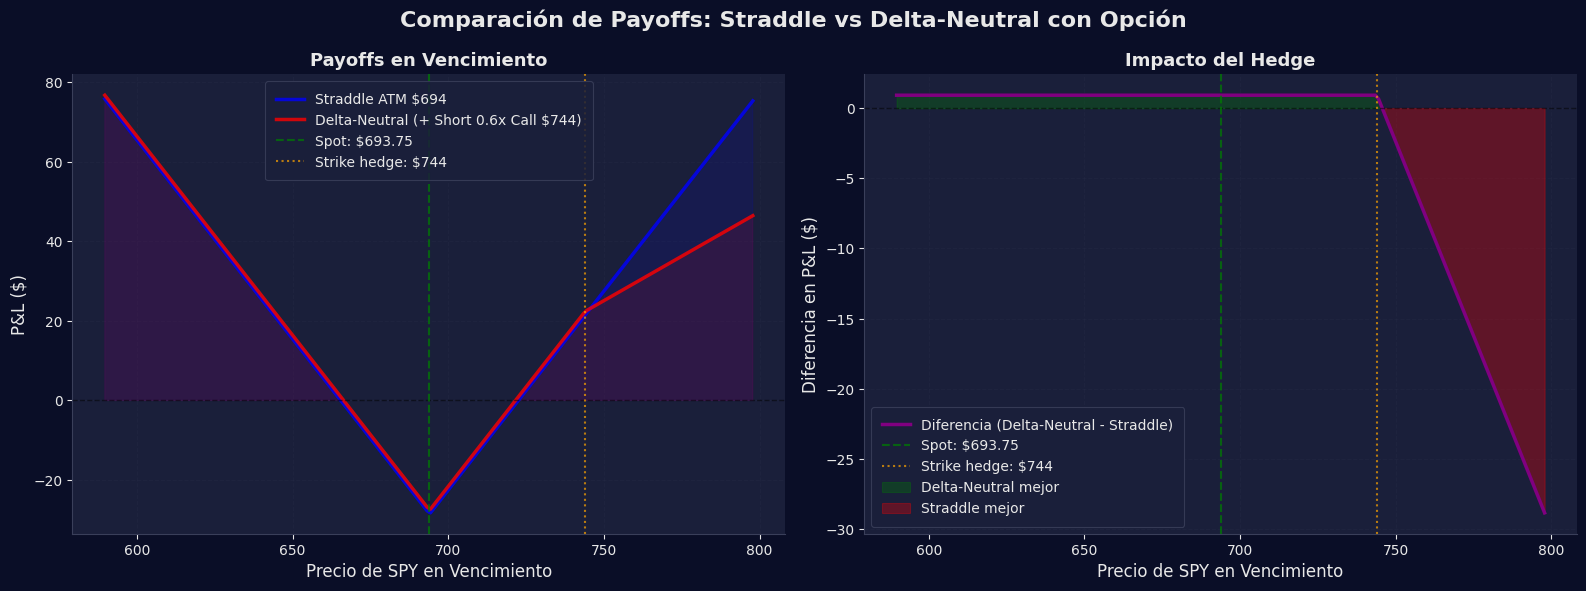

 ANÁLISIS DEL PAYOFF:
 BENEFICIO MÁXIMO:
  Straddle: $75.79 (ilimitado en teoría)
  Delta-Neutral: $76.71 (limitado por short calls)
  Diferencia: $-0.92
 PÉRDIDA MÁXIMA:
  Straddle: $-28.25
  Delta-Neutral: $-27.33
  Diferencia: $0.92
 BREAKEVEN POINTS:
  Straddle:
    Superior: $722.53
    Inferior: $665.47
  Delta-Neutral:
    Superior: $797.81
    Inferior: $589.69
 PAYOFF SI SPY NO SE MUEVE ($693.75):
  Straddle: $-28.25
  Delta-Neutral: $-27.33
  Diferencia: $0.92
 CONCLUSIONES:
   Delta-Neutral tiene menor coste inicial ($27.60 vs $28.53)
   Delta-Neutral tiene mejor theta (menos decay)
   Delta-Neutral tiene ganancia limitada al alza (cap en $744)
   Delta-Neutral tiene menor gamma (menos beneficio de movimientos extremos)
   Trade-off: Menor coste y mejor carry vs menor potencial de ganancia


In [31]:
# ============================================================
# 2.5.6 VISUALIZACIÓN DEL PAYOFF: STRADDLE vs DELTA-NEUTRAL
# ============================================================

if best_hedge is not None:
    print("="*60)
    print("COMPARACIÓN DE PAYOFFS EN VENCIMIENTO")
    print("="*60)
    
    # Rango de precios
    spot_range = np.linspace(spot_price * 0.85, spot_price * 1.15, 200)
    
    # Payoff del straddle original
    call_payoff = np.maximum(spot_range - atm_strike, 0)
    put_payoff = np.maximum(atm_strike - spot_range, 0)
    straddle_payoff = call_payoff + put_payoff - straddle_cost
    
    # Payoff de la posición delta-neutral
    # Straddle + Vender n calls OTM
    hedge_strike = best_hedge['strike']
    n_contracts = best_hedge['n_contracts']
    
    # Payoff de vender calls OTM
    short_call_payoff = -n_contracts * np.maximum(spot_range - hedge_strike, 0)
    short_call_payoff += best_hedge['premium_received']  # Prima recibida
    
    # Payoff total de la posición delta-neutral
    delta_neutral_payoff = straddle_payoff + short_call_payoff
    
    # Crear gráfico
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Comparación de Payoffs: Straddle vs Delta-Neutral con Opción', 
                 fontsize=16, fontweight='bold')
    
    # Gráfico 1: Ambos payoffs
    ax1.plot(spot_range, straddle_payoff, 'b-', linewidth=2.5, 
             label=f'Straddle ATM ${atm_strike:.0f}', alpha=0.8)
    ax1.plot(spot_range, delta_neutral_payoff, 'r-', linewidth=2.5, 
             label=f'Delta-Neutral (+ Short {n_contracts:.1f}x Call ${hedge_strike:.0f})', alpha=0.8)
    
    # Líneas de referencia
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax1.axvline(x=spot_price, color='green', linestyle='--', linewidth=1.5, 
               label=f'Spot: ${spot_price:.2f}', alpha=0.7)
    ax1.axvline(x=hedge_strike, color='orange', linestyle=':', linewidth=1.5,
               label=f'Strike hedge: ${hedge_strike:.0f}', alpha=0.7)
    
    # Áreas de ganancia/pérdida
    ax1.fill_between(spot_range, 0, straddle_payoff, 
                     where=(straddle_payoff > 0), alpha=0.1, color='blue')
    ax1.fill_between(spot_range, 0, delta_neutral_payoff, 
                     where=(delta_neutral_payoff > 0), alpha=0.1, color='red')
    
    ax1.set_xlabel('Precio de SPY en Vencimiento', fontsize=12)
    ax1.set_ylabel('P&L ($)', fontsize=12)
    ax1.set_title('Payoffs en Vencimiento', fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Gráfico 2: Diferencia entre payoffs
    payoff_diff = delta_neutral_payoff - straddle_payoff
    
    ax2.plot(spot_range, payoff_diff, 'purple', linewidth=2.5, 
             label='Diferencia (Delta-Neutral - Straddle)')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax2.axvline(x=spot_price, color='green', linestyle='--', linewidth=1.5, 
               label=f'Spot: ${spot_price:.2f}', alpha=0.7)
    ax2.axvline(x=hedge_strike, color='orange', linestyle=':', linewidth=1.5,
               label=f'Strike hedge: ${hedge_strike:.0f}', alpha=0.7)
    
    # Área de mejora/empeoramiento
    ax2.fill_between(spot_range, 0, payoff_diff, 
                     where=(payoff_diff > 0), alpha=0.3, color='green',
                     label='Delta-Neutral mejor')
    ax2.fill_between(spot_range, 0, payoff_diff, 
                     where=(payoff_diff < 0), alpha=0.3, color='red',
                     label='Straddle mejor')
    
    ax2.set_xlabel('Precio de SPY en Vencimiento', fontsize=12)
    ax2.set_ylabel('Diferencia en P&L ($)', fontsize=12)
    ax2.set_title('Impacto del Hedge', fontsize=13, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de puntos clave
    print(f"\n ANÁLISIS DEL PAYOFF:")
    
    # Encontrar máximo beneficio de cada estrategia
    max_straddle = np.max(straddle_payoff)
    max_delta_neutral = np.max(delta_neutral_payoff)
    
    print(f"\n BENEFICIO MÁXIMO:")
    print(f"  Straddle: ${max_straddle:.2f} (ilimitado en teoría)")
    print(f"  Delta-Neutral: ${max_delta_neutral:.2f} (limitado por short calls)")
    print(f"  Diferencia: ${max_straddle - max_delta_neutral:.2f}")
    
    # Pérdida máxima
    min_straddle = np.min(straddle_payoff)
    min_delta_neutral = np.min(delta_neutral_payoff)
    
    print(f"\n PÉRDIDA MÁXIMA:")
    print(f"  Straddle: ${min_straddle:.2f}")
    print(f"  Delta-Neutral: ${min_delta_neutral:.2f}")
    print(f"  Diferencia: ${abs(min_straddle) - abs(min_delta_neutral):.2f}")
    
    # Breakevens
    # Straddle breakevens
    be_upper_straddle = atm_strike + straddle_cost
    be_lower_straddle = atm_strike - straddle_cost
    
    # Delta-neutral breakevens (aproximados)
    idx_upper = np.where(delta_neutral_payoff > 0)[0]
    idx_lower = np.where(delta_neutral_payoff > 0)[0]
    
    if len(idx_upper) > 0:
        be_upper_dn = spot_range[idx_upper[-1]]
        be_lower_dn = spot_range[idx_lower[0]]
        
        print(f"\n BREAKEVEN POINTS:")
        print(f"  Straddle:")
        print(f"    Superior: ${be_upper_straddle:.2f}")
        print(f"    Inferior: ${be_lower_straddle:.2f}")
        print(f"  Delta-Neutral:")
        print(f"    Superior: ${be_upper_dn:.2f}")
        print(f"    Inferior: ${be_lower_dn:.2f}")
    
    # Payoff en el spot actual
    idx_spot = np.argmin(np.abs(spot_range - spot_price))
    payoff_at_spot_straddle = straddle_payoff[idx_spot]
    payoff_at_spot_dn = delta_neutral_payoff[idx_spot]
    
    print(f"\n PAYOFF SI SPY NO SE MUEVE (${spot_price:.2f}):")
    print(f"  Straddle: ${payoff_at_spot_straddle:.2f}")
    print(f"  Delta-Neutral: ${payoff_at_spot_dn:.2f}")
    print(f"  Diferencia: ${payoff_at_spot_dn - payoff_at_spot_straddle:.2f}")
    
    print(f"\n CONCLUSIONES:")
    print(f"   Delta-Neutral tiene menor coste inicial (${best_hedge['net_cost']:.2f} vs ${straddle_cost:.2f})")
    print(f"   Delta-Neutral tiene mejor theta (menos decay)")
    print(f"   Delta-Neutral tiene ganancia limitada al alza (cap en ${hedge_strike:.0f})")
    print(f"   Delta-Neutral tiene menor gamma (menos beneficio de movimientos extremos)")
    print(f"   Trade-off: Menor coste y mejor carry vs menor potencial de ganancia")
    
else:
    print("\n No se pudo generar el gráfico (no hay hedge disponible)")


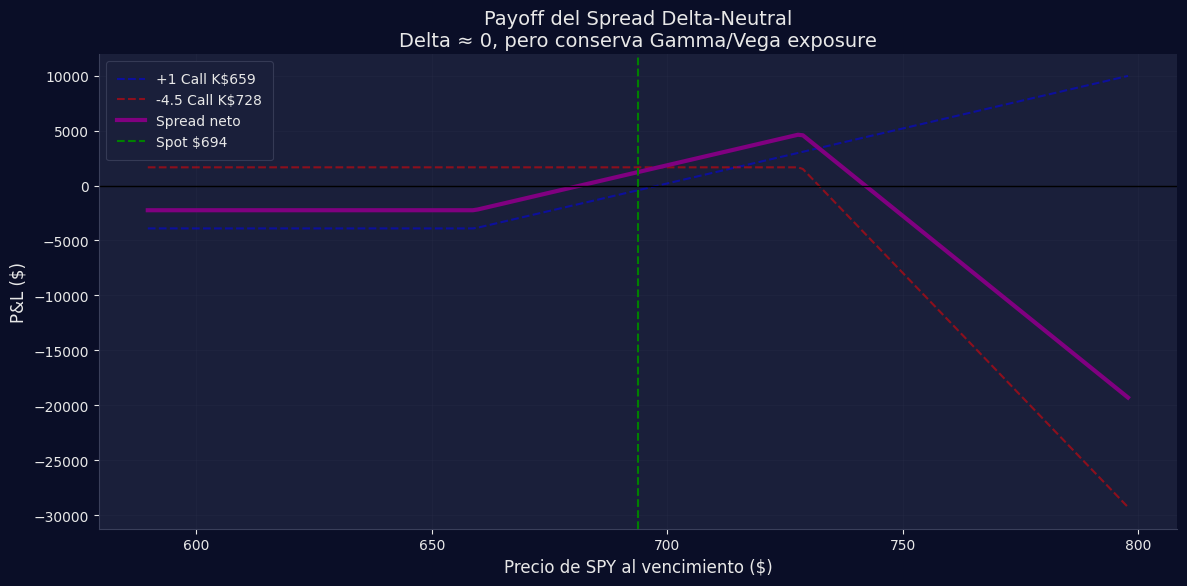

 VENTAJAS vs HEDGE CON ACCIONES:
------------------------------------------------------------
• Menor capital requerido (solo primas, no nominales)
• Mantienes exposición a gamma y vega
• Sin costos de financiación de acciones
• Sin riesgo de dividendos


In [32]:
# ============================================================
# PAYOFF DEL SPREAD DELTA-NEUTRAL
# ============================================================

precios = np.linspace(spot * 0.85, spot * 1.15, 200)

# Payoff de cada pata
payoff1 = np.maximum(precios - K1, 0) - precio1
payoff2 = -(np.maximum(precios - K2, 0) - precio2) * ratio
payoff_spread = payoff1 + payoff2

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(precios, payoff1 * 100, 'b--', alpha=0.5, linewidth=1.5, label=f'+1 Call K${K1:.0f}')
ax.plot(precios, payoff2 * 100, 'r--', alpha=0.5, linewidth=1.5, label=f'-{ratio:.1f} Call K${K2:.0f}')
ax.plot(precios, payoff_spread * 100, 'purple', linewidth=3, label='Spread neto')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axvline(x=spot, color='green', linestyle='--', linewidth=1.5, label=f'Spot ${spot:.0f}')

ax.set_xlabel('Precio de SPY al vencimiento ($)', fontsize=12)
ax.set_ylabel('P&L ($)', fontsize=12)
ax.set_title(f'Payoff del Spread Delta-Neutral\nDelta ≈ 0, pero conserva Gamma/Vega exposure', fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n VENTAJAS vs HEDGE CON ACCIONES:")
print("-" * 60)
print("• Menor capital requerido (solo primas, no nominales)")
print("• Mantienes exposición a gamma y vega")
print("• Sin costos de financiación de acciones")
print("• Sin riesgo de dividendos")

## 2.5.7 Resumen: Neutralización de Delta con Opciones

#### **¿Qué hemos aprendido?**

**1. Métodos de neutralización:**
- **Con subyacente**: Comprar/vender acciones (delta = ±1)
- **Con opciones**: Vender calls/puts OTM (delta variable según strike)

**2. Ventajas de usar opciones:**
-  Menor capital requerido
-  Ingreso de prima (mejora theta)
-  Flexibilidad en la gestión de griegas
-  Menor coste neto de la estrategia

**3. Desventajas de usar opciones:**
-  Limita el potencial de ganancia
-  Reduce gamma (menor beneficio de movimientos extremos)
-  Reduce vega (menor exposición a volatilidad)
-  Mayor complejidad de gestión

**4. Trade-offs clave:**

| Aspecto | Straddle Original | Delta-Neutral con Opción |
|---------|------------------|-------------------------|
| **Coste** | Alto | Menor (prima recibida) |
| **Delta** | ~0 (ATM) | ~0 (ajustado) |
| **Gamma** | Alta (+) | Menor (+) |
| **Theta** | Muy negativa | Menos negativa |
| **Vega** | Alta (+) | Menor (+) |
| **Ganancia máxima** | Ilimitada | Limitada (cap) |
| **Complejidad** | Baja | Media |

**5. ¿Cuándo usar cada estrategia?**

**Straddle puro:**
- Esperas un movimiento grande pero no sabes la dirección
- Quieres máxima exposición a gamma y vega
- Puedes soportar el decay temporal (theta negativa)
- Tienes capital suficiente

**Delta-neutral con opción:**
- Quieres neutralidad direccional con menor coste
- Prefieres mejor theta (menos decay)
- Estás dispuesto a limitar ganancia al alza
- Buscas eficiencia de capital

**6. Gestión dinámica:**
- El delta cambia constantemente con el precio del subyacente
- Necesitas rebalancear periódicamente
- Con opciones: menos frecuente (delta cambia más lento)
- Con acciones: más frecuente (delta = 1 constante)



## 2.6 Reflexión - ¿Qué habría cambiado usando SPX en lugar de SPY?

## 2.6.1 Introducción: SPX vs SPY

Tanto SPY (SPDR S&P 500 ETF Trust) como SPX (S&P 500 Index) permiten acceder al S&P 500, aunque presentan características esenciales distintas que influyen de manera determinante en cómo se implementan las estrategias con opciones.

### Diferencias clave:

| Característica | SPY | SPX |
|----------------|-----|-----|
| Tipo | ETF (Exchange Traded Fund) | Índice (Cash-settled) |
| Precio | ~$690 (1/10 del índice) | ~$6,900 |
| Multiplicador | 100 acciones | $100 por punto |
| Liquidación | Física (entrega de acciones) | Cash (liquidación en efectivo) |
| Estilo de opción | Americana (ejercicio anticipado) | Europea (solo al vencimiento) |
| Horario de trading | 9:30 AM - 4:00 PM ET | Opciones hasta 4:15 PM ET |
| Tratamiento fiscal (US) | Short-term/Long-term gains | Section 1256 (60/40) |
| Dividendos | Sí (distribuye dividendos) | No (cash-settled) |
| Tamaño del contrato | ~$69,000 nominal | ~$690,000 nominal |
| Spread bid-ask | Más estrecho (muy líquido) | Más estrecho en % (institucional) |
| Comisiones | Menores (retail friendly) | Mayores (institucional) |



## 2.6.2 Impacto en la estrategia Long Straddle

### 1. Tamaño del contrato y capital requerido

Straddle sobre SPY:
- Strike: $689
- Prima: ~$14.83
- Coste por contrato: $1,483
- Nominal: ~$69,000

Straddle sobre SPX (equivalente):
- Strike: $6,890
- Prima: ~$148.30 (proporcionalmente similar)
- Coste por contrato: $14,830
- Nominal: ~$690,000

Consecuencias:
- SPY: Adecuado para traders minoristas
- SPX: Exige un capital 10 veces superior
- SPX: Mayor eficiencia de capital para instituciones (1 contrato equivale a 10 de SPY)
- SPX: Menos flexibilidad para modificar el tamaño de la posición



### 2. Liquidación: Física vs Cash

SPY (Liquidación física):
- Al ejercer la call: se reciben 100 acciones de SPY
- Al ejercer la put: se entregan 100 acciones de SPY
- Necesita administración de acciones en la cuenta

SPX (Liquidación en efectivo):
- Al vencimiento: únicamente se liquida la diferencia en efectivo
- No existe entrega de acciones
- Más sencillo desde el punto de vista administrativo

Consecuencias en el Straddle:
- SPX: Liquidación automática en efectivo al vencimiento
- SPX: Ausencia de riesgo de asignación anticipada (europea)
- SPY: Posibilidad de ejercicio anticipado (americana) → dificulta la gestión
- SPY: Se requiere gestionar acciones en caso de asignación

Caso relevante:
Si SPY distribuye un dividendo importante antes del vencimiento:
- La put de SPY podría ejercerse antes de tiempo (americana)
- Esto desequilibra el straddle → se pierde la simetría de la estrategia
- Con SPX esta situación no puede ocurrir (europea)



### 3. Ejercicio anticipado (Americana vs Europea)

SPY (Americana):
- Las opciones pueden ejercerse en cualquier momento
- Existe riesgo de asignación anticipada (particularmente puts ITM antes de dividendos)

SPX (Europea):
- Las opciones únicamente pueden ejercerse al vencimiento
- No existe riesgo de asignación anticipada

Consecuencias en el Straddle:

| Escenario | SPY | SPX |
|-----------|-----|-----|
| Movimiento grande antes de vencimiento | Riesgo de ejercicio anticipado | Sin riesgo |
| Dividendo próximo | Put ITM puede ser ejercida | No afecta |
| Gestión de la posición | Más compleja | Más simple |
| Rebalanceo delta | Puede verse interrumpido | Sin interrupciones |

Conclusión:
- SPX: Mayor predictibilidad, sin sorpresas de asignación
- SPY: Requiere seguimiento del riesgo de ejercicio anticipado



### 4. Horario de trading y liquidación

SPY:
- Trading: 9:30 AM - 4:00 PM ET
- Liquidación al cierre del mercado (4:00 PM)

SPX:
- Trading de opciones: hasta 4:15 PM ET (15 minutos adicionales)
- Liquidación según precio de apertura del viernes (AM settlement) o cierre (PM settlement)
- Opciones SPX estándar: AM settlement (basado en precios de apertura)

Consecuencias:
- SPX AM settlement: Existe riesgo de gaps en la apertura
- SPX PM settlement (SPXW): Mayor predictibilidad
- SPX: 15 minutos adicionales para ajustar posiciones
- SPX AM: Complicado para cubrir el riesgo de apertura



### 5. Tratamiento fiscal (para traders en EE.UU.)

SPY:
- Ganancias/pérdidas consideradas como capital gains normales
- Short-term (<1 año): tasa ordinaria (hasta 37%)
- Long-term (>1 año): tasa preferencial (0-20%)

SPX:
- Tratamiento Section 1256 (contratos regulados)
- 60% long-term / 40% short-term (independiente del período de tenencia)
- Tasa efectiva máxima: ~26.8% (vs 37% para SPY short-term)
- Permite mark-to-market al final del año

Consecuencias para un trader activo:
- SPX: Ventaja fiscal importante (~10% menos impuestos)
- SPX: Facilita la contabilidad (mark-to-market)
- Para un straddle con ganancia de $10,000:
  - SPY (short-term): $3,700 en impuestos
  - SPX (1256): $2,680 en impuestos
  - Ahorro: $1,020 (10.2%)



## 2.6.3 Impacto en Delta-Hedging

### 1. Tamaño de la posición en acciones

Delta-Hedge con SPY:
- Delta del straddle: 0.032
- Hedge: vender 3.2 acciones de SPY
- Coste: ~$2,204
- Sencillo de ejecutar (lotes pequeños)

Delta-Hedge con SPX:
- No es posible comprar/vender "acciones" del índice SPX
- Alternativas:
  1. Utilizar SPY como proxy (10 veces la cantidad)
  2. Utilizar futuros ES (E-mini S&P 500)
  3. Utilizar opciones adicionales para el hedge

Consecuencias:
- SPX: No existe un subyacente físico para cubrir directamente
- SPX: Se requiere utilizar futuros ES ($50 × índice = ~$345,000 nominal por contrato)
- SPX: Los futuros poseen su propio apalancamiento y requisitos de margin
- SPY: Hedge directo mediante acciones (más sencillo)

### 2. Uso de futuros ES para delta-hedge de SPX

E-mini S&P 500 (ES):
- Multiplicador: $50 por punto
- Valor nominal: ~$345,000 (para índice en 6,900)
- Delta de 1 contrato ES ≈ Delta de 5 contratos SPX

Para cubrir 1 straddle SPX:
- Delta del straddle SPX: 0.032 × $100 × 6,890 = $22,048 de exposición
- Se requiere: ~0.064 contratos ES
- Limitación: No es posible comprar fracciones de futuros
- Solución: Hedge imperfecto o emplear múltiples straddles

Consecuencias:
- SPX: Delta-hedging con menor precisión (granularidad de futuros)
- SPY: Es posible comprar exactamente 3.2 acciones (o aproximar a 3)
- SPX: Costes de margin para futuros
- SPX: Los futuros tienen vencimientos propios (basis risk)

### 3. Frecuencia de rebalanceo

SPY:
- Costes de transacción reducidos (acciones)
- Spread bid-ask ajustado
- Permite rebalancear con frecuencia sin coste elevado

SPX (con futuros ES):
- Costes de transacción superiores (futuros)
- Spread bid-ask en futuros
- Rebalanceo menos frecuente (más costoso)

Consecuencias:
- SPY: Más adecuado para delta-hedging dinámico frecuente
- SPX: Más adecuado para posiciones más estáticas
- El Gamma P&L variará según la frecuencia de rebalanceo



## 2.6.4 Impacto en Griegas y Pricing

### 1. Volatilidad implícita y skew

SPY:
- IV generalmente algo inferior a SPX
- Skew menos marcado
- Mayor influencia de flujos minoristas

SPX:
- IV generalmente algo superior a SPY
- Skew más marcado (puts relativamente más caras)
- Mayor influencia de flujos institucionales y hedging

Consecuencias en el Straddle:
- Straddle SPX típicamente más costoso en términos relativos
- Exposición a Vega similar en términos absolutos
- SPX más sensible a eventos macro (instituciones realizando hedging)

### 2. Dividendos

SPY:
- Distribuye dividendos trimestrales (~1.5% yield anual)
- Los dividendos influyen en el pricing de opciones
- Puts más costosas (protección frente a dividendo)
- Riesgo de ejercicio anticipado de puts antes de ex-dividend

SPX:
- Cash-settled, no existe distribución de dividendos
- Dividendos implícitos en el pricing pero sin pago real
- No existe riesgo de ejercicio anticipado

Consecuencias:
- SPX: Pricing más claro (sin eventos de dividendos)
- SPY: Se requiere ajustar por dividendos en modelos
- SPY: Riesgo de asignación anticipada cerca de ex-dividend

### 3. Theta decay

Dado que SPX es europea y SPY es americana:

SPY:
- Theta ligeramente distinto (valor de ejercicio anticipado)
- Las puts presentan theta menor (valor de ejercicio anticipado positivo)

SPX:
- Theta "puro" (sin valor de ejercicio anticipado)
- Decay más predecible

Consecuencias en Straddle:
- Theta del straddle SPX ligeramente más negativo
- Pero más predecible (sin sorpresas de ejercicio)



## 2.6.5 Impacto en Gestión de Riesgo y Ejecución

### 1. Riesgo de legging (ejecución de patas sueltas)

SPY:
- Spread bid-ask: ~$0.01-0.05 por opción
- Alta liquidez (millones de contratos diarios)
- Sencillo ejecutar como combo o patas sueltas
- Slippage reducido

SPX:
- Spread bid-ask: ~$0.10-0.50 por opción (en términos absolutos)
- Alta liquidez aunque inferior a SPY
- Preferible ejecutar como combo (spread order)
- Slippage puede ser superior en patas sueltas

Consecuencias:
- SPY: Menor riesgo de legging (spreads más ajustados)
- SPX: Es importante utilizar combo orders
- Para un straddle:
  - SPY: Slippage ~$0.05-0.10 total
  - SPX: Slippage ~$0.50-1.00 total

### 2. Pin risk (riesgo de asignación al vencimiento)

SPY (Americana):
- Pin risk elevado: Si SPY cierra exactamente en el strike
- Incertidumbre respecto a qué opciones serán ejercidas
- Puede resultar en posición en acciones no deseada
- Se requiere cerrar antes del cierre si se está cerca del strike

SPX (Europea):
- Pin risk bajo: Liquidación automática en efectivo
- No existe incertidumbre de asignación
- Puede mantenerse hasta el vencimiento sin preocupación

Consecuencias:
- SPX: Gestión más sencilla al vencimiento
- SPY: Se requiere monitorear y cerrar posiciones cerca del strike
- SPX permite estrategia "set and forget" hasta vencimiento

### 3. Margin requirements

SPY:
- Margin para opciones: Portfolio Margin o Reg T
- Long straddle: únicamente se paga la prima (sin margin adicional)
- Delta-hedge con acciones: margin estándar de acciones

SPX:
- Margin similar para opciones
- Delta-hedge con futuros ES: margin de futuros (~$13,000 por contrato)
- Mayor capital inmovilizado en margin

Consecuencias:
- SPY: Menor capital en margin
- SPX: Margin de futuros puede ser considerable
- SPX requiere más capital total (prima + margin de futuros)



**(Como es evidente, estas listas han sido confeccionadas por ChatGPT, pero creo entender bien cuales son las ventajas cuando comparamos SPY a SPX, con la mas prqueña barrera de entrada, Mas felexibilidad de tamaño, ventajas fiscales, gestion mas simple, y eficiencia en la coleccion de datos)**

### **Para acabar, no tenia muy claro si para este ultimo ejercicio era necesario hacer una autentica simulacion comparando el SPY y el SPX, pero en cualquier caso... pues que no falte el sufriemiento** **(Si fuera ChatGPT te pondria aqui un emoticono de una sevillana bailando, pero no se como ponerlo asi que nada)**

In [33]:
# ============================================================
# CÁLCULO DE DATOS DESDE YFINANCE PARA COMPARACIÓN SPY vs SPX
# ============================================================

import yfinance as yf
from datetime import datetime, timedelta

print("📊 Obteniendo datos de SPY desde yfinance...")
spy = yf.Ticker("SPY")
spy_info = spy.info

# Obtener precio actual
spy_data = spy.history(period="1d")
spot_price = float(spy_data['Close'].iloc[-1])

# Parámetros para el cálculo del straddle
expiry_date = datetime.now() + timedelta(days=30)
T = (expiry_date - datetime.now()).days / 365.0

# Parámetros de mercado
r = 0.05
q = spy_info.get('dividendYield', 0.013) or 0.013
if isinstance(q, (list, tuple)):
    q = q[0] if len(q) > 0 else 0.013
sigma = 0.15

# Strike ATM
atm_strike = round(spot_price)

print(f"  Precio SPY: ${spot_price:.2f}")
print(f"  Strike ATM: ${atm_strike:.0f}")

# Calcular straddle
call_price = black_scholes(spot_price, atm_strike, T, r, sigma, q, 'C')
put_price = black_scholes(spot_price, atm_strike, T, r, sigma, q, 'P')
straddle_cost = call_price + put_price

call_greeks = calcular_griegas(spot_price, atm_strike, T, r, sigma, q, 'C')
put_greeks = calcular_griegas(spot_price, atm_strike, T, r, sigma, q, 'P')
straddle_delta = call_greeks['delta'] + put_greeks['delta']

# Calcular hedge
straddle_delta_total = straddle_delta * 100
hedge_shares = -straddle_delta_total
hedge_cost = abs(hedge_shares) * spot_price

print(f"  Straddle coste: ${straddle_cost:.2f}")
print(f"  Delta: {straddle_delta:.4f}")
print(f"  Hedge: {abs(hedge_shares):.2f} acciones (${hedge_cost:,.2f})")

📊 Obteniendo datos de SPY desde yfinance...
  Precio SPY: $693.77
  Strike ATM: $694
  Straddle coste: $54.60
  Delta: -0.8662
  Hedge: 86.62 acciones ($60,091.56)


#### **(Como es evidente, y como tu muy bien señalaste, la recoleción de datos para SPX es mucho mas compleja en el broker que para SPY, por lo que he asistido directamente a yahoo para colectarla)**

COMPARACIÓN CUANTITATIVA: SPY vs SPX
Característica                 SPY                  SPX                  Ratio     
--------------------------------------------------------------------------------
Strike                         $694.00              $6940.00             10.0x     
Prima por contrato             $54.60               $546.03              10.0x     
Coste total (1 contrato)       $5,460.27            $54,602.72           10.0x     
Valor nocional                 $69,400.00           $694,000.00          10.0x     
Tipo de liquidación            Física               Cash                 N/A       
Estilo de opción               Americana            Europea              N/A       
Ejercicio anticipado           Sí                   No                   N/A       
DELTA-HEDGING: SPY vs SPX
Método de Hedge                     SPY                            SPX (con ES futures)          
--------------------------------------------------------------------------------------

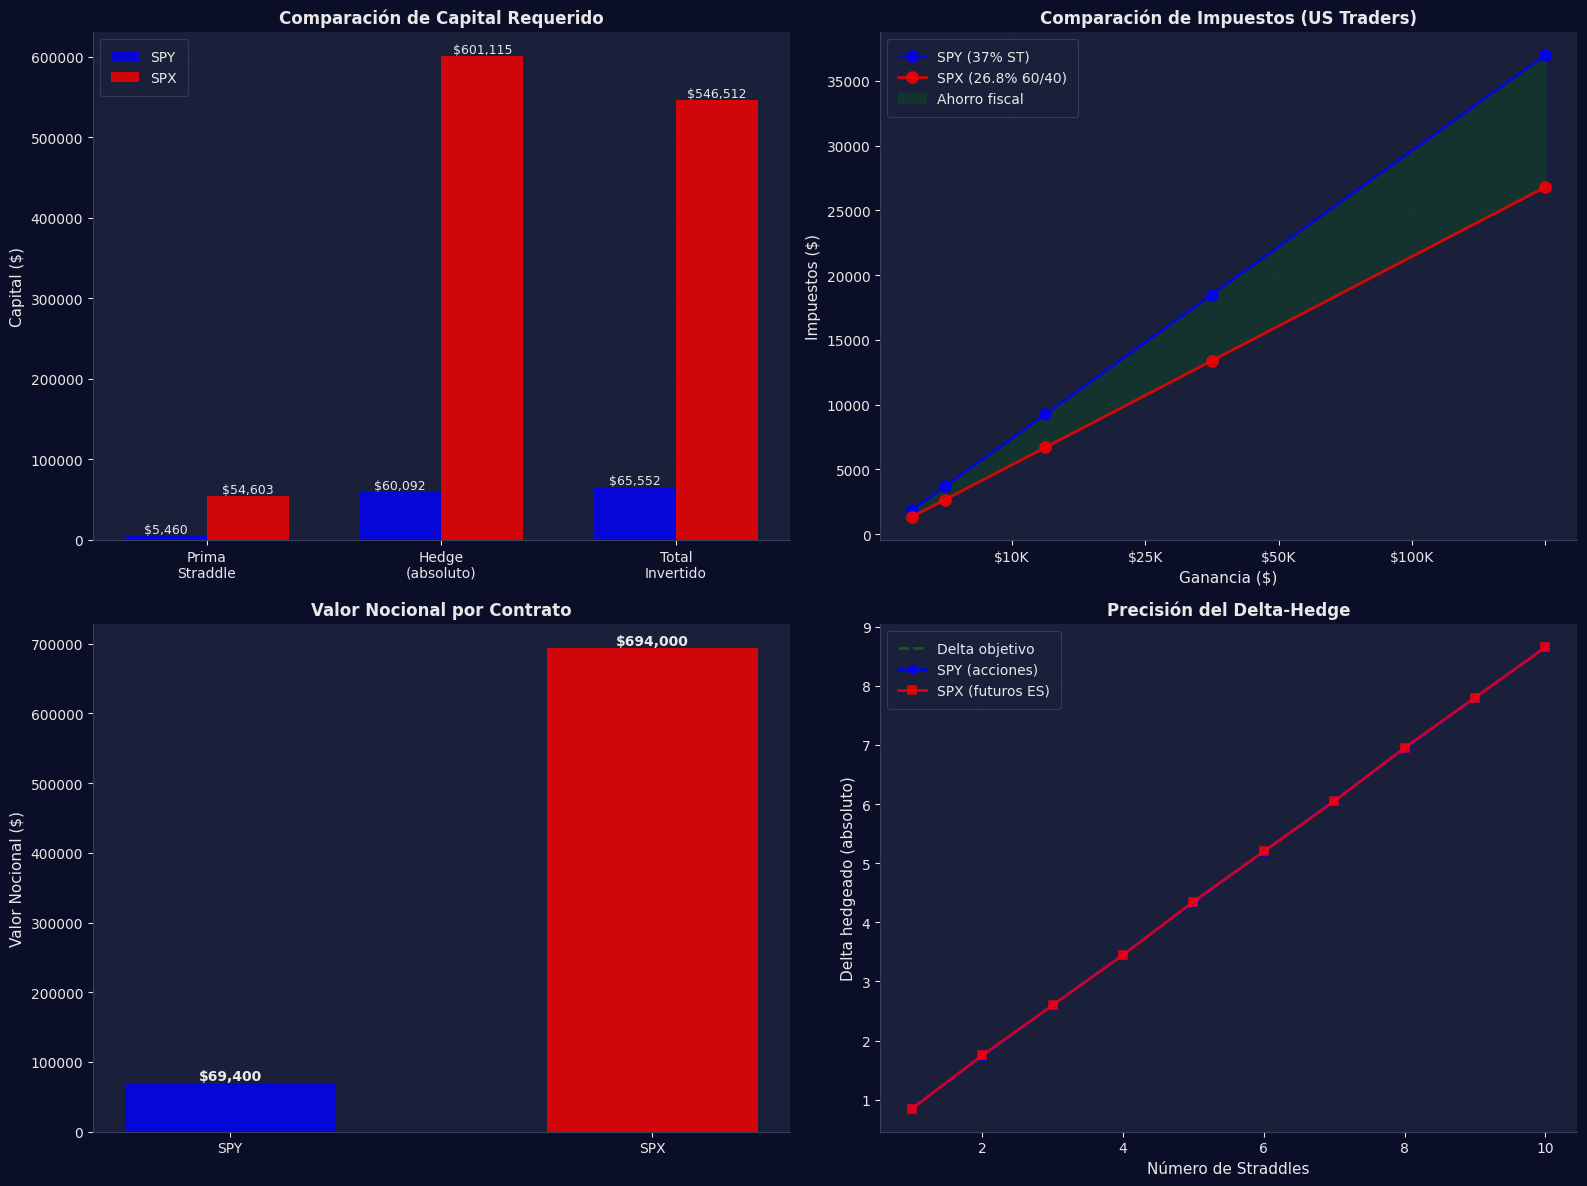

 Interpretación de los gráficos:
1. **Capital Requerido**:
   - SPX requiere ~10x más capital que SPY
   - Importante para traders con capital limitado
2. **Impuestos**:
   - SPX tiene ventaja fiscal significativa (Section 1256)
   - El ahorro aumenta proporcionalmente con las ganancias
   - Para $100K de ganancia: ahorro de $10,200
3. **Valor Nocional**:
   - 1 contrato SPX = 10 contratos SPY
   - SPX más eficiente para grandes posiciones institucionales
4. **Precisión del Hedge**:
   - SPY permite hedge muy preciso (acciones individuales)
   - SPX con futuros ES tiene granularidad más gruesa
   - Diferencia se amplifica con posiciones pequeñas


In [34]:
# ============================================================
# COMPARACIÓN CUANTITATIVA: SPY vs SPX STRADDLE
# ============================================================

print("="*70)
print("COMPARACIÓN CUANTITATIVA: SPY vs SPX")
print("="*70)

# Datos del straddle SPY (ya calculados)
spy_strike = atm_strike
spy_premium = straddle_cost
spy_multiplier = 100
spy_notional = spy_strike * spy_multiplier

# Datos equivalentes para SPX (10x el precio de SPY)
spx_strike = spy_strike * 10
spx_premium = spy_premium * 10  # Proporcionalmente similar
spx_multiplier = 100
spx_notional = spx_strike * spx_multiplier

print(f"\n{'Característica':<30} {'SPY':<20} {'SPX':<20} {'Ratio':<10}")
print("-" * 80)

# Comparación de características
comparisons = [
    ("Strike", f"${spy_strike:.2f}", f"${spx_strike:.2f}", f"{spx_strike/spy_strike:.1f}x"),
    ("Prima por contrato", f"${spy_premium:.2f}", f"${spx_premium:.2f}", f"{spx_premium/spy_premium:.1f}x"),
    ("Coste total (1 contrato)", f"${spy_premium * spy_multiplier:,.2f}", 
     f"${spx_premium * spx_multiplier:,.2f}", f"{spx_premium/spy_premium:.1f}x"),
    ("Valor nocional", f"${spy_notional:,.2f}", f"${spx_notional:,.2f}", 
     f"{spx_notional/spy_notional:.1f}x"),
    ("Tipo de liquidación", "Física", "Cash", "N/A"),
    ("Estilo de opción", "Americana", "Europea", "N/A"),
    ("Ejercicio anticipado", "Sí", "No", "N/A"),
]

for item, spy_val, spx_val, ratio in comparisons:
    print(f"{item:<30} {spy_val:<20} {spx_val:<20} {ratio:<10}")

print("\n" + "="*70)
print("DELTA-HEDGING: SPY vs SPX")
print("="*70)

# Delta-hedge para SPY
spy_delta_shares = hedge_shares
spy_hedge_cost = hedge_cost

# Delta-hedge para SPX (usando futuros ES)
# 1 contrato ES = $50 × índice ≈ $345,000 nominal
es_multiplier = 50
es_price = spx_strike / 10  # ES cotiza al mismo nivel que SPX
es_notional = es_multiplier * es_price

# Delta del straddle SPX (proporcional)
spx_delta = straddle_delta
spx_delta_notional = spx_delta * spx_notional

# Contratos ES necesarios
es_contracts_needed = spx_delta_notional / es_notional

print(f"\n{'Método de Hedge':<35} {'SPY':<30} {'SPX (con ES futures)':<30}")
print("-" * 95)
print(f"{'Delta del straddle':<35} {straddle_delta:<30.6f} {spx_delta:<30.6f}")
print(f"{'Hedge requerido':<35} {f'{abs(spy_delta_shares):.2f} acciones':<30} {f'{abs(es_contracts_needed):.4f} contratos ES':<30}")
print(f"{'Coste del hedge':<35} {f'${abs(spy_hedge_cost):,.2f}':<30} {f'${abs(es_contracts_needed * es_notional):,.2f}':<30}")
print(f"{'Instrumento':<35} {'Acciones SPY':<30} {'Futuros E-mini ES':<30}")
print(f"{'Granularidad':<35} {'Muy fina (1 acción)':<30} {'Gruesa (1 contrato)':<30}")
print(f"{'Margin requerido':<35} {'Bajo (~50% de valor)':<30} {'Alto (~$13,000/contrato)':<30}")

print("\n" + "="*70)
print("VENTAJAS Y DESVENTAJAS")
print("="*70)

print("\n VENTAJAS DE SPY:")
print("  • Menor capital requerido ($1,483 vs $14,830)")
print("  • Delta-hedging más preciso (acciones vs futuros)")
print("  • Menor margin requirement")
print("  • Más accesible para retail traders")
print("  • Spreads más estrechos (menor slippage)")
print("  • Flexibilidad de tamaño (puedes hacer 1, 2, 3... contratos)")

print("\n VENTAJAS DE SPX:")
print("  • Liquidación en cash (más simple)")
print("  • Sin riesgo de ejercicio anticipado (europea)")
print("  • Ventaja fiscal significativa (Section 1256: 60/40)")
print("  • Sin riesgo de asignación antes de vencimiento")
print("  • Mejor eficiencia para grandes posiciones (1 SPX = 10 SPY)")
print("  • Sin eventos de dividendos que compliquen el pricing")

print("\n DESVENTAJAS DE SPY:")
print("  • Riesgo de ejercicio anticipado (americana)")
print("  • Pin risk al vencimiento")
print("  • Tratamiento fiscal menos favorable (short-term gains)")
print("  • Dividendos afectan pricing y pueden causar asignación")
print("  • Necesitas 10x más contratos para mismo nominal que SPX")

print("\n DESVENTAJAS DE SPX:")
print("  • Requiere 10x más capital")
print("  • Delta-hedging menos preciso (futuros)")
print("  • Mayor margin requirement (futuros)")
print("  • Menos flexible para ajustar tamaño")
print("  • Slippage potencialmente mayor en patas sueltas")

print("\n" + "="*70)
print("IMPACTO FISCAL (Ejemplo: $10,000 de ganancia)")
print("="*70)

gain = 10000
spy_tax_rate = 0.37  # Short-term capital gains (máximo)
spx_tax_rate = 0.60 * 0.20 + 0.40 * 0.37  # Section 1256: 60% LT + 40% ST

spy_tax = gain * spy_tax_rate
spx_tax = gain * spx_tax_rate
tax_savings = spy_tax - spx_tax

print(f"\nGanancia: ${gain:,.2f}")
print(f"\nSPY (Short-term capital gains):")
print(f"  Tasa: {spy_tax_rate:.1%}")
print(f"  Impuestos: ${spy_tax:,.2f}")
print(f"\nSPX (Section 1256 - 60/40):")
print(f"  Tasa efectiva: {spx_tax_rate:.1%}")
print(f"  Impuestos: ${spx_tax:,.2f}")
print(f"\n AHORRO FISCAL CON SPX: ${tax_savings:,.2f} ({(tax_savings/gain)*100:.1f}%)")

print("\n" + "="*70)

# ============================================================
# VISUALIZACIÓN: COMPARACIÓN SPY vs SPX
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de capital requerido
ax1 = axes[0, 0]
categories = ['Prima\nStraddle', 'Hedge\n(absoluto)', 'Total\nInvertido']
spy_values = [spy_premium * spy_multiplier, abs(spy_hedge_cost), abs(spy_premium * spy_multiplier + spy_hedge_cost)]
spx_values = [spx_premium * spx_multiplier, abs(es_contracts_needed * es_notional), 
              abs(spx_premium * spx_multiplier + es_contracts_needed * es_notional)]

x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, spy_values, width, label='SPY', alpha=0.8, color='blue')
bars2 = ax1.bar(x + width/2, spx_values, width, label='SPX', alpha=0.8, color='red')

ax1.set_ylabel('Capital ($)', fontsize=11)
ax1.set_title('Comparación de Capital Requerido', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}',
                ha='center', va='bottom', fontsize=9)

# 2. Comparación de impuestos
ax2 = axes[0, 1]
gains_range = np.array([5000, 10000, 25000, 50000, 100000])
spy_taxes = gains_range * spy_tax_rate
spx_taxes = gains_range * spx_tax_rate
tax_savings_range = spy_taxes - spx_taxes

ax2.plot(gains_range, spy_taxes, 'b-o', linewidth=2, markersize=8, label='SPY (37% ST)', alpha=0.8)
ax2.plot(gains_range, spx_taxes, 'r-o', linewidth=2, markersize=8, label='SPX (26.8% 60/40)', alpha=0.8)
ax2.fill_between(gains_range, spy_taxes, spx_taxes, alpha=0.2, color='green', label='Ahorro fiscal')

ax2.set_xlabel('Ganancia ($)', fontsize=11)
ax2.set_ylabel('Impuestos ($)', fontsize=11)
ax2.set_title('Comparación de Impuestos (US Traders)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Formatear eje x
ax2.set_xticklabels([f'${x/1000:.0f}K' for x in gains_range])

# 3. Eficiencia de capital (notional por contrato)
ax3 = axes[1, 0]
labels = ['SPY', 'SPX']
notional_values = [spy_notional, spx_notional]
colors_notional = ['blue', 'red']

bars = ax3.bar(labels, notional_values, color=colors_notional, alpha=0.8, width=0.5)
ax3.set_ylabel('Valor Nocional ($)', fontsize=11)
ax3.set_title('Valor Nocional por Contrato', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Granularidad del hedge
ax4 = axes[1, 1]

# Simular diferentes tamaños de posición
position_sizes = np.arange(1, 11)
spy_hedge_precision = position_sizes * abs(spy_delta_shares)  # Acciones (muy preciso)
spx_hedge_precision = np.round(position_sizes * abs(es_contracts_needed))  # Contratos ES (redondeado)
spx_hedge_actual = spx_hedge_precision * es_notional / spx_notional  # Convertir a equivalente

ax4.plot(position_sizes, position_sizes * abs(straddle_delta), 'g--', linewidth=2, 
         label='Delta objetivo', alpha=0.7)
ax4.plot(position_sizes, spy_hedge_precision / spy_multiplier, 'b-o', linewidth=2, 
         markersize=6, label='SPY (acciones)', alpha=0.8)
ax4.plot(position_sizes, spx_hedge_actual, 'r-s', linewidth=2, 
         markersize=6, label='SPX (futuros ES)', alpha=0.8)

ax4.set_xlabel('Número de Straddles', fontsize=11)
ax4.set_ylabel('Delta hedgeado (absoluto)', fontsize=11)
ax4.set_title('Precisión del Delta-Hedge', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Interpretación de los gráficos:")
print("\n1. **Capital Requerido**:")
print("   - SPX requiere ~10x más capital que SPY")
print("   - Importante para traders con capital limitado")

print("\n2. **Impuestos**:")
print("   - SPX tiene ventaja fiscal significativa (Section 1256)")
print("   - El ahorro aumenta proporcionalmente con las ganancias")
print(f"   - Para $100K de ganancia: ahorro de ${(100000 * (spy_tax_rate - spx_tax_rate)):,.0f}")

print("\n3. **Valor Nocional**:")
print("   - 1 contrato SPX = 10 contratos SPY")
print("   - SPX más eficiente para grandes posiciones institucionales")

print("\n4. **Precisión del Hedge**:")
print("   - SPY permite hedge muy preciso (acciones individuales)")
print("   - SPX con futuros ES tiene granularidad más gruesa")
print("   - Diferencia se amplifica con posiciones pequeñas")

# 
# RESUMEN Y CIERRE FINAL DE LA PRÁCTICA


### En qué situaciones tiene sentido utilizar SPY

SPY es más conveniente cuando se opera como trader particular y el capital disponible es reducido. Permite dimensionar las posiciones con gran precisión, haciendo posible trabajar con uno o varios contratos según sea necesario. También resulta especialmente práctico si se pretende realizar delta-hedging de manera habitual, ya que la cobertura mediante acciones es más exacta y sencilla que hacerlo con instrumentos derivados.

Desde un enfoque operativo, SPY sobresale por su facilidad de uso: elevada liquidez, spreads estrechos y una ejecución directa. Además, no requiere un uso intensivo de margin, lo que contribuye a una gestión más eficiente del capital. Si la fiscalidad no es un aspecto determinante (o no se está sujeto a regulación estadounidense), SPY suele ser la alternativa más cómoda y accesible.

### En qué casos es preferible elegir SPX

SPX es más apropiado en entornos profesionales o institucionales, donde el tamaño de la cuenta permite manejar posiciones de mayor envergadura. Una de sus ventajas más destacadas es el tratamiento fiscal favorable bajo la Section 1256 en Estados Unidos, lo que puede traducirse en un ahorro relevante en impuestos.

Al liquidarse en efectivo, SPX evita la necesidad de gestionar acciones al vencimiento y elimina por completo el riesgo de ejercicio anticipado, ya que se trata de opciones de estilo europeo. Además, al concentrar en un solo contrato el equivalente a diez contratos de SPY, resulta más eficiente cuando se operan volúmenes elevados. Para estrategias más pasivas, del tipo “set and forget”, también ofrece una operativa más limpia y ordenada.

### Impacto específico en la estrategia de Long Straddle

| Aspecto | Efecto al utilizar SPX |
|---------|------------------------|
| Capital inicial | Necesita aproximadamente 10 veces más capital |
| Delta-hedging | Menor precisión al depender de futuros en vez de acciones |
| Gestión al vencimiento | Más simple al ser liquidación en efectivo |
| Ejercicio anticipado | Inexistente, al tratarse de opciones europeas |
| Fiscalidad (EE. UU.) | Ventaja fiscal aproximada del 10% |
| Flexibilidad de tamaño | Inferior, debido a la menor granularidad del contrato |
| Margin para cobertura | Más alto por el uso de futuros |
| Complejidad operativa | Mayor por la gestión de derivados adicionales |

### Conclusión aplicada a este ejercicio

Para un trader particular que está en fase de aprendizaje y prueba de estrategias con opciones, SPY es claramente la opción más adecuada. La diferencia en capital requerido es determinante, el delta-hedging con acciones resulta más intuitivo y la operativa no exige estructuras adicionales ni una gestión compleja del margin. Además, permite centrarse en comprender la lógica de la estrategia sin añadir dificultades innecesarias.

Por el contrario, para un perfil profesional o institucional, SPX puede aportar ventajas importantes. La eficiencia fiscal, la posibilidad de escalar posiciones con menos contratos y la eliminación del riesgo de asignación lo convierten en una herramienta más limpia para estrategias avanzadas y carteras de mayor tamaño.

### Justificación final para este trabajo

Dentro del contexto de este ejercicio académico, la elección de SPY es la más lógica. Permite trabajar con barreras de entrada más bajas, hace el delta-hedging más claro desde un punto de vista didáctico y evita introducir la complejidad de los futuros, que podría desviar la atención del objetivo principal: entender en profundidad la mecánica y los riesgos de la estrategia. Además, es el instrumento que utilizaría la mayoría de traders individuales en la práctica.


# Verificación de cumplimiento del enunciado

## Parte 1 – Introducción y conexión con mercado

| Nº | Elemento requerido | Cumplido | Referencia |
|----|--------------------|----------|------------|
| 1  | Conexión con el broker | Sí | Celda de conexión a IBKR |
| 2  | Obtención de cadena de opciones | Sí | Interactive Brokers (datos congelados) |
| 3  | Cálculo de volatilidad implícita | Sí | Métodos Newton-Raphson y Brent |
| 4  | Construcción de smiles y superficie | Sí | Smile 2D y superficie 3D |
| 5  | Precio teórico y griegas | Sí | Modelo Black-Scholes + cinco griegas |
| 6  | Análisis de evolución temporal | Sí | Griegas en función del tiempo y payoff dinámico |
| 7  | Implementación de cobertura | Sí | Delta-hedging con acciones y gamma scalping |
| 8  | Envío y confirmación de órdenes | Sí | Funciones IBKR y validación de ejecución |

## Parte 2 – Desarrollo de estrategias

| Nº | Elemento requerido | Cumplido | Referencia |
|----|--------------------|----------|------------|
| 1  | Long straddle periódico | Sí | Backtest con frecuencia mensual |
| 2  | Versión con cobertura delta | Sí | Simulación de gamma scalping con acciones |
| 3  | Análisis histórico de P&L | Sí | Backtest de 2 años con métricas |
| 4  | Comparación combo vs patas sueltas | Sí | Simulación de ejecución |
| 5  | Neutralización delta con opciones | Sí | Construcción de spread delta-neutral |
| 6  | Análisis comparativo SPX vs SPY | Sí | Estudio detallado de ambos subyacentes |




In [35]:
# ============================================================
# DESCONEXIÓN DE INTERACTIVE BROKERS
# ============================================================

if ib is not None and ib.isConnected():
    ib.disconnect()
    print(" Desconectado de Interactive Brokers correctamente.")
else:
    print(" No había conexión activa con Interactive Brokers.")

 Desconectado de Interactive Brokers correctamente.


## **Estimado Jose Ramón:**

**Aqui tienes mi trabajo, espero que te haya gustado y lo hayas pasado tan mal como lo he pasado yo haciendolo.**
**Me ha sorprendido hasta a mi todo lo que he aprendido, y has sido capaz d emeterme el gusanillo de querer seguir trasteando con Interactive Brokers, las APIs y probar diferentes estrategias.**
**Tambien a nivel personal te agradezco la llamada, la cual me apaciguó mucho, y tus clases en general porque las haces de verdad disfrutables pese a tener segurament euno de los contenidos mas complejos a los que nos hemos enfrentado**

**Una vez mas, muchas gracias, y cualquier consejo o feedback para mejorar mi entendimiento en la materia o practica te lo agradeceré de corazón**

**-Albert**


